In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../..')

# Imports

In [5]:
import GPyOpt
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.metrics import mean_absolute_error

from src import models
from src import experimental_setup
experimental_setup.path_prefix = '/../'

# Experimental setup

In [6]:
identity = 'dnn_mordred'
encoding = 'mordred'

kfold = experimental_setup.CrossValidator(
    splits = 5,
    sampling_type = 'random',
)

# Define search region

bounds = [
    {'name': "learning_rate", 'type': 'continuous', 'domain': (0.0001,0.01)},
    {'name': "n_layers",      'type': 'discrete',   'domain': range(1,6)},
    {'name': 'layer_size',    'type': 'discrete',   'domain': [32,64,128,256,512,1024,2048,4096]},
    {'name': 'batch_size',    'type': 'discrete',   'domain': [32,64,128,256,512,1024,2048,4096]}
]

# Optimization candidate

In [9]:
# globally referenced in search; remain calm
best = {'score': np.inf, 'history': None}

def search(x):
    errors = []
    print(x)
    
    for fold_no, (train, test) in enumerate(kfold.get_folds(encoding, 'pfas_like_excluded')):
        x_train, y_train, smiles_train = train
        x_test, y_test, smiles_test = test
        
        y_train = experimental_setup.scaler.fit_transform(y_train)
        y_test = experimental_setup.scaler.transform(y_test)
        
        model = models.DNN()
        
        model.learning_rate = float(x[:,0])
        model.n_layers = int(x[:,1])
        model.layer_size = int(x[:,2])
        model.batch_size = int(x[:,3])
        model.epochs = 3000
        
        early_stopping = tf.keras.callbacks.EarlyStopping(patience=10,
                                                          monitor='val_loss',
                                                          mode='min',
                                                          restore_best_weights=True)
        
        model.fit(x_train.astype(np.float32), y_train,
                  callbacks=[early_stopping],
                  validation_data=(x_test.astype(np.float32), y_test),
                  verbose=1)
        
        y_hat = experimental_setup.scaler.inverse_transform(model.predict(x_test))
        y_test = experimental_setup.scaler.inverse_transform(y_test)
        
        errors.append( mean_absolute_error(y_test.flatten(), y_hat.flatten()) )
    
    score = np.mean(errors)
    
    # save model for final fold if score is best
    global best
    
    if score < best['score']:
        best['score'] = score
        best['history'] = model.history
    
    print('Avg. MAE: %f' % score)    
    
    return score

In [14]:
for fold_no, (train, test) in enumerate(kfold.get_folds(encoding, 'pfas_like_excluded')):
    print(len(test[0])+len(train[0]))

for fold_no, (train, test) in enumerate(kfold.get_folds(encoding)):
    print(len(test[0])+len(train[0]))

12810
12810
12810
12810
12810
13329
13329
13329
13329
13329


# Tune
To see exploration, <kbd>Ctrl</kbd> + <kbd>F</kbd> for "Avg. MAE"

In [10]:
print("Begin processing!")

np.random.seed(9700)
optimizer = GPyOpt.methods.BayesianOptimization(f=search, domain=bounds,
                model_type='GP',
                acquisition_type ='EI',
                acquisition_jitter = 0.05,
                exact_feval = True,
                num_cores = 40, # Adjust 
                maximize = False,
                verbosity = True)

print("Starting Optimizer!")
optimizer.run_optimization(max_iter=40)

print("Finished Optimization!")

Begin processing!
[[4.94316464e-03 2.00000000e+00 1.28000000e+02 2.56000000e+02]]
Epoch 1/3000
41/41 [==============================] - 0s 7ms/step - loss: 1.0739 - mse: 1.0739 - mae: 0.7520 - val_loss: 1.3928 - val_mse: 1.3928 - val_mae: 0.9388
Epoch 2/3000
41/41 [==============================] - 0s 4ms/step - loss: 0.5150 - mse: 0.5150 - mae: 0.5386 - val_loss: 1.4533 - val_mse: 1.4533 - val_mae: 1.0108
Epoch 3/3000
41/41 [==============================] - 0s 4ms/step - loss: 0.4825 - mse: 0.4825 - mae: 0.5210 - val_loss: 1.4096 - val_mse: 1.4096 - val_mae: 0.9837
Epoch 4/3000
41/41 [==============================] - 0s 4ms/step - loss: 0.4339 - mse: 0.4339 - mae: 0.4898 - val_loss: 1.0570 - val_mse: 1.0570 - val_mae: 0.8491
Epoch 5/3000
41/41 [==============================] - 0s 4ms/step - loss: 0.4084 - mse: 0.4084 - mae: 0.4784 - val_loss: 0.7951 - val_mse: 0.7951 - val_mae: 0.7249
Epoch 6/3000
41/41 [==============================] - 0s 4ms/step - loss: 0.3881 - mse: 0.3881 - m

Epoch 26/3000
41/41 [==============================] - 0s 4ms/step - loss: 0.2447 - mse: 0.2447 - mae: 0.3755 - val_loss: 0.4334 - val_mse: 0.4334 - val_mae: 0.4736
Epoch 27/3000
41/41 [==============================] - 0s 4ms/step - loss: 0.2126 - mse: 0.2126 - mae: 0.3494 - val_loss: 0.4281 - val_mse: 0.4281 - val_mae: 0.4646
Epoch 28/3000
41/41 [==============================] - 0s 4ms/step - loss: 0.1999 - mse: 0.1999 - mae: 0.3396 - val_loss: 0.4315 - val_mse: 0.4315 - val_mae: 0.4711
Epoch 1/3000
40/40 [==============================] - 0s 7ms/step - loss: 1.0562 - mse: 1.0562 - mae: 0.7492 - val_loss: 1.6143 - val_mse: 1.6143 - val_mae: 1.0498
Epoch 2/3000
40/40 [==============================] - 0s 4ms/step - loss: 0.5274 - mse: 0.5274 - mae: 0.5451 - val_loss: 1.2274 - val_mse: 1.2274 - val_mae: 0.8983
Epoch 3/3000
40/40 [==============================] - 0s 4ms/step - loss: 0.4666 - mse: 0.4666 - mae: 0.5090 - val_loss: 1.4248 - val_mse: 1.4248 - val_mae: 1.0038
Epoch 4/3000


Epoch 9/3000
41/41 [==============================] - 0s 4ms/step - loss: 0.3969 - mse: 0.3969 - mae: 0.4735 - val_loss: 0.5987 - val_mse: 0.5987 - val_mae: 0.5770
Epoch 10/3000
41/41 [==============================] - 0s 4ms/step - loss: 0.4663 - mse: 0.4663 - mae: 0.5139 - val_loss: 0.5564 - val_mse: 0.5564 - val_mae: 0.5396
Epoch 11/3000
41/41 [==============================] - 0s 4ms/step - loss: 0.4121 - mse: 0.4121 - mae: 0.4814 - val_loss: 0.4780 - val_mse: 0.4780 - val_mae: 0.5034
Epoch 12/3000
41/41 [==============================] - 0s 4ms/step - loss: 0.3650 - mse: 0.3650 - mae: 0.4549 - val_loss: 0.5070 - val_mse: 0.5070 - val_mae: 0.5044
Epoch 13/3000
41/41 [==============================] - 0s 4ms/step - loss: 0.3734 - mse: 0.3734 - mae: 0.4599 - val_loss: 0.4828 - val_mse: 0.4828 - val_mae: 0.4908
Epoch 14/3000
41/41 [==============================] - 0s 4ms/step - loss: 0.3309 - mse: 0.3309 - mae: 0.4279 - val_loss: 0.4799 - val_mse: 0.4799 - val_mae: 0.4918
Epoch 15/30

Epoch 24/3000
3/3 [==============================] - 1s 475ms/step - loss: 0.9223 - mse: 0.9223 - mae: 0.7198 - val_loss: 372.5612 - val_mse: 372.5612 - val_mae: 13.8120
Epoch 25/3000
3/3 [==============================] - 2s 504ms/step - loss: 1.0448 - mse: 1.0448 - mae: 0.7310 - val_loss: 168.4086 - val_mse: 168.4086 - val_mae: 9.8461
Epoch 26/3000
3/3 [==============================] - 2s 505ms/step - loss: 1.0099 - mse: 1.0099 - mae: 0.7422 - val_loss: 124.5824 - val_mse: 124.5824 - val_mae: 8.6525
Epoch 27/3000
3/3 [==============================] - 1s 479ms/step - loss: 0.8930 - mse: 0.8930 - mae: 0.6994 - val_loss: 178.4539 - val_mse: 178.4539 - val_mae: 9.9060
Epoch 28/3000
3/3 [==============================] - 2s 508ms/step - loss: 1.0646 - mse: 1.0646 - mae: 0.7334 - val_loss: 110.0928 - val_mse: 110.0928 - val_mae: 8.0042
Epoch 29/3000
3/3 [==============================] - 2s 505ms/step - loss: 0.9972 - mse: 0.9972 - mae: 0.7216 - val_loss: 63.5740 - val_mse: 63.5740 - val

3/3 [==============================] - 1s 480ms/step - loss: 0.6321 - mse: 0.6321 - mae: 0.5891 - val_loss: 0.7394 - val_mse: 0.7394 - val_mae: 0.6712
Epoch 123/3000
3/3 [==============================] - 1s 473ms/step - loss: 0.6384 - mse: 0.6384 - mae: 0.5949 - val_loss: 0.7255 - val_mse: 0.7255 - val_mae: 0.6580
Epoch 124/3000
3/3 [==============================] - 2s 506ms/step - loss: 0.6273 - mse: 0.6273 - mae: 0.5883 - val_loss: 0.7004 - val_mse: 0.7004 - val_mae: 0.6408
Epoch 125/3000
3/3 [==============================] - 1s 480ms/step - loss: 0.6320 - mse: 0.6320 - mae: 0.5850 - val_loss: 0.7549 - val_mse: 0.7549 - val_mae: 0.6742
Epoch 126/3000
3/3 [==============================] - 1s 480ms/step - loss: 0.6379 - mse: 0.6379 - mae: 0.5902 - val_loss: 0.7282 - val_mse: 0.7282 - val_mae: 0.6684
Epoch 127/3000
3/3 [==============================] - 1s 479ms/step - loss: 0.6279 - mse: 0.6279 - mae: 0.5881 - val_loss: 0.7038 - val_mse: 0.7038 - val_mae: 0.6421
Epoch 128/3000
3/3 

3/3 [==============================] - 1s 478ms/step - loss: 0.3074 - mse: 0.3074 - mae: 0.4176 - val_loss: 0.5091 - val_mse: 0.5091 - val_mae: 0.5178
Epoch 221/3000
3/3 [==============================] - 1s 480ms/step - loss: 0.3051 - mse: 0.3051 - mae: 0.4119 - val_loss: 0.5385 - val_mse: 0.5385 - val_mae: 0.5310
Epoch 222/3000
3/3 [==============================] - 1s 478ms/step - loss: 0.3119 - mse: 0.3119 - mae: 0.4141 - val_loss: 0.4885 - val_mse: 0.4885 - val_mae: 0.5331
Epoch 223/3000
3/3 [==============================] - 1s 481ms/step - loss: 0.3009 - mse: 0.3009 - mae: 0.4071 - val_loss: 0.5014 - val_mse: 0.5014 - val_mae: 0.5194
Epoch 224/3000
3/3 [==============================] - 1s 481ms/step - loss: 0.3006 - mse: 0.3006 - mae: 0.4100 - val_loss: 0.5003 - val_mse: 0.5003 - val_mae: 0.5184
Epoch 225/3000
3/3 [==============================] - 2s 503ms/step - loss: 0.2980 - mse: 0.2980 - mae: 0.4030 - val_loss: 0.4688 - val_mse: 0.4688 - val_mae: 0.5141
Epoch 226/3000
3/3 

Epoch 37/3000
3/3 [==============================] - 2s 505ms/step - loss: 0.7871 - mse: 0.7871 - mae: 0.6704 - val_loss: 39.5829 - val_mse: 39.5829 - val_mae: 5.5093
Epoch 38/3000
3/3 [==============================] - 2s 507ms/step - loss: 0.7840 - mse: 0.7840 - mae: 0.6760 - val_loss: 39.4540 - val_mse: 39.4540 - val_mae: 5.3732
Epoch 39/3000
3/3 [==============================] - 2s 512ms/step - loss: 0.7993 - mse: 0.7993 - mae: 0.6743 - val_loss: 30.4508 - val_mse: 30.4508 - val_mae: 4.8614
Epoch 40/3000
3/3 [==============================] - 2s 504ms/step - loss: 0.7913 - mse: 0.7913 - mae: 0.6745 - val_loss: 27.0291 - val_mse: 27.0291 - val_mae: 4.5545
Epoch 41/3000
3/3 [==============================] - 1s 481ms/step - loss: 0.8010 - mse: 0.8010 - mae: 0.6733 - val_loss: 29.0091 - val_mse: 29.0091 - val_mae: 4.6197
Epoch 42/3000
3/3 [==============================] - 2s 507ms/step - loss: 0.8268 - mse: 0.8268 - mae: 0.6819 - val_loss: 22.4987 - val_mse: 22.4987 - val_mae: 4.145

3/3 [==============================] - 1s 481ms/step - loss: 0.5407 - mse: 0.5407 - mae: 0.5424 - val_loss: 0.6268 - val_mse: 0.6268 - val_mae: 0.5818
Epoch 136/3000
3/3 [==============================] - 2s 506ms/step - loss: 0.5332 - mse: 0.5332 - mae: 0.5416 - val_loss: 0.6094 - val_mse: 0.6094 - val_mae: 0.5774
Epoch 137/3000
3/3 [==============================] - 2s 506ms/step - loss: 0.5240 - mse: 0.5240 - mae: 0.5353 - val_loss: 0.6084 - val_mse: 0.6084 - val_mae: 0.5717
Epoch 138/3000
3/3 [==============================] - 1s 480ms/step - loss: 0.5161 - mse: 0.5161 - mae: 0.5309 - val_loss: 0.6235 - val_mse: 0.6235 - val_mae: 0.5729
Epoch 139/3000
3/3 [==============================] - 1s 477ms/step - loss: 0.5192 - mse: 0.5192 - mae: 0.5322 - val_loss: 0.6218 - val_mse: 0.6218 - val_mae: 0.5681
Epoch 140/3000
3/3 [==============================] - 2s 511ms/step - loss: 0.5154 - mse: 0.5154 - mae: 0.5321 - val_loss: 0.6036 - val_mse: 0.6036 - val_mae: 0.5592
Epoch 141/3000
3/3 

Epoch 47/3000
3/3 [==============================] - 2s 511ms/step - loss: 1.1159 - mse: 1.1159 - mae: 0.7351 - val_loss: 11.6226 - val_mse: 11.6226 - val_mae: 3.1628
Epoch 48/3000
3/3 [==============================] - 1s 480ms/step - loss: 0.9786 - mse: 0.9786 - mae: 0.7033 - val_loss: 14.4791 - val_mse: 14.4791 - val_mae: 3.3823
Epoch 49/3000
3/3 [==============================] - 2s 505ms/step - loss: 0.8744 - mse: 0.8744 - mae: 0.6872 - val_loss: 10.4614 - val_mse: 10.4614 - val_mae: 3.0034
Epoch 50/3000
3/3 [==============================] - 2s 508ms/step - loss: 0.9734 - mse: 0.9734 - mae: 0.7074 - val_loss: 9.4020 - val_mse: 9.4020 - val_mae: 2.8365
Epoch 51/3000
3/3 [==============================] - 1s 478ms/step - loss: 0.7876 - mse: 0.7876 - mae: 0.6708 - val_loss: 12.1097 - val_mse: 12.1097 - val_mae: 3.0075
Epoch 52/3000
3/3 [==============================] - 2s 514ms/step - loss: 0.9527 - mse: 0.9527 - mae: 0.6915 - val_loss: 8.4585 - val_mse: 8.4585 - val_mae: 2.6788
Ep

3/3 [==============================] - 1s 476ms/step - loss: 0.4765 - mse: 0.4765 - mae: 0.5215 - val_loss: 0.7663 - val_mse: 0.7663 - val_mae: 0.6202
Epoch 146/3000
3/3 [==============================] - 1s 483ms/step - loss: 0.4866 - mse: 0.4866 - mae: 0.5193 - val_loss: 0.7227 - val_mse: 0.7227 - val_mae: 0.6025
Epoch 147/3000
3/3 [==============================] - 1s 481ms/step - loss: 0.4609 - mse: 0.4609 - mae: 0.5067 - val_loss: 0.6860 - val_mse: 0.6860 - val_mae: 0.5941
Epoch 148/3000
3/3 [==============================] - 1s 480ms/step - loss: 0.4746 - mse: 0.4746 - mae: 0.5169 - val_loss: 0.7091 - val_mse: 0.7091 - val_mae: 0.5973
Epoch 149/3000
3/3 [==============================] - 1s 475ms/step - loss: 0.4626 - mse: 0.4626 - mae: 0.5117 - val_loss: 0.7303 - val_mse: 0.7303 - val_mae: 0.6162
Epoch 150/3000
3/3 [==============================] - 1s 481ms/step - loss: 0.4724 - mse: 0.4724 - mae: 0.5090 - val_loss: 0.7080 - val_mse: 0.7080 - val_mae: 0.6011
Epoch 151/3000
3/3 

Epoch 42/3000
3/3 [==============================] - 1s 477ms/step - loss: 0.8490 - mse: 0.8490 - mae: 0.6904 - val_loss: 27.4938 - val_mse: 27.4938 - val_mae: 4.7692
Epoch 43/3000
3/3 [==============================] - 1s 474ms/step - loss: 0.8303 - mse: 0.8303 - mae: 0.6752 - val_loss: 21.8665 - val_mse: 21.8665 - val_mae: 4.3468
Epoch 44/3000
3/3 [==============================] - 1s 500ms/step - loss: 0.7806 - mse: 0.7806 - mae: 0.6710 - val_loss: 18.0290 - val_mse: 18.0290 - val_mae: 3.9501
Epoch 45/3000
3/3 [==============================] - 1s 471ms/step - loss: 0.7931 - mse: 0.7931 - mae: 0.6616 - val_loss: 20.3560 - val_mse: 20.3560 - val_mae: 4.1452
Epoch 46/3000
3/3 [==============================] - 2s 506ms/step - loss: 0.7736 - mse: 0.7736 - mae: 0.6639 - val_loss: 14.0617 - val_mse: 14.0617 - val_mae: 3.5162
Epoch 47/3000
3/3 [==============================] - 1s 475ms/step - loss: 0.7879 - mse: 0.7879 - mae: 0.6609 - val_loss: 16.3007 - val_mse: 16.3007 - val_mae: 3.735

3/3 [==============================] - 1s 479ms/step - loss: 0.5644 - mse: 0.5644 - mae: 0.5593 - val_loss: 0.6328 - val_mse: 0.6328 - val_mae: 0.5945
Epoch 141/3000
3/3 [==============================] - 2s 505ms/step - loss: 0.5696 - mse: 0.5696 - mae: 0.5629 - val_loss: 0.6198 - val_mse: 0.6198 - val_mae: 0.5972
Epoch 142/3000
3/3 [==============================] - 1s 476ms/step - loss: 0.5621 - mse: 0.5621 - mae: 0.5594 - val_loss: 0.6403 - val_mse: 0.6403 - val_mae: 0.5939
Epoch 143/3000
3/3 [==============================] - 2s 502ms/step - loss: 0.5647 - mse: 0.5647 - mae: 0.5583 - val_loss: 0.6173 - val_mse: 0.6173 - val_mae: 0.5933
Epoch 144/3000
3/3 [==============================] - 1s 475ms/step - loss: 0.5585 - mse: 0.5585 - mae: 0.5568 - val_loss: 0.6205 - val_mse: 0.6205 - val_mae: 0.5855
Epoch 145/3000
3/3 [==============================] - 1s 477ms/step - loss: 0.5482 - mse: 0.5482 - mae: 0.5510 - val_loss: 0.6314 - val_mse: 0.6314 - val_mae: 0.5889
Epoch 146/3000
3/3 

3/3 [==============================] - 2s 507ms/step - loss: 0.7042 - mse: 0.7042 - mae: 0.6323 - val_loss: 1.8279 - val_mse: 1.8279 - val_mae: 1.1755
Epoch 72/3000
3/3 [==============================] - 1s 473ms/step - loss: 0.7244 - mse: 0.7244 - mae: 0.6275 - val_loss: 2.0560 - val_mse: 2.0560 - val_mae: 1.2524
Epoch 73/3000
3/3 [==============================] - 1s 478ms/step - loss: 0.7136 - mse: 0.7136 - mae: 0.6343 - val_loss: 1.8631 - val_mse: 1.8631 - val_mae: 1.1862
Epoch 74/3000
3/3 [==============================] - 2s 508ms/step - loss: 0.7207 - mse: 0.7207 - mae: 0.6374 - val_loss: 1.8039 - val_mse: 1.8039 - val_mae: 1.1725
Epoch 75/3000
3/3 [==============================] - 1s 476ms/step - loss: 0.6924 - mse: 0.6924 - mae: 0.6252 - val_loss: 1.8201 - val_mse: 1.8201 - val_mae: 1.1717
Epoch 76/3000
3/3 [==============================] - 2s 509ms/step - loss: 0.6952 - mse: 0.6952 - mae: 0.6242 - val_loss: 1.6453 - val_mse: 1.6453 - val_mae: 1.1060
Epoch 77/3000
3/3 [=====

6/6 [==============================] - 0s 10ms/step - loss: 0.5939 - mse: 0.5939 - mae: 0.5810 - val_loss: 1.0495 - val_mse: 1.0495 - val_mae: 0.7942
Epoch 12/3000
6/6 [==============================] - 0s 9ms/step - loss: 0.5974 - mse: 0.5974 - mae: 0.5782 - val_loss: 1.0950 - val_mse: 1.0950 - val_mae: 0.8070
Epoch 13/3000
6/6 [==============================] - 0s 9ms/step - loss: 0.6132 - mse: 0.6132 - mae: 0.5871 - val_loss: 1.0982 - val_mse: 1.0982 - val_mae: 0.8067
Epoch 14/3000
6/6 [==============================] - 0s 9ms/step - loss: 0.5889 - mse: 0.5889 - mae: 0.5809 - val_loss: 1.0170 - val_mse: 1.0170 - val_mae: 0.7766
Epoch 15/3000
6/6 [==============================] - 0s 9ms/step - loss: 0.5713 - mse: 0.5713 - mae: 0.5722 - val_loss: 1.0299 - val_mse: 1.0299 - val_mae: 0.7758
Epoch 16/3000
6/6 [==============================] - 0s 9ms/step - loss: 0.5621 - mse: 0.5621 - mae: 0.5634 - val_loss: 0.9859 - val_mse: 0.9859 - val_mae: 0.7562
Epoch 17/3000
6/6 [================

6/6 [==============================] - 0s 10ms/step - loss: 0.4939 - mse: 0.4939 - mae: 0.5284 - val_loss: 0.8947 - val_mse: 0.8947 - val_mae: 0.7418
Epoch 26/3000
6/6 [==============================] - 0s 9ms/step - loss: 0.4890 - mse: 0.4890 - mae: 0.5211 - val_loss: 0.9133 - val_mse: 0.9133 - val_mae: 0.7471
Epoch 27/3000
6/6 [==============================] - 0s 10ms/step - loss: 0.4851 - mse: 0.4851 - mae: 0.5183 - val_loss: 0.8924 - val_mse: 0.8924 - val_mae: 0.7427
Epoch 28/3000
6/6 [==============================] - 0s 9ms/step - loss: 0.4577 - mse: 0.4577 - mae: 0.5059 - val_loss: 0.8328 - val_mse: 0.8328 - val_mae: 0.7136
Epoch 29/3000
6/6 [==============================] - 0s 9ms/step - loss: 0.4516 - mse: 0.4516 - mae: 0.5043 - val_loss: 0.8066 - val_mse: 0.8066 - val_mae: 0.6942
Epoch 30/3000
6/6 [==============================] - 0s 9ms/step - loss: 0.4481 - mse: 0.4481 - mae: 0.5010 - val_loss: 0.8621 - val_mse: 0.8621 - val_mae: 0.7081
Epoch 31/3000
6/6 [===============

6/6 [==============================] - 0s 11ms/step - loss: 0.4663 - mse: 0.4663 - mae: 0.5147 - val_loss: 0.5995 - val_mse: 0.5995 - val_mae: 0.5897
Epoch 53/3000
6/6 [==============================] - 0s 12ms/step - loss: 0.4689 - mse: 0.4689 - mae: 0.5134 - val_loss: 0.5805 - val_mse: 0.5805 - val_mae: 0.5830
Epoch 54/3000
6/6 [==============================] - 0s 10ms/step - loss: 0.4662 - mse: 0.4662 - mae: 0.5143 - val_loss: 0.5950 - val_mse: 0.5950 - val_mae: 0.5859
Epoch 55/3000
6/6 [==============================] - 0s 11ms/step - loss: 0.4837 - mse: 0.4837 - mae: 0.5228 - val_loss: 0.5811 - val_mse: 0.5811 - val_mae: 0.5716
Epoch 56/3000
6/6 [==============================] - 0s 11ms/step - loss: 0.4708 - mse: 0.4708 - mae: 0.5126 - val_loss: 0.5741 - val_mse: 0.5741 - val_mae: 0.5714
Epoch 57/3000
6/6 [==============================] - 0s 10ms/step - loss: 0.4692 - mse: 0.4692 - mae: 0.5125 - val_loss: 0.5986 - val_mse: 0.5986 - val_mae: 0.5769
Epoch 58/3000
6/6 [===========

5/5 [==============================] - 0s 12ms/step - loss: 0.0659 - mse: 0.0659 - mae: 0.1937 - val_loss: 0.5529 - val_mse: 0.5529 - val_mae: 0.5473
Epoch 87/3000
5/5 [==============================] - 0s 12ms/step - loss: 0.0653 - mse: 0.0653 - mae: 0.1932 - val_loss: 0.5576 - val_mse: 0.5576 - val_mae: 0.5492
Epoch 88/3000
5/5 [==============================] - 0s 10ms/step - loss: 0.0650 - mse: 0.0650 - mae: 0.1927 - val_loss: 0.5632 - val_mse: 0.5632 - val_mae: 0.5496
Epoch 89/3000
5/5 [==============================] - 0s 12ms/step - loss: 0.0648 - mse: 0.0648 - mae: 0.1927 - val_loss: 0.5522 - val_mse: 0.5522 - val_mae: 0.5448
Epoch 90/3000
5/5 [==============================] - 0s 13ms/step - loss: 0.0629 - mse: 0.0629 - mae: 0.1895 - val_loss: 0.5420 - val_mse: 0.5420 - val_mae: 0.5402
Epoch 91/3000
5/5 [==============================] - 0s 11ms/step - loss: 0.0590 - mse: 0.0590 - mae: 0.1837 - val_loss: 0.5480 - val_mse: 0.5480 - val_mae: 0.5434
Epoch 92/3000
5/5 [===========

6/6 [==============================] - 0s 10ms/step - loss: 0.7218 - mse: 0.7218 - mae: 0.6488 - val_loss: 0.9260 - val_mse: 0.9260 - val_mae: 0.7198
Epoch 21/3000
6/6 [==============================] - 0s 10ms/step - loss: 0.7075 - mse: 0.7075 - mae: 0.6399 - val_loss: 0.9429 - val_mse: 0.9429 - val_mae: 0.7266
Epoch 22/3000
6/6 [==============================] - 0s 10ms/step - loss: 0.6959 - mse: 0.6959 - mae: 0.6323 - val_loss: 0.9360 - val_mse: 0.9360 - val_mae: 0.7232
Epoch 23/3000
6/6 [==============================] - 0s 9ms/step - loss: 0.6774 - mse: 0.6774 - mae: 0.6223 - val_loss: 0.9415 - val_mse: 0.9415 - val_mae: 0.7246
Epoch 24/3000
6/6 [==============================] - 0s 9ms/step - loss: 0.6654 - mse: 0.6654 - mae: 0.6124 - val_loss: 0.9685 - val_mse: 0.9685 - val_mae: 0.7329
Epoch 25/3000
6/6 [==============================] - 0s 9ms/step - loss: 0.6618 - mse: 0.6618 - mae: 0.6079 - val_loss: 0.9742 - val_mse: 0.9742 - val_mae: 0.7368
Epoch 26/3000
6/6 [==============

11/11 [==============================] - 0s 35ms/step - loss: 0.4343 - mse: 0.4343 - mae: 0.4956 - val_loss: 0.5931 - val_mse: 0.5931 - val_mae: 0.5654
Epoch 53/3000
11/11 [==============================] - 0s 36ms/step - loss: 0.3882 - mse: 0.3882 - mae: 0.4624 - val_loss: 0.5192 - val_mse: 0.5192 - val_mae: 0.5348
Epoch 54/3000
11/11 [==============================] - 0s 35ms/step - loss: 0.3613 - mse: 0.3613 - mae: 0.4449 - val_loss: 0.4858 - val_mse: 0.4858 - val_mae: 0.5088
Epoch 55/3000
11/11 [==============================] - 0s 34ms/step - loss: 0.3659 - mse: 0.3659 - mae: 0.4526 - val_loss: 0.5365 - val_mse: 0.5365 - val_mae: 0.5352
Epoch 56/3000
11/11 [==============================] - 0s 35ms/step - loss: 0.3575 - mse: 0.3575 - mae: 0.4478 - val_loss: 0.5193 - val_mse: 0.5193 - val_mae: 0.5377
Epoch 57/3000
11/11 [==============================] - 0s 35ms/step - loss: 0.4044 - mse: 0.4044 - mae: 0.4790 - val_loss: 0.5693 - val_mse: 0.5693 - val_mae: 0.5490
Epoch 58/3000
11/1

11/11 [==============================] - 0s 36ms/step - loss: 0.3750 - mse: 0.3750 - mae: 0.4592 - val_loss: 0.6424 - val_mse: 0.6424 - val_mae: 0.5399
Epoch 71/3000
11/11 [==============================] - 0s 35ms/step - loss: 0.3692 - mse: 0.3692 - mae: 0.4607 - val_loss: 0.5887 - val_mse: 0.5887 - val_mae: 0.5477
Epoch 72/3000
11/11 [==============================] - 0s 35ms/step - loss: 0.3240 - mse: 0.3240 - mae: 0.4277 - val_loss: 0.6052 - val_mse: 0.6052 - val_mae: 0.5187
Epoch 73/3000
11/11 [==============================] - 0s 36ms/step - loss: 0.3534 - mse: 0.3534 - mae: 0.4362 - val_loss: 0.5483 - val_mse: 0.5483 - val_mae: 0.5129
Epoch 74/3000
11/11 [==============================] - 0s 37ms/step - loss: 0.3019 - mse: 0.3019 - mae: 0.4109 - val_loss: 0.4978 - val_mse: 0.4978 - val_mae: 0.5032
Epoch 75/3000
11/11 [==============================] - 0s 35ms/step - loss: 0.2905 - mse: 0.2905 - mae: 0.4097 - val_loss: 0.5514 - val_mse: 0.5514 - val_mae: 0.5075
Epoch 76/3000
11/1

10/10 [==============================] - 0s 39ms/step - loss: 0.5789 - mse: 0.5789 - mae: 0.5652 - val_loss: 1.3255 - val_mse: 1.3255 - val_mae: 0.9742
Epoch 18/3000
10/10 [==============================] - 0s 39ms/step - loss: 0.5627 - mse: 0.5627 - mae: 0.5539 - val_loss: 1.3091 - val_mse: 1.3091 - val_mae: 0.9665
Epoch 19/3000
10/10 [==============================] - 0s 39ms/step - loss: 0.5523 - mse: 0.5523 - mae: 0.5532 - val_loss: 1.1229 - val_mse: 1.1229 - val_mae: 0.8833
Epoch 20/3000
10/10 [==============================] - 0s 38ms/step - loss: 0.5355 - mse: 0.5355 - mae: 0.5403 - val_loss: 1.0795 - val_mse: 1.0795 - val_mae: 0.8693
Epoch 21/3000
10/10 [==============================] - 0s 39ms/step - loss: 0.5235 - mse: 0.5235 - mae: 0.5344 - val_loss: 0.9542 - val_mse: 0.9542 - val_mae: 0.8069
Epoch 22/3000
10/10 [==============================] - 0s 39ms/step - loss: 0.5083 - mse: 0.5083 - mae: 0.5274 - val_loss: 0.8466 - val_mse: 0.8466 - val_mae: 0.7483
Epoch 23/3000
10/1

11/11 [==============================] - 0s 4ms/step - loss: 0.6297 - mse: 0.6297 - mae: 0.5965 - val_loss: 1.1526 - val_mse: 1.1526 - val_mae: 0.8976
Epoch 15/3000
11/11 [==============================] - 0s 4ms/step - loss: 0.6226 - mse: 0.6226 - mae: 0.5921 - val_loss: 1.0425 - val_mse: 1.0425 - val_mae: 0.8457
Epoch 16/3000
11/11 [==============================] - 0s 4ms/step - loss: 0.6122 - mse: 0.6122 - mae: 0.5871 - val_loss: 0.9921 - val_mse: 0.9921 - val_mae: 0.8224
Epoch 17/3000
11/11 [==============================] - 0s 4ms/step - loss: 0.5997 - mse: 0.5997 - mae: 0.5794 - val_loss: 0.9255 - val_mse: 0.9255 - val_mae: 0.7911
Epoch 18/3000
11/11 [==============================] - 0s 4ms/step - loss: 0.5927 - mse: 0.5927 - mae: 0.5790 - val_loss: 0.9161 - val_mse: 0.9161 - val_mae: 0.7842
Epoch 19/3000
11/11 [==============================] - 0s 4ms/step - loss: 0.5845 - mse: 0.5845 - mae: 0.5757 - val_loss: 0.8771 - val_mse: 0.8771 - val_mae: 0.7655
Epoch 20/3000
11/11 [===

Epoch 64/3000
11/11 [==============================] - 0s 4ms/step - loss: 0.4384 - mse: 0.4384 - mae: 0.4984 - val_loss: 0.5389 - val_mse: 0.5389 - val_mae: 0.5521
Epoch 65/3000
11/11 [==============================] - 0s 4ms/step - loss: 0.4353 - mse: 0.4353 - mae: 0.4965 - val_loss: 0.5451 - val_mse: 0.5451 - val_mae: 0.5552
Epoch 66/3000
11/11 [==============================] - 0s 4ms/step - loss: 0.4404 - mse: 0.4404 - mae: 0.4990 - val_loss: 0.5437 - val_mse: 0.5437 - val_mae: 0.5546
Epoch 67/3000
11/11 [==============================] - 0s 4ms/step - loss: 0.4332 - mse: 0.4332 - mae: 0.4970 - val_loss: 0.5423 - val_mse: 0.5423 - val_mae: 0.5546
Epoch 68/3000
11/11 [==============================] - 0s 4ms/step - loss: 0.4295 - mse: 0.4295 - mae: 0.4919 - val_loss: 0.5356 - val_mse: 0.5356 - val_mae: 0.5491
Epoch 69/3000
11/11 [==============================] - 0s 4ms/step - loss: 0.4284 - mse: 0.4284 - mae: 0.4914 - val_loss: 0.5285 - val_mse: 0.5285 - val_mae: 0.5455
Epoch 70/3

Epoch 27/3000
11/11 [==============================] - 0s 4ms/step - loss: 0.5315 - mse: 0.5315 - mae: 0.5487 - val_loss: 0.7048 - val_mse: 0.7048 - val_mae: 0.6446
Epoch 28/3000
11/11 [==============================] - 0s 4ms/step - loss: 0.5204 - mse: 0.5204 - mae: 0.5437 - val_loss: 0.7046 - val_mse: 0.7046 - val_mae: 0.6408
Epoch 29/3000
11/11 [==============================] - 0s 4ms/step - loss: 0.5193 - mse: 0.5193 - mae: 0.5440 - val_loss: 0.6898 - val_mse: 0.6898 - val_mae: 0.6301
Epoch 30/3000
11/11 [==============================] - 0s 4ms/step - loss: 0.5130 - mse: 0.5130 - mae: 0.5400 - val_loss: 0.6841 - val_mse: 0.6841 - val_mae: 0.6219
Epoch 31/3000
11/11 [==============================] - 0s 4ms/step - loss: 0.5134 - mse: 0.5134 - mae: 0.5399 - val_loss: 0.6634 - val_mse: 0.6634 - val_mae: 0.6131
Epoch 32/3000
11/11 [==============================] - 0s 4ms/step - loss: 0.5063 - mse: 0.5063 - mae: 0.5343 - val_loss: 0.6601 - val_mse: 0.6601 - val_mae: 0.6118
Epoch 33/3

Epoch 77/3000
11/11 [==============================] - 0s 4ms/step - loss: 0.4101 - mse: 0.4101 - mae: 0.4833 - val_loss: 0.5484 - val_mse: 0.5484 - val_mae: 0.5421
Epoch 78/3000
11/11 [==============================] - 0s 4ms/step - loss: 0.4074 - mse: 0.4074 - mae: 0.4819 - val_loss: 0.5406 - val_mse: 0.5406 - val_mae: 0.5378
Epoch 79/3000
11/11 [==============================] - 0s 4ms/step - loss: 0.4073 - mse: 0.4073 - mae: 0.4803 - val_loss: 0.5345 - val_mse: 0.5345 - val_mae: 0.5315
Epoch 80/3000
11/11 [==============================] - 0s 4ms/step - loss: 0.4068 - mse: 0.4068 - mae: 0.4813 - val_loss: 0.5406 - val_mse: 0.5406 - val_mae: 0.5344
Epoch 81/3000
11/11 [==============================] - 0s 4ms/step - loss: 0.4016 - mse: 0.4016 - mae: 0.4784 - val_loss: 0.5324 - val_mse: 0.5324 - val_mae: 0.5293
Epoch 82/3000
11/11 [==============================] - 0s 4ms/step - loss: 0.4018 - mse: 0.4018 - mae: 0.4779 - val_loss: 0.5283 - val_mse: 0.5283 - val_mae: 0.5295
Epoch 83/3

Epoch 38/3000
11/11 [==============================] - 0s 4ms/step - loss: 0.5276 - mse: 0.5276 - mae: 0.5450 - val_loss: 0.5985 - val_mse: 0.5985 - val_mae: 0.5857
Epoch 39/3000
11/11 [==============================] - 0s 4ms/step - loss: 0.5245 - mse: 0.5245 - mae: 0.5435 - val_loss: 0.5943 - val_mse: 0.5943 - val_mae: 0.5846
Epoch 40/3000
11/11 [==============================] - 0s 4ms/step - loss: 0.5199 - mse: 0.5199 - mae: 0.5417 - val_loss: 0.5906 - val_mse: 0.5906 - val_mae: 0.5833
Epoch 41/3000
11/11 [==============================] - 0s 3ms/step - loss: 0.5206 - mse: 0.5206 - mae: 0.5402 - val_loss: 0.5998 - val_mse: 0.5998 - val_mae: 0.5814
Epoch 42/3000
11/11 [==============================] - 0s 4ms/step - loss: 0.5176 - mse: 0.5176 - mae: 0.5378 - val_loss: 0.5840 - val_mse: 0.5840 - val_mae: 0.5739
Epoch 43/3000
11/11 [==============================] - 0s 4ms/step - loss: 0.5108 - mse: 0.5108 - mae: 0.5342 - val_loss: 0.5707 - val_mse: 0.5707 - val_mae: 0.5646
Epoch 44/3

Epoch 88/3000
11/11 [==============================] - 0s 4ms/step - loss: 0.4326 - mse: 0.4326 - mae: 0.4925 - val_loss: 0.5226 - val_mse: 0.5226 - val_mae: 0.5366
Epoch 89/3000
11/11 [==============================] - 0s 4ms/step - loss: 0.4338 - mse: 0.4338 - mae: 0.4929 - val_loss: 0.5266 - val_mse: 0.5266 - val_mae: 0.5426
Epoch 90/3000
11/11 [==============================] - 0s 4ms/step - loss: 0.4335 - mse: 0.4335 - mae: 0.4936 - val_loss: 0.5349 - val_mse: 0.5349 - val_mae: 0.5458
Epoch 91/3000
11/11 [==============================] - 0s 4ms/step - loss: 0.4390 - mse: 0.4390 - mae: 0.4951 - val_loss: 0.5244 - val_mse: 0.5244 - val_mae: 0.5393
Epoch 92/3000
11/11 [==============================] - 0s 3ms/step - loss: 0.4258 - mse: 0.4258 - mae: 0.4883 - val_loss: 0.5237 - val_mse: 0.5237 - val_mae: 0.5438
Epoch 93/3000
11/11 [==============================] - 0s 4ms/step - loss: 0.4260 - mse: 0.4260 - mae: 0.4887 - val_loss: 0.5194 - val_mse: 0.5194 - val_mae: 0.5376
Epoch 94/3

Epoch 32/3000
10/10 [==============================] - 0s 4ms/step - loss: 0.4408 - mse: 0.4408 - mae: 0.4989 - val_loss: 0.5866 - val_mse: 0.5866 - val_mae: 0.5877
Epoch 33/3000
10/10 [==============================] - 0s 4ms/step - loss: 0.4354 - mse: 0.4354 - mae: 0.4971 - val_loss: 0.5802 - val_mse: 0.5802 - val_mae: 0.5837
Epoch 34/3000
10/10 [==============================] - 0s 4ms/step - loss: 0.4312 - mse: 0.4312 - mae: 0.4953 - val_loss: 0.5758 - val_mse: 0.5758 - val_mae: 0.5813
Epoch 35/3000
10/10 [==============================] - 0s 4ms/step - loss: 0.4309 - mse: 0.4309 - mae: 0.4956 - val_loss: 0.5693 - val_mse: 0.5693 - val_mae: 0.5759
Epoch 36/3000
10/10 [==============================] - 0s 4ms/step - loss: 0.4254 - mse: 0.4254 - mae: 0.4909 - val_loss: 0.5629 - val_mse: 0.5629 - val_mae: 0.5717
Epoch 37/3000
10/10 [==============================] - 0s 4ms/step - loss: 0.4211 - mse: 0.4211 - mae: 0.4895 - val_loss: 0.5570 - val_mse: 0.5570 - val_mae: 0.5670
Epoch 38/3

Epoch 82/3000
10/10 [==============================] - 0s 4ms/step - loss: 0.3152 - mse: 0.3152 - mae: 0.4253 - val_loss: 0.4937 - val_mse: 0.4937 - val_mae: 0.5203
Epoch 83/3000
10/10 [==============================] - 0s 4ms/step - loss: 0.3134 - mse: 0.3134 - mae: 0.4225 - val_loss: 0.4916 - val_mse: 0.4916 - val_mae: 0.5170
Epoch 84/3000
10/10 [==============================] - 0s 4ms/step - loss: 0.3112 - mse: 0.3112 - mae: 0.4218 - val_loss: 0.4949 - val_mse: 0.4949 - val_mae: 0.5210
Epoch 85/3000
10/10 [==============================] - 0s 4ms/step - loss: 0.3140 - mse: 0.3140 - mae: 0.4248 - val_loss: 0.4950 - val_mse: 0.4950 - val_mae: 0.5187
Epoch 86/3000
10/10 [==============================] - 0s 4ms/step - loss: 0.3112 - mse: 0.3112 - mae: 0.4237 - val_loss: 0.4999 - val_mse: 0.4999 - val_mae: 0.5216
Epoch 87/3000
10/10 [==============================] - 0s 4ms/step - loss: 0.3080 - mse: 0.3080 - mae: 0.4199 - val_loss: 0.4925 - val_mse: 0.4925 - val_mae: 0.5179
Epoch 88/3

Epoch 26/3000
11/11 [==============================] - 0s 4ms/step - loss: 0.6204 - mse: 0.6204 - mae: 0.5941 - val_loss: 0.8256 - val_mse: 0.8256 - val_mae: 0.7173
Epoch 27/3000
11/11 [==============================] - 0s 4ms/step - loss: 0.6128 - mse: 0.6128 - mae: 0.5901 - val_loss: 0.7894 - val_mse: 0.7894 - val_mae: 0.6966
Epoch 28/3000
11/11 [==============================] - 0s 4ms/step - loss: 0.6070 - mse: 0.6070 - mae: 0.5868 - val_loss: 0.7743 - val_mse: 0.7743 - val_mae: 0.6839
Epoch 29/3000
11/11 [==============================] - 0s 4ms/step - loss: 0.6059 - mse: 0.6059 - mae: 0.5870 - val_loss: 0.7622 - val_mse: 0.7622 - val_mae: 0.6789
Epoch 30/3000
11/11 [==============================] - 0s 4ms/step - loss: 0.5968 - mse: 0.5968 - mae: 0.5834 - val_loss: 0.7427 - val_mse: 0.7427 - val_mae: 0.6693
Epoch 31/3000
11/11 [==============================] - 0s 4ms/step - loss: 0.5934 - mse: 0.5934 - mae: 0.5831 - val_loss: 0.7333 - val_mse: 0.7333 - val_mae: 0.6631
Epoch 32/3

Epoch 76/3000
11/11 [==============================] - 0s 4ms/step - loss: 0.5196 - mse: 0.5196 - mae: 0.5454 - val_loss: 0.6099 - val_mse: 0.6099 - val_mae: 0.5796
Epoch 77/3000
11/11 [==============================] - 0s 4ms/step - loss: 0.5228 - mse: 0.5228 - mae: 0.5488 - val_loss: 0.5883 - val_mse: 0.5883 - val_mae: 0.5653
Epoch 78/3000
11/11 [==============================] - 0s 4ms/step - loss: 0.5113 - mse: 0.5113 - mae: 0.5400 - val_loss: 0.5854 - val_mse: 0.5854 - val_mae: 0.5602
Epoch 79/3000
11/11 [==============================] - 0s 4ms/step - loss: 0.5105 - mse: 0.5105 - mae: 0.5371 - val_loss: 0.5855 - val_mse: 0.5855 - val_mae: 0.5586
Epoch 80/3000
11/11 [==============================] - 0s 4ms/step - loss: 0.5086 - mse: 0.5086 - mae: 0.5329 - val_loss: 0.5857 - val_mse: 0.5857 - val_mae: 0.5571
Epoch 81/3000
11/11 [==============================] - 0s 4ms/step - loss: 0.5039 - mse: 0.5039 - mae: 0.5298 - val_loss: 0.5884 - val_mse: 0.5884 - val_mae: 0.5565
Epoch 82/3

41/41 [==============================] - 0s 4ms/step - loss: 0.2981 - mse: 0.2981 - mae: 0.4106 - val_loss: 0.4626 - val_mse: 0.4626 - val_mae: 0.4959
Epoch 15/3000
41/41 [==============================] - 0s 4ms/step - loss: 0.2825 - mse: 0.2825 - mae: 0.3981 - val_loss: 0.4431 - val_mse: 0.4431 - val_mae: 0.4875
Epoch 16/3000
41/41 [==============================] - 0s 4ms/step - loss: 0.2537 - mse: 0.2537 - mae: 0.3771 - val_loss: 0.4372 - val_mse: 0.4372 - val_mae: 0.4738
Epoch 17/3000
41/41 [==============================] - 0s 4ms/step - loss: 0.2399 - mse: 0.2399 - mae: 0.3695 - val_loss: 0.4399 - val_mse: 0.4399 - val_mae: 0.4734
Epoch 18/3000
41/41 [==============================] - 0s 4ms/step - loss: 0.2499 - mse: 0.2499 - mae: 0.3761 - val_loss: 0.5186 - val_mse: 0.5186 - val_mae: 0.5134
Epoch 19/3000
41/41 [==============================] - 0s 4ms/step - loss: 0.2116 - mse: 0.2116 - mae: 0.3472 - val_loss: 0.4416 - val_mse: 0.4416 - val_mae: 0.4733
Epoch 20/3000
41/41 [===

Epoch 2/3000
41/41 [==============================] - 0s 5ms/step - loss: 0.5107 - mse: 0.5107 - mae: 0.5347 - val_loss: 1.3326 - val_mse: 1.3326 - val_mae: 0.8719
Epoch 3/3000
41/41 [==============================] - 0s 4ms/step - loss: 0.4394 - mse: 0.4394 - mae: 0.4976 - val_loss: 1.3245 - val_mse: 1.3245 - val_mae: 0.8826
Epoch 4/3000
41/41 [==============================] - 0s 4ms/step - loss: 0.3958 - mse: 0.3958 - mae: 0.4739 - val_loss: 0.9827 - val_mse: 0.9827 - val_mae: 0.7650
Epoch 5/3000
41/41 [==============================] - 0s 5ms/step - loss: 0.3911 - mse: 0.3911 - mae: 0.4688 - val_loss: 0.7418 - val_mse: 0.7418 - val_mae: 0.6883
Epoch 6/3000
41/41 [==============================] - 0s 5ms/step - loss: 0.3597 - mse: 0.3597 - mae: 0.4513 - val_loss: 0.6428 - val_mse: 0.6428 - val_mae: 0.6238
Epoch 7/3000
41/41 [==============================] - 0s 5ms/step - loss: 0.3568 - mse: 0.3568 - mae: 0.4474 - val_loss: 0.6340 - val_mse: 0.6340 - val_mae: 0.5656
Epoch 8/3000
41/

Epoch 14/3000
41/41 [==============================] - 0s 5ms/step - loss: 0.3142 - mse: 0.3142 - mae: 0.4202 - val_loss: 0.4408 - val_mse: 0.4408 - val_mae: 0.4827
Epoch 15/3000
41/41 [==============================] - 0s 5ms/step - loss: 0.2972 - mse: 0.2972 - mae: 0.4117 - val_loss: 0.4190 - val_mse: 0.4190 - val_mae: 0.4709
Epoch 16/3000
41/41 [==============================] - 0s 5ms/step - loss: 0.2497 - mse: 0.2497 - mae: 0.3779 - val_loss: 0.4489 - val_mse: 0.4489 - val_mae: 0.4805
Epoch 17/3000
41/41 [==============================] - 0s 5ms/step - loss: 0.3128 - mse: 0.3128 - mae: 0.4223 - val_loss: 0.4659 - val_mse: 0.4659 - val_mae: 0.4931
Epoch 18/3000
41/41 [==============================] - 0s 4ms/step - loss: 0.2669 - mse: 0.2669 - mae: 0.3882 - val_loss: 0.4248 - val_mse: 0.4248 - val_mae: 0.4689
Epoch 19/3000
41/41 [==============================] - 0s 4ms/step - loss: 0.2507 - mse: 0.2507 - mae: 0.3772 - val_loss: 0.4550 - val_mse: 0.4550 - val_mae: 0.4821
Epoch 20/3

Epoch 31/3000
40/40 [==============================] - 0s 4ms/step - loss: 0.1151 - mse: 0.1151 - mae: 0.2552 - val_loss: 0.4058 - val_mse: 0.4058 - val_mae: 0.4551
Epoch 32/3000
40/40 [==============================] - 0s 5ms/step - loss: 0.1091 - mse: 0.1091 - mae: 0.2496 - val_loss: 0.3978 - val_mse: 0.3978 - val_mae: 0.4511
Epoch 33/3000
40/40 [==============================] - 0s 5ms/step - loss: 0.1089 - mse: 0.1089 - mae: 0.2496 - val_loss: 0.4215 - val_mse: 0.4215 - val_mae: 0.4628
Epoch 34/3000
40/40 [==============================] - 0s 5ms/step - loss: 0.1021 - mse: 0.1021 - mae: 0.2417 - val_loss: 0.4036 - val_mse: 0.4036 - val_mae: 0.4571
Epoch 1/3000
41/41 [==============================] - 0s 9ms/step - loss: 1.0407 - mse: 1.0407 - mae: 0.7432 - val_loss: 1.0245 - val_mse: 1.0245 - val_mae: 0.7814
Epoch 2/3000
41/41 [==============================] - 0s 5ms/step - loss: 0.5697 - mse: 0.5697 - mae: 0.5682 - val_loss: 1.2419 - val_mse: 1.2419 - val_mae: 0.9073
Epoch 3/3000

Epoch 6/3000
41/41 [==============================] - 0s 6ms/step - loss: 0.4254 - mse: 0.4254 - mae: 0.4836 - val_loss: 0.6477 - val_mse: 0.6477 - val_mae: 0.6087
Epoch 7/3000
41/41 [==============================] - 0s 6ms/step - loss: 0.4044 - mse: 0.4044 - mae: 0.4665 - val_loss: 0.8659 - val_mse: 0.8659 - val_mae: 0.6922
Epoch 8/3000
41/41 [==============================] - 0s 6ms/step - loss: 0.3837 - mse: 0.3837 - mae: 0.4562 - val_loss: 0.5637 - val_mse: 0.5637 - val_mae: 0.5389
Epoch 9/3000
41/41 [==============================] - 0s 6ms/step - loss: 0.3653 - mse: 0.3653 - mae: 0.4410 - val_loss: 0.5533 - val_mse: 0.5533 - val_mae: 0.5421
Epoch 10/3000
41/41 [==============================] - 0s 6ms/step - loss: 0.3871 - mse: 0.3871 - mae: 0.4631 - val_loss: 0.6462 - val_mse: 0.6462 - val_mae: 0.5445
Epoch 11/3000
41/41 [==============================] - 0s 6ms/step - loss: 0.3470 - mse: 0.3470 - mae: 0.4342 - val_loss: 0.5157 - val_mse: 0.5157 - val_mae: 0.5030
Epoch 12/3000


Epoch 24/3000
40/40 [==============================] - 0s 6ms/step - loss: 0.1515 - mse: 0.1515 - mae: 0.2907 - val_loss: 0.4604 - val_mse: 0.4604 - val_mae: 0.4821
Epoch 25/3000
40/40 [==============================] - 0s 6ms/step - loss: 0.1494 - mse: 0.1494 - mae: 0.2902 - val_loss: 0.4313 - val_mse: 0.4313 - val_mae: 0.4661
Epoch 26/3000
40/40 [==============================] - 0s 6ms/step - loss: 0.1439 - mse: 0.1439 - mae: 0.2849 - val_loss: 0.4092 - val_mse: 0.4092 - val_mae: 0.4555
Epoch 27/3000
40/40 [==============================] - 0s 6ms/step - loss: 0.1413 - mse: 0.1413 - mae: 0.2802 - val_loss: 0.4401 - val_mse: 0.4401 - val_mae: 0.4784
Epoch 28/3000
40/40 [==============================] - 0s 6ms/step - loss: 0.1352 - mse: 0.1352 - mae: 0.2761 - val_loss: 0.4629 - val_mse: 0.4629 - val_mae: 0.4786
Epoch 29/3000
40/40 [==============================] - 0s 6ms/step - loss: 0.1333 - mse: 0.1333 - mae: 0.2748 - val_loss: 0.4144 - val_mse: 0.4144 - val_mae: 0.4559
Epoch 30/3

Epoch 21/3000
41/41 [==============================] - 0s 4ms/step - loss: 0.2482 - mse: 0.2482 - mae: 0.3750 - val_loss: 0.4630 - val_mse: 0.4630 - val_mae: 0.4807
Epoch 22/3000
41/41 [==============================] - 0s 4ms/step - loss: 0.2577 - mse: 0.2577 - mae: 0.3784 - val_loss: 0.5133 - val_mse: 0.5133 - val_mae: 0.5051
Epoch 23/3000
41/41 [==============================] - 0s 4ms/step - loss: 0.2637 - mse: 0.2637 - mae: 0.3867 - val_loss: 0.6162 - val_mse: 0.6162 - val_mae: 0.5216
Epoch 24/3000
41/41 [==============================] - 0s 4ms/step - loss: 0.2495 - mse: 0.2495 - mae: 0.3756 - val_loss: 0.4857 - val_mse: 0.4857 - val_mae: 0.4757
Epoch 25/3000
41/41 [==============================] - 0s 4ms/step - loss: 0.2413 - mse: 0.2413 - mae: 0.3703 - val_loss: 0.4625 - val_mse: 0.4625 - val_mae: 0.4726
Epoch 26/3000
41/41 [==============================] - 0s 4ms/step - loss: 0.2328 - mse: 0.2328 - mae: 0.3613 - val_loss: 0.4556 - val_mse: 0.4556 - val_mae: 0.4680
Epoch 27/3

Epoch 9/3000
40/40 [==============================] - 0s 4ms/step - loss: 0.3293 - mse: 0.3293 - mae: 0.4265 - val_loss: 0.4986 - val_mse: 0.4986 - val_mae: 0.5225
Epoch 10/3000
40/40 [==============================] - 0s 4ms/step - loss: 0.3132 - mse: 0.3132 - mae: 0.4150 - val_loss: 0.4811 - val_mse: 0.4811 - val_mae: 0.5037
Epoch 11/3000
40/40 [==============================] - 0s 4ms/step - loss: 0.3044 - mse: 0.3044 - mae: 0.4087 - val_loss: 0.4755 - val_mse: 0.4755 - val_mae: 0.5063
Epoch 12/3000
40/40 [==============================] - 0s 4ms/step - loss: 0.2906 - mse: 0.2906 - mae: 0.4005 - val_loss: 0.4415 - val_mse: 0.4415 - val_mae: 0.4870
Epoch 13/3000
40/40 [==============================] - 0s 4ms/step - loss: 0.2644 - mse: 0.2644 - mae: 0.3836 - val_loss: 0.4501 - val_mse: 0.4501 - val_mae: 0.4897
Epoch 14/3000
40/40 [==============================] - 0s 4ms/step - loss: 0.2570 - mse: 0.2570 - mae: 0.3803 - val_loss: 0.4614 - val_mse: 0.4614 - val_mae: 0.4942
Epoch 15/30

Epoch 32/3000
41/41 [==============================] - 0s 4ms/step - loss: 0.3421 - mse: 0.3421 - mae: 0.4357 - val_loss: 0.5035 - val_mse: 0.5035 - val_mae: 0.5035
Epoch 33/3000
41/41 [==============================] - 0s 4ms/step - loss: 0.3295 - mse: 0.3295 - mae: 0.4287 - val_loss: 0.4887 - val_mse: 0.4887 - val_mae: 0.5023
Epoch 34/3000
41/41 [==============================] - 0s 4ms/step - loss: 0.3671 - mse: 0.3671 - mae: 0.4562 - val_loss: 0.5131 - val_mse: 0.5131 - val_mae: 0.5032
Avg. MAE: 0.405661
[[2.14625337e-03 1.00000000e+00 6.40000000e+01 2.56000000e+02]]
Epoch 1/3000
41/41 [==============================] - 0s 6ms/step - loss: 1.0762 - mse: 1.0762 - mae: 0.7726 - val_loss: 2.1198 - val_mse: 2.1198 - val_mae: 1.1582
Epoch 2/3000
41/41 [==============================] - 0s 3ms/step - loss: 0.6201 - mse: 0.6201 - mae: 0.5926 - val_loss: 1.6659 - val_mse: 1.6659 - val_mae: 1.0427
Epoch 3/3000
41/41 [==============================] - 0s 3ms/step - loss: 0.5501 - mse: 0.5501

Epoch 23/3000
41/41 [==============================] - 0s 3ms/step - loss: 0.3104 - mse: 0.3104 - mae: 0.4182 - val_loss: 0.4779 - val_mse: 0.4779 - val_mae: 0.5014
Epoch 24/3000
41/41 [==============================] - 0s 3ms/step - loss: 0.3001 - mse: 0.3001 - mae: 0.4116 - val_loss: 0.4770 - val_mse: 0.4770 - val_mae: 0.4997
Epoch 25/3000
41/41 [==============================] - 0s 3ms/step - loss: 0.3203 - mse: 0.3203 - mae: 0.4260 - val_loss: 0.4856 - val_mse: 0.4856 - val_mae: 0.5067
Epoch 26/3000
41/41 [==============================] - 0s 3ms/step - loss: 0.3223 - mse: 0.3223 - mae: 0.4297 - val_loss: 0.4778 - val_mse: 0.4778 - val_mae: 0.5010
Epoch 27/3000
41/41 [==============================] - 0s 3ms/step - loss: 0.2989 - mse: 0.2989 - mae: 0.4114 - val_loss: 0.4763 - val_mse: 0.4763 - val_mae: 0.4989
Epoch 28/3000
41/41 [==============================] - 0s 3ms/step - loss: 0.3024 - mse: 0.3024 - mae: 0.4152 - val_loss: 0.4793 - val_mse: 0.4793 - val_mae: 0.4998
Epoch 29/3

Epoch 22/3000
40/40 [==============================] - 0s 3ms/step - loss: 0.2928 - mse: 0.2928 - mae: 0.4088 - val_loss: 0.4821 - val_mse: 0.4821 - val_mae: 0.5060
Epoch 23/3000
40/40 [==============================] - 0s 3ms/step - loss: 0.2855 - mse: 0.2855 - mae: 0.4000 - val_loss: 0.4675 - val_mse: 0.4675 - val_mae: 0.4974
Epoch 24/3000
40/40 [==============================] - 0s 3ms/step - loss: 0.2796 - mse: 0.2796 - mae: 0.4005 - val_loss: 0.4542 - val_mse: 0.4542 - val_mae: 0.4871
Epoch 25/3000
40/40 [==============================] - 0s 3ms/step - loss: 0.2812 - mse: 0.2812 - mae: 0.3993 - val_loss: 0.4601 - val_mse: 0.4601 - val_mae: 0.4961
Epoch 26/3000
40/40 [==============================] - 0s 3ms/step - loss: 0.2756 - mse: 0.2756 - mae: 0.3966 - val_loss: 0.5064 - val_mse: 0.5064 - val_mae: 0.5143
Epoch 27/3000
40/40 [==============================] - 0s 3ms/step - loss: 0.2721 - mse: 0.2721 - mae: 0.3930 - val_loss: 0.4570 - val_mse: 0.4570 - val_mae: 0.4909
Epoch 28/3

Epoch 38/3000
41/41 [==============================] - 0s 3ms/step - loss: 0.3382 - mse: 0.3382 - mae: 0.4374 - val_loss: 0.4617 - val_mse: 0.4617 - val_mae: 0.4876
Epoch 39/3000
41/41 [==============================] - 0s 3ms/step - loss: 0.3325 - mse: 0.3325 - mae: 0.4337 - val_loss: 0.4931 - val_mse: 0.4931 - val_mae: 0.4979
Epoch 40/3000
41/41 [==============================] - 0s 3ms/step - loss: 0.3411 - mse: 0.3411 - mae: 0.4402 - val_loss: 0.5095 - val_mse: 0.5095 - val_mae: 0.5181
Epoch 41/3000
41/41 [==============================] - 0s 3ms/step - loss: 0.3442 - mse: 0.3442 - mae: 0.4431 - val_loss: 0.4808 - val_mse: 0.4808 - val_mae: 0.5023
Epoch 42/3000
41/41 [==============================] - 0s 3ms/step - loss: 0.3267 - mse: 0.3267 - mae: 0.4294 - val_loss: 0.4630 - val_mse: 0.4630 - val_mae: 0.4919
Epoch 43/3000
41/41 [==============================] - 0s 3ms/step - loss: 0.3232 - mse: 0.3232 - mae: 0.4264 - val_loss: 0.4741 - val_mse: 0.4741 - val_mae: 0.4942
Epoch 44/3

Epoch 11/3000
41/41 [==============================] - 0s 4ms/step - loss: 0.4109 - mse: 0.4109 - mae: 0.4747 - val_loss: 0.4840 - val_mse: 0.4840 - val_mae: 0.5083
Epoch 12/3000
41/41 [==============================] - 0s 3ms/step - loss: 0.3989 - mse: 0.3989 - mae: 0.4685 - val_loss: 0.5323 - val_mse: 0.5323 - val_mae: 0.5270
Epoch 13/3000
41/41 [==============================] - 0s 3ms/step - loss: 0.4012 - mse: 0.4012 - mae: 0.4693 - val_loss: 0.5348 - val_mse: 0.5348 - val_mae: 0.5210
Epoch 14/3000
41/41 [==============================] - 0s 3ms/step - loss: 0.3873 - mse: 0.3873 - mae: 0.4646 - val_loss: 0.5111 - val_mse: 0.5111 - val_mae: 0.5136
Epoch 15/3000
41/41 [==============================] - 0s 3ms/step - loss: 0.3677 - mse: 0.3677 - mae: 0.4519 - val_loss: 0.4914 - val_mse: 0.4914 - val_mae: 0.5061
Epoch 16/3000
41/41 [==============================] - 0s 3ms/step - loss: 0.3554 - mse: 0.3554 - mae: 0.4458 - val_loss: 0.5292 - val_mse: 0.5292 - val_mae: 0.5091
Epoch 17/3

Epoch 6/3000
41/41 [==============================] - 0s 3ms/step - loss: 0.5461 - mse: 0.5461 - mae: 0.5524 - val_loss: 0.8533 - val_mse: 0.8533 - val_mae: 0.7192
Epoch 7/3000
41/41 [==============================] - 0s 4ms/step - loss: 0.5554 - mse: 0.5554 - mae: 0.5609 - val_loss: 0.6855 - val_mse: 0.6855 - val_mae: 0.6255
Epoch 8/3000
41/41 [==============================] - 0s 4ms/step - loss: 0.4982 - mse: 0.4982 - mae: 0.5257 - val_loss: 0.6210 - val_mse: 0.6210 - val_mae: 0.5559
Epoch 9/3000
41/41 [==============================] - 0s 4ms/step - loss: 0.4811 - mse: 0.4811 - mae: 0.5153 - val_loss: 0.5711 - val_mse: 0.5711 - val_mae: 0.5361
Epoch 10/3000
41/41 [==============================] - 0s 3ms/step - loss: 0.4829 - mse: 0.4829 - mae: 0.5167 - val_loss: 0.6063 - val_mse: 0.6063 - val_mae: 0.5677
Epoch 11/3000
41/41 [==============================] - 0s 3ms/step - loss: 0.5079 - mse: 0.5079 - mae: 0.5301 - val_loss: 0.6081 - val_mse: 0.6081 - val_mae: 0.5687
Epoch 12/3000


Epoch 21/3000
321/321 [==============================] - 0s 1ms/step - loss: 0.3809 - mse: 0.3809 - mae: 0.4612 - val_loss: 0.5023 - val_mse: 0.5023 - val_mae: 0.5058
Epoch 22/3000
321/321 [==============================] - 0s 1ms/step - loss: 0.3862 - mse: 0.3862 - mae: 0.4677 - val_loss: 0.5339 - val_mse: 0.5339 - val_mae: 0.5428
Epoch 23/3000
321/321 [==============================] - 0s 1ms/step - loss: 0.3731 - mse: 0.3731 - mae: 0.4592 - val_loss: 0.5314 - val_mse: 0.5314 - val_mae: 0.5254
Epoch 24/3000
321/321 [==============================] - 0s 1ms/step - loss: 0.3738 - mse: 0.3738 - mae: 0.4599 - val_loss: 0.5638 - val_mse: 0.5638 - val_mae: 0.5311
Epoch 25/3000
321/321 [==============================] - 0s 1ms/step - loss: 0.3762 - mse: 0.3762 - mae: 0.4636 - val_loss: 0.5803 - val_mse: 0.5803 - val_mae: 0.5288
Epoch 1/3000
321/321 [==============================] - 1s 2ms/step - loss: 0.7399 - mse: 0.7399 - mae: 0.6420 - val_loss: 0.7247 - val_mse: 0.7247 - val_mae: 0.6336

321/321 [==============================] - 0s 1ms/step - loss: 0.4933 - mse: 0.4933 - mae: 0.5227 - val_loss: 0.5333 - val_mse: 0.5333 - val_mae: 0.5306
Epoch 7/3000
321/321 [==============================] - 1s 2ms/step - loss: 0.4828 - mse: 0.4828 - mae: 0.5175 - val_loss: 0.5160 - val_mse: 0.5160 - val_mae: 0.5215
Epoch 8/3000
321/321 [==============================] - 0s 2ms/step - loss: 0.4696 - mse: 0.4696 - mae: 0.5116 - val_loss: 0.4847 - val_mse: 0.4847 - val_mae: 0.5042
Epoch 9/3000
321/321 [==============================] - 0s 1ms/step - loss: 0.4592 - mse: 0.4592 - mae: 0.5030 - val_loss: 0.4909 - val_mse: 0.4909 - val_mae: 0.5214
Epoch 10/3000
321/321 [==============================] - 0s 1ms/step - loss: 0.4527 - mse: 0.4527 - mae: 0.5030 - val_loss: 0.5061 - val_mse: 0.5061 - val_mae: 0.5040
Epoch 11/3000
321/321 [==============================] - 0s 1ms/step - loss: 0.4434 - mse: 0.4434 - mae: 0.4955 - val_loss: 0.4669 - val_mse: 0.4669 - val_mae: 0.4959
Epoch 12/3000
3

Epoch 26/3000
41/41 [==============================] - 0s 6ms/step - loss: 0.3119 - mse: 0.3119 - mae: 0.4191 - val_loss: 0.4665 - val_mse: 0.4665 - val_mae: 0.4809
Epoch 27/3000
41/41 [==============================] - 0s 6ms/step - loss: 0.2553 - mse: 0.2553 - mae: 0.3804 - val_loss: 0.4801 - val_mse: 0.4801 - val_mae: 0.5032
Epoch 28/3000
41/41 [==============================] - 0s 6ms/step - loss: 0.2533 - mse: 0.2533 - mae: 0.3808 - val_loss: 0.5101 - val_mse: 0.5101 - val_mae: 0.5227
Epoch 1/3000
40/40 [==============================] - 0s 9ms/step - loss: 2.7651 - mse: 2.7651 - mae: 1.1643 - val_loss: 1.4291 - val_mse: 1.4291 - val_mae: 0.9745
Epoch 2/3000
40/40 [==============================] - 0s 6ms/step - loss: 0.9786 - mse: 0.9786 - mae: 0.6973 - val_loss: 1.2068 - val_mse: 1.2068 - val_mae: 0.9036
Epoch 3/3000
40/40 [==============================] - 0s 6ms/step - loss: 0.9860 - mse: 0.9860 - mae: 0.6709 - val_loss: 1.1958 - val_mse: 1.1958 - val_mae: 0.9205
Epoch 4/3000


Epoch 22/3000
41/41 [==============================] - 0s 6ms/step - loss: 0.3685 - mse: 0.3685 - mae: 0.4622 - val_loss: 0.5178 - val_mse: 0.5178 - val_mae: 0.5318
Epoch 23/3000
41/41 [==============================] - 0s 6ms/step - loss: 0.3044 - mse: 0.3044 - mae: 0.4157 - val_loss: 0.4401 - val_mse: 0.4401 - val_mae: 0.4838
Epoch 24/3000
41/41 [==============================] - 0s 6ms/step - loss: 0.2900 - mse: 0.2900 - mae: 0.4058 - val_loss: 0.4912 - val_mse: 0.4912 - val_mae: 0.5011
Epoch 25/3000
41/41 [==============================] - 0s 6ms/step - loss: 0.2803 - mse: 0.2803 - mae: 0.3993 - val_loss: 0.4378 - val_mse: 0.4378 - val_mae: 0.4780
Epoch 26/3000
41/41 [==============================] - 0s 5ms/step - loss: 0.2551 - mse: 0.2551 - mae: 0.3793 - val_loss: 0.5144 - val_mse: 0.5144 - val_mae: 0.5368
Epoch 27/3000
41/41 [==============================] - 0s 6ms/step - loss: 0.2986 - mse: 0.2986 - mae: 0.4168 - val_loss: 0.6662 - val_mse: 0.6662 - val_mae: 0.5937
Epoch 28/3

Epoch 36/3000
161/161 [==============================] - 1s 3ms/step - loss: 0.2045 - mse: 0.2045 - mae: 0.3395 - val_loss: 0.4064 - val_mse: 0.4064 - val_mae: 0.4514
Epoch 37/3000
161/161 [==============================] - 1s 3ms/step - loss: 0.1898 - mse: 0.1898 - mae: 0.3271 - val_loss: 0.4103 - val_mse: 0.4103 - val_mae: 0.4606
Epoch 38/3000
161/161 [==============================] - 1s 3ms/step - loss: 0.1952 - mse: 0.1952 - mae: 0.3311 - val_loss: 0.4407 - val_mse: 0.4407 - val_mae: 0.4635
Epoch 39/3000
161/161 [==============================] - 1s 3ms/step - loss: 0.1910 - mse: 0.1910 - mae: 0.3258 - val_loss: 0.4305 - val_mse: 0.4305 - val_mae: 0.4627
Epoch 40/3000
161/161 [==============================] - 1s 3ms/step - loss: 0.1924 - mse: 0.1924 - mae: 0.3304 - val_loss: 0.4118 - val_mse: 0.4118 - val_mae: 0.4624
Epoch 41/3000
161/161 [==============================] - 1s 3ms/step - loss: 0.1805 - mse: 0.1805 - mae: 0.3217 - val_loss: 0.4104 - val_mse: 0.4104 - val_mae: 0.470

161/161 [==============================] - 1s 3ms/step - loss: 0.4375 - mse: 0.4375 - mae: 0.4907 - val_loss: 0.7969 - val_mse: 0.7969 - val_mae: 0.5410
Epoch 8/3000
161/161 [==============================] - 1s 4ms/step - loss: 0.4005 - mse: 0.4005 - mae: 0.4664 - val_loss: 0.4775 - val_mse: 0.4775 - val_mae: 0.4965
Epoch 9/3000
161/161 [==============================] - 1s 3ms/step - loss: 0.3890 - mse: 0.3890 - mae: 0.4608 - val_loss: 0.5545 - val_mse: 0.5545 - val_mae: 0.4953
Epoch 10/3000
161/161 [==============================] - 1s 3ms/step - loss: 0.3775 - mse: 0.3775 - mae: 0.4569 - val_loss: 0.5374 - val_mse: 0.5374 - val_mae: 0.5143
Epoch 11/3000
161/161 [==============================] - 1s 3ms/step - loss: 0.4311 - mse: 0.4311 - mae: 0.4856 - val_loss: 0.5278 - val_mse: 0.5278 - val_mae: 0.5093
Epoch 12/3000
161/161 [==============================] - 1s 4ms/step - loss: 0.3792 - mse: 0.3792 - mae: 0.4570 - val_loss: 0.5827 - val_mse: 0.5827 - val_mae: 0.4920
Epoch 13/3000


Epoch 21/3000
161/161 [==============================] - 0s 2ms/step - loss: 0.2892 - mse: 0.2892 - mae: 0.4075 - val_loss: 0.4598 - val_mse: 0.4598 - val_mae: 0.4919
Epoch 22/3000
161/161 [==============================] - 0s 2ms/step - loss: 0.2914 - mse: 0.2914 - mae: 0.4103 - val_loss: 0.4535 - val_mse: 0.4535 - val_mae: 0.4921
Epoch 23/3000
161/161 [==============================] - 0s 2ms/step - loss: 0.2884 - mse: 0.2884 - mae: 0.4071 - val_loss: 0.4861 - val_mse: 0.4861 - val_mae: 0.5149
Epoch 24/3000
161/161 [==============================] - 0s 2ms/step - loss: 0.2751 - mse: 0.2751 - mae: 0.4012 - val_loss: 0.4958 - val_mse: 0.4958 - val_mae: 0.5061
Epoch 25/3000
161/161 [==============================] - 0s 2ms/step - loss: 0.2746 - mse: 0.2746 - mae: 0.3985 - val_loss: 0.4979 - val_mse: 0.4979 - val_mae: 0.5089
Epoch 26/3000
161/161 [==============================] - 0s 2ms/step - loss: 0.2784 - mse: 0.2784 - mae: 0.3999 - val_loss: 0.4895 - val_mse: 0.4895 - val_mae: 0.504

160/160 [==============================] - 0s 2ms/step - loss: 0.2602 - mse: 0.2602 - mae: 0.3878 - val_loss: 0.5504 - val_mse: 0.5504 - val_mae: 0.4983
Epoch 33/3000
160/160 [==============================] - 0s 2ms/step - loss: 0.2502 - mse: 0.2502 - mae: 0.3819 - val_loss: 0.5109 - val_mse: 0.5109 - val_mae: 0.5005
Epoch 34/3000
160/160 [==============================] - 0s 2ms/step - loss: 0.2443 - mse: 0.2443 - mae: 0.3793 - val_loss: 0.5242 - val_mse: 0.5242 - val_mae: 0.5004
Epoch 1/3000
161/161 [==============================] - 0s 3ms/step - loss: 0.8803 - mse: 0.8803 - mae: 0.6953 - val_loss: 1.2295 - val_mse: 1.2295 - val_mae: 0.9400
Epoch 2/3000
161/161 [==============================] - 0s 2ms/step - loss: 0.5609 - mse: 0.5609 - mae: 0.5631 - val_loss: 0.5856 - val_mse: 0.5856 - val_mae: 0.5891
Epoch 3/3000
161/161 [==============================] - 0s 2ms/step - loss: 0.5121 - mse: 0.5121 - mae: 0.5385 - val_loss: 0.5294 - val_mse: 0.5294 - val_mae: 0.5429
Epoch 4/3000
16

Epoch 17/3000
321/321 [==============================] - 1s 3ms/step - loss: 0.3542 - mse: 0.3542 - mae: 0.4453 - val_loss: 0.4303 - val_mse: 0.4303 - val_mae: 0.4749
Epoch 18/3000
321/321 [==============================] - 1s 3ms/step - loss: 0.3564 - mse: 0.3564 - mae: 0.4431 - val_loss: 0.5107 - val_mse: 0.5107 - val_mae: 0.4990
Epoch 19/3000
321/321 [==============================] - 1s 3ms/step - loss: 0.3388 - mse: 0.3388 - mae: 0.4341 - val_loss: 0.4714 - val_mse: 0.4714 - val_mae: 0.4824
Epoch 20/3000
321/321 [==============================] - 1s 3ms/step - loss: 0.3420 - mse: 0.3420 - mae: 0.4382 - val_loss: 0.5013 - val_mse: 0.5013 - val_mae: 0.4979
Epoch 21/3000
321/321 [==============================] - 1s 3ms/step - loss: 0.3350 - mse: 0.3350 - mae: 0.4318 - val_loss: 0.4853 - val_mse: 0.4853 - val_mae: 0.4883
Epoch 22/3000
321/321 [==============================] - 1s 3ms/step - loss: 0.3343 - mse: 0.3343 - mae: 0.4307 - val_loss: 0.4535 - val_mse: 0.4535 - val_mae: 0.488

320/320 [==============================] - 1s 3ms/step - loss: 0.3395 - mse: 0.3395 - mae: 0.4340 - val_loss: 0.5615 - val_mse: 0.5615 - val_mae: 0.5190
Epoch 21/3000
320/320 [==============================] - 1s 3ms/step - loss: 0.3382 - mse: 0.3382 - mae: 0.4331 - val_loss: 0.4578 - val_mse: 0.4578 - val_mae: 0.4715
Epoch 22/3000
320/320 [==============================] - 1s 3ms/step - loss: 0.3261 - mse: 0.3261 - mae: 0.4260 - val_loss: 0.4636 - val_mse: 0.4636 - val_mae: 0.4864
Epoch 23/3000
320/320 [==============================] - 1s 3ms/step - loss: 0.3340 - mse: 0.3340 - mae: 0.4305 - val_loss: 0.6291 - val_mse: 0.6291 - val_mae: 0.4859
Epoch 24/3000
320/320 [==============================] - 1s 3ms/step - loss: 0.3213 - mse: 0.3213 - mae: 0.4238 - val_loss: 0.4594 - val_mse: 0.4594 - val_mae: 0.4633
Epoch 25/3000
320/320 [==============================] - 1s 3ms/step - loss: 0.3203 - mse: 0.3203 - mae: 0.4227 - val_loss: 0.5414 - val_mse: 0.5414 - val_mae: 0.4843
Epoch 26/300

Epoch 15/3000
321/321 [==============================] - 0s 2ms/step - loss: 0.4162 - mse: 0.4162 - mae: 0.4856 - val_loss: 0.6063 - val_mse: 0.6063 - val_mae: 0.5406
Epoch 1/3000
321/321 [==============================] - 1s 2ms/step - loss: 0.8297 - mse: 0.8297 - mae: 0.6668 - val_loss: 0.6347 - val_mse: 0.6347 - val_mae: 0.6015
Epoch 2/3000
321/321 [==============================] - 1s 2ms/step - loss: 0.6164 - mse: 0.6164 - mae: 0.5899 - val_loss: 0.6048 - val_mse: 0.6048 - val_mae: 0.5592
Epoch 3/3000
321/321 [==============================] - 1s 2ms/step - loss: 0.5779 - mse: 0.5779 - mae: 0.5709 - val_loss: 0.7026 - val_mse: 0.7026 - val_mae: 0.5847
Epoch 4/3000
321/321 [==============================] - 1s 2ms/step - loss: 0.5291 - mse: 0.5291 - mae: 0.5456 - val_loss: 0.6536 - val_mse: 0.6536 - val_mae: 0.5663
Epoch 5/3000
321/321 [==============================] - 1s 2ms/step - loss: 0.5103 - mse: 0.5103 - mae: 0.5348 - val_loss: 0.6167 - val_mse: 0.6167 - val_mae: 0.5473
Epo

Epoch 17/3000
41/41 [==============================] - 2s 53ms/step - loss: 0.4683 - mse: 0.4683 - mae: 0.5150 - val_loss: 0.5936 - val_mse: 0.5936 - val_mae: 0.5915
Epoch 18/3000
41/41 [==============================] - 2s 51ms/step - loss: 0.4472 - mse: 0.4472 - mae: 0.5052 - val_loss: 0.6083 - val_mse: 0.6083 - val_mae: 0.5714
Epoch 19/3000
41/41 [==============================] - 2s 52ms/step - loss: 0.4428 - mse: 0.4428 - mae: 0.5016 - val_loss: 0.6188 - val_mse: 0.6188 - val_mae: 0.5811
Epoch 20/3000
41/41 [==============================] - 2s 52ms/step - loss: 0.4138 - mse: 0.4138 - mae: 0.4840 - val_loss: 0.6461 - val_mse: 0.6461 - val_mae: 0.6306
Epoch 21/3000
41/41 [==============================] - 2s 51ms/step - loss: 0.3801 - mse: 0.3801 - mae: 0.4589 - val_loss: 0.4610 - val_mse: 0.4610 - val_mae: 0.4916
Epoch 22/3000
41/41 [==============================] - 2s 52ms/step - loss: 0.3376 - mse: 0.3376 - mae: 0.4354 - val_loss: 0.5456 - val_mse: 0.5456 - val_mae: 0.5678
Epoc

40/40 [==============================] - 2s 54ms/step - loss: 0.3591 - mse: 0.3591 - mae: 0.4564 - val_loss: 0.4827 - val_mse: 0.4827 - val_mae: 0.5177
Epoch 24/3000
40/40 [==============================] - 2s 55ms/step - loss: 0.3340 - mse: 0.3340 - mae: 0.4420 - val_loss: 0.4818 - val_mse: 0.4818 - val_mae: 0.5305
Epoch 25/3000
40/40 [==============================] - 2s 54ms/step - loss: 0.3451 - mse: 0.3451 - mae: 0.4474 - val_loss: 0.5001 - val_mse: 0.5001 - val_mae: 0.5302
Epoch 26/3000
40/40 [==============================] - 2s 55ms/step - loss: 0.3937 - mse: 0.3937 - mae: 0.4797 - val_loss: 0.4203 - val_mse: 0.4203 - val_mae: 0.4669
Epoch 27/3000
40/40 [==============================] - 2s 53ms/step - loss: 0.3258 - mse: 0.3258 - mae: 0.4334 - val_loss: 0.9618 - val_mse: 0.9618 - val_mae: 0.7159
Epoch 28/3000
40/40 [==============================] - 2s 53ms/step - loss: 0.3243 - mse: 0.3243 - mae: 0.4384 - val_loss: 0.5415 - val_mse: 0.5415 - val_mae: 0.5506
Epoch 29/3000
40/4

41/41 [==============================] - 0s 6ms/step - loss: 0.8929 - mse: 0.8929 - mae: 0.6991 - val_loss: 8.0874 - val_mse: 8.0874 - val_mae: 2.5579
Epoch 2/3000
41/41 [==============================] - 0s 3ms/step - loss: 0.5763 - mse: 0.5763 - mae: 0.5671 - val_loss: 3.5805 - val_mse: 3.5805 - val_mae: 1.6142
Epoch 3/3000
41/41 [==============================] - 0s 2ms/step - loss: 0.5268 - mse: 0.5268 - mae: 0.5445 - val_loss: 1.8539 - val_mse: 1.8539 - val_mae: 1.1317
Epoch 4/3000
41/41 [==============================] - 0s 2ms/step - loss: 0.5021 - mse: 0.5021 - mae: 0.5309 - val_loss: 0.9849 - val_mse: 0.9849 - val_mae: 0.7900
Epoch 5/3000
41/41 [==============================] - 0s 3ms/step - loss: 0.4969 - mse: 0.4969 - mae: 0.5258 - val_loss: 0.9221 - val_mse: 0.9221 - val_mae: 0.7583
Epoch 6/3000
41/41 [==============================] - 0s 2ms/step - loss: 0.4665 - mse: 0.4665 - mae: 0.5110 - val_loss: 0.7229 - val_mse: 0.7229 - val_mae: 0.6680
Epoch 7/3000
41/41 [=========

Epoch 20/3000
41/41 [==============================] - 0s 2ms/step - loss: 0.4075 - mse: 0.4075 - mae: 0.4794 - val_loss: 0.4912 - val_mse: 0.4912 - val_mae: 0.5179
Epoch 21/3000
41/41 [==============================] - 0s 2ms/step - loss: 0.3804 - mse: 0.3804 - mae: 0.4603 - val_loss: 0.4875 - val_mse: 0.4875 - val_mae: 0.5073
Epoch 22/3000
41/41 [==============================] - 0s 2ms/step - loss: 0.3798 - mse: 0.3798 - mae: 0.4637 - val_loss: 0.4844 - val_mse: 0.4844 - val_mae: 0.5057
Epoch 23/3000
41/41 [==============================] - 0s 2ms/step - loss: 0.3692 - mse: 0.3692 - mae: 0.4562 - val_loss: 0.4606 - val_mse: 0.4606 - val_mae: 0.5085
Epoch 24/3000
41/41 [==============================] - 0s 2ms/step - loss: 0.3509 - mse: 0.3509 - mae: 0.4456 - val_loss: 0.4695 - val_mse: 0.4695 - val_mae: 0.5083
Epoch 25/3000
41/41 [==============================] - 0s 2ms/step - loss: 0.3707 - mse: 0.3707 - mae: 0.4560 - val_loss: 0.4715 - val_mse: 0.4715 - val_mae: 0.5080
Epoch 26/3

Epoch 6/3000
41/41 [==============================] - 0s 2ms/step - loss: 0.5288 - mse: 0.5288 - mae: 0.5435 - val_loss: 0.8364 - val_mse: 0.8364 - val_mae: 0.7510
Epoch 7/3000
41/41 [==============================] - 0s 2ms/step - loss: 0.4994 - mse: 0.4994 - mae: 0.5327 - val_loss: 0.6729 - val_mse: 0.6729 - val_mae: 0.6455
Epoch 8/3000
41/41 [==============================] - 0s 2ms/step - loss: 0.4738 - mse: 0.4738 - mae: 0.5133 - val_loss: 0.5712 - val_mse: 0.5712 - val_mae: 0.5749
Epoch 9/3000
41/41 [==============================] - 0s 3ms/step - loss: 0.4547 - mse: 0.4547 - mae: 0.5025 - val_loss: 0.5444 - val_mse: 0.5444 - val_mae: 0.5655
Epoch 10/3000
41/41 [==============================] - 0s 2ms/step - loss: 0.4592 - mse: 0.4592 - mae: 0.5073 - val_loss: 0.5420 - val_mse: 0.5420 - val_mae: 0.5595
Epoch 11/3000
41/41 [==============================] - 0s 2ms/step - loss: 0.4680 - mse: 0.4680 - mae: 0.5134 - val_loss: 0.5875 - val_mse: 0.5875 - val_mae: 0.5750
Epoch 12/3000


161/161 [==============================] - 0s 2ms/step - loss: 0.3020 - mse: 0.3020 - mae: 0.4104 - val_loss: 0.5515 - val_mse: 0.5515 - val_mae: 0.5263
Epoch 19/3000
161/161 [==============================] - 0s 2ms/step - loss: 0.2980 - mse: 0.2980 - mae: 0.4103 - val_loss: 0.4818 - val_mse: 0.4818 - val_mae: 0.5004
Epoch 20/3000
161/161 [==============================] - 0s 2ms/step - loss: 0.2834 - mse: 0.2834 - mae: 0.3981 - val_loss: 0.4923 - val_mse: 0.4923 - val_mae: 0.5107
Epoch 21/3000
161/161 [==============================] - 0s 2ms/step - loss: 0.2815 - mse: 0.2815 - mae: 0.3984 - val_loss: 0.4602 - val_mse: 0.4602 - val_mae: 0.4881
Epoch 22/3000
161/161 [==============================] - 0s 2ms/step - loss: 0.2768 - mse: 0.2768 - mae: 0.3974 - val_loss: 0.4399 - val_mse: 0.4399 - val_mae: 0.4791
Epoch 23/3000
161/161 [==============================] - 0s 2ms/step - loss: 0.2743 - mse: 0.2743 - mae: 0.3947 - val_loss: 0.5067 - val_mse: 0.5067 - val_mae: 0.5091
Epoch 24/300

160/160 [==============================] - 0s 2ms/step - loss: 0.3322 - mse: 0.3322 - mae: 0.4284 - val_loss: 0.4754 - val_mse: 0.4754 - val_mae: 0.4956
Epoch 15/3000
160/160 [==============================] - 0s 2ms/step - loss: 0.3253 - mse: 0.3253 - mae: 0.4247 - val_loss: 0.5244 - val_mse: 0.5244 - val_mae: 0.5042
Epoch 16/3000
160/160 [==============================] - 0s 2ms/step - loss: 0.3129 - mse: 0.3129 - mae: 0.4188 - val_loss: 0.4378 - val_mse: 0.4378 - val_mae: 0.4765
Epoch 17/3000
160/160 [==============================] - 0s 2ms/step - loss: 0.3085 - mse: 0.3085 - mae: 0.4145 - val_loss: 0.4797 - val_mse: 0.4797 - val_mae: 0.4942
Epoch 18/3000
160/160 [==============================] - 0s 2ms/step - loss: 0.3044 - mse: 0.3044 - mae: 0.4112 - val_loss: 0.5260 - val_mse: 0.5260 - val_mae: 0.5128
Epoch 19/3000
160/160 [==============================] - 0s 2ms/step - loss: 0.3030 - mse: 0.3030 - mae: 0.4116 - val_loss: 0.4623 - val_mse: 0.4623 - val_mae: 0.4802
Epoch 20/300

Epoch 4/3000
161/161 [==============================] - 0s 2ms/step - loss: 0.8606 - mse: 0.8606 - mae: 0.7043 - val_loss: 0.9266 - val_mse: 0.9266 - val_mae: 0.7043
Epoch 5/3000
161/161 [==============================] - 0s 2ms/step - loss: 0.8015 - mse: 0.8015 - mae: 0.6792 - val_loss: 0.8760 - val_mse: 0.8760 - val_mae: 0.6871
Epoch 6/3000
161/161 [==============================] - 0s 2ms/step - loss: 0.7463 - mse: 0.7463 - mae: 0.6583 - val_loss: 0.8477 - val_mse: 0.8477 - val_mae: 0.6798
Epoch 7/3000
161/161 [==============================] - 0s 2ms/step - loss: 0.7123 - mse: 0.7123 - mae: 0.6422 - val_loss: 0.7995 - val_mse: 0.7995 - val_mae: 0.6564
Epoch 8/3000
161/161 [==============================] - 0s 2ms/step - loss: 0.6826 - mse: 0.6826 - mae: 0.6270 - val_loss: 0.7621 - val_mse: 0.7621 - val_mae: 0.6405
Epoch 9/3000
161/161 [==============================] - 0s 2ms/step - loss: 0.6612 - mse: 0.6612 - mae: 0.6149 - val_loss: 0.7391 - val_mse: 0.7391 - val_mae: 0.6307
Epoc

161/161 [==============================] - 0s 2ms/step - loss: 0.3026 - mse: 0.3026 - mae: 0.4171 - val_loss: 0.4748 - val_mse: 0.4748 - val_mae: 0.4978
Epoch 103/3000
161/161 [==============================] - 0s 2ms/step - loss: 0.3011 - mse: 0.3011 - mae: 0.4170 - val_loss: 0.4736 - val_mse: 0.4736 - val_mae: 0.4968
Epoch 104/3000
161/161 [==============================] - 0s 2ms/step - loss: 0.3018 - mse: 0.3018 - mae: 0.4176 - val_loss: 0.4757 - val_mse: 0.4757 - val_mae: 0.5002
Epoch 105/3000
161/161 [==============================] - 0s 2ms/step - loss: 0.2959 - mse: 0.2959 - mae: 0.4131 - val_loss: 0.4747 - val_mse: 0.4747 - val_mae: 0.5010
Epoch 106/3000
161/161 [==============================] - 0s 2ms/step - loss: 0.3030 - mse: 0.3030 - mae: 0.4175 - val_loss: 0.4739 - val_mse: 0.4739 - val_mae: 0.4985
Epoch 107/3000
161/161 [==============================] - 0s 2ms/step - loss: 0.3001 - mse: 0.3001 - mae: 0.4176 - val_loss: 0.4742 - val_mse: 0.4742 - val_mae: 0.4984
Epoch 1

Epoch 10/3000
161/161 [==============================] - 0s 2ms/step - loss: 0.6377 - mse: 0.6377 - mae: 0.6075 - val_loss: 0.8175 - val_mse: 0.8175 - val_mae: 0.6194
Epoch 11/3000
161/161 [==============================] - 0s 2ms/step - loss: 0.6197 - mse: 0.6197 - mae: 0.6002 - val_loss: 0.7890 - val_mse: 0.7890 - val_mae: 0.6099
Epoch 12/3000
161/161 [==============================] - 0s 2ms/step - loss: 0.6050 - mse: 0.6050 - mae: 0.5893 - val_loss: 0.7632 - val_mse: 0.7632 - val_mae: 0.6054
Epoch 13/3000
161/161 [==============================] - 0s 2ms/step - loss: 0.5826 - mse: 0.5826 - mae: 0.5784 - val_loss: 0.7620 - val_mse: 0.7620 - val_mae: 0.5975
Epoch 14/3000
161/161 [==============================] - 0s 2ms/step - loss: 0.5769 - mse: 0.5769 - mae: 0.5760 - val_loss: 0.7649 - val_mse: 0.7649 - val_mae: 0.5913
Epoch 15/3000
161/161 [==============================] - 0s 2ms/step - loss: 0.5672 - mse: 0.5672 - mae: 0.5718 - val_loss: 0.7444 - val_mse: 0.7444 - val_mae: 0.585

161/161 [==============================] - 0s 2ms/step - loss: 0.3793 - mse: 0.3793 - mae: 0.4670 - val_loss: 0.5618 - val_mse: 0.5618 - val_mae: 0.5218
Epoch 1/3000
160/160 [==============================] - 0s 2ms/step - loss: 1.7333 - mse: 1.7333 - mae: 1.0103 - val_loss: 1.5843 - val_mse: 1.5843 - val_mae: 0.9558
Epoch 2/3000
160/160 [==============================] - 0s 2ms/step - loss: 1.1269 - mse: 1.1269 - mae: 0.8092 - val_loss: 1.2062 - val_mse: 1.2062 - val_mae: 0.8255
Epoch 3/3000
160/160 [==============================] - 0s 2ms/step - loss: 0.9637 - mse: 0.9637 - mae: 0.7445 - val_loss: 1.0492 - val_mse: 1.0492 - val_mae: 0.7556
Epoch 4/3000
160/160 [==============================] - 0s 2ms/step - loss: 0.8627 - mse: 0.8627 - mae: 0.7068 - val_loss: 0.9527 - val_mse: 0.9527 - val_mae: 0.7155
Epoch 5/3000
160/160 [==============================] - 0s 2ms/step - loss: 0.8063 - mse: 0.8063 - mae: 0.6838 - val_loss: 0.9145 - val_mse: 0.9145 - val_mae: 0.6941
Epoch 6/3000
160/

161/161 [==============================] - 0s 2ms/step - loss: 0.9760 - mse: 0.9760 - mae: 0.7567 - val_loss: 0.8964 - val_mse: 0.8964 - val_mae: 0.7165
Epoch 4/3000
161/161 [==============================] - 0s 2ms/step - loss: 0.8894 - mse: 0.8894 - mae: 0.7219 - val_loss: 0.8298 - val_mse: 0.8298 - val_mae: 0.6831
Epoch 5/3000
161/161 [==============================] - 0s 2ms/step - loss: 0.8295 - mse: 0.8295 - mae: 0.6950 - val_loss: 0.7784 - val_mse: 0.7784 - val_mae: 0.6600
Epoch 6/3000
161/161 [==============================] - 0s 2ms/step - loss: 0.7718 - mse: 0.7718 - mae: 0.6696 - val_loss: 0.7563 - val_mse: 0.7563 - val_mae: 0.6448
Epoch 7/3000
161/161 [==============================] - 0s 1ms/step - loss: 0.7348 - mse: 0.7348 - mae: 0.6522 - val_loss: 0.7418 - val_mse: 0.7418 - val_mae: 0.6393
Epoch 8/3000
161/161 [==============================] - 0s 1ms/step - loss: 0.6934 - mse: 0.6934 - mae: 0.6321 - val_loss: 0.6961 - val_mse: 0.6961 - val_mae: 0.6201
Epoch 9/3000
161/

161/161 [==============================] - 0s 2ms/step - loss: 0.3046 - mse: 0.3046 - mae: 0.4120 - val_loss: 0.6195 - val_mse: 0.6195 - val_mae: 0.5080
Epoch 22/3000
161/161 [==============================] - 0s 2ms/step - loss: 0.2983 - mse: 0.2983 - mae: 0.4078 - val_loss: 0.6297 - val_mse: 0.6297 - val_mae: 0.5143
Epoch 1/3000
161/161 [==============================] - 1s 4ms/step - loss: 0.8081 - mse: 0.8081 - mae: 0.6611 - val_loss: 0.9024 - val_mse: 0.9024 - val_mae: 0.7735
Epoch 2/3000
161/161 [==============================] - 0s 2ms/step - loss: 0.6036 - mse: 0.6036 - mae: 0.5712 - val_loss: 0.6196 - val_mse: 0.6196 - val_mae: 0.5736
Epoch 3/3000
161/161 [==============================] - 0s 2ms/step - loss: 0.5533 - mse: 0.5533 - mae: 0.5488 - val_loss: 0.5304 - val_mse: 0.5304 - val_mae: 0.5288
Epoch 4/3000
161/161 [==============================] - 0s 2ms/step - loss: 0.5061 - mse: 0.5061 - mae: 0.5249 - val_loss: 0.5416 - val_mse: 0.5416 - val_mae: 0.5322
Epoch 5/3000
161

161/161 [==============================] - 0s 2ms/step - loss: 0.4303 - mse: 0.4303 - mae: 0.4853 - val_loss: 0.5079 - val_mse: 0.5079 - val_mae: 0.5024
Epoch 12/3000
161/161 [==============================] - 0s 3ms/step - loss: 0.4037 - mse: 0.4037 - mae: 0.4714 - val_loss: 0.5470 - val_mse: 0.5470 - val_mae: 0.4933
Epoch 13/3000
161/161 [==============================] - 0s 3ms/step - loss: 0.3980 - mse: 0.3980 - mae: 0.4684 - val_loss: 0.4479 - val_mse: 0.4479 - val_mae: 0.4865
Epoch 14/3000
161/161 [==============================] - 0s 2ms/step - loss: 0.3871 - mse: 0.3871 - mae: 0.4634 - val_loss: 0.4874 - val_mse: 0.4874 - val_mae: 0.5204
Epoch 15/3000
161/161 [==============================] - 0s 2ms/step - loss: 0.3718 - mse: 0.3718 - mae: 0.4529 - val_loss: 0.4627 - val_mse: 0.4627 - val_mae: 0.4944
Epoch 16/3000
161/161 [==============================] - 0s 3ms/step - loss: 0.3583 - mse: 0.3583 - mae: 0.4463 - val_loss: 0.4620 - val_mse: 0.4620 - val_mae: 0.4746
Epoch 17/300

Epoch 77/3000
41/41 [==============================] - 0s 5ms/step - loss: 0.1973 - mse: 0.1973 - mae: 0.3413 - val_loss: 0.4790 - val_mse: 0.4790 - val_mae: 0.5099
Epoch 78/3000
41/41 [==============================] - 0s 5ms/step - loss: 0.1928 - mse: 0.1928 - mae: 0.3348 - val_loss: 0.4746 - val_mse: 0.4746 - val_mae: 0.5083
Epoch 79/3000
41/41 [==============================] - 0s 5ms/step - loss: 0.1914 - mse: 0.1914 - mae: 0.3346 - val_loss: 0.4770 - val_mse: 0.4770 - val_mae: 0.5087
Epoch 80/3000
41/41 [==============================] - 0s 5ms/step - loss: 0.1940 - mse: 0.1940 - mae: 0.3387 - val_loss: 0.4776 - val_mse: 0.4776 - val_mae: 0.5076
Epoch 81/3000
41/41 [==============================] - 0s 5ms/step - loss: 0.1897 - mse: 0.1897 - mae: 0.3347 - val_loss: 0.4801 - val_mse: 0.4801 - val_mae: 0.5085
Epoch 82/3000
41/41 [==============================] - 0s 5ms/step - loss: 0.1879 - mse: 0.1879 - mae: 0.3317 - val_loss: 0.4774 - val_mse: 0.4774 - val_mae: 0.5078
Epoch 83/3

Epoch 39/3000
41/41 [==============================] - 0s 5ms/step - loss: 0.2857 - mse: 0.2857 - mae: 0.4098 - val_loss: 0.5355 - val_mse: 0.5355 - val_mae: 0.5372
Epoch 40/3000
41/41 [==============================] - 0s 5ms/step - loss: 0.2830 - mse: 0.2830 - mae: 0.4095 - val_loss: 0.5326 - val_mse: 0.5326 - val_mae: 0.5373
Epoch 41/3000
41/41 [==============================] - 0s 5ms/step - loss: 0.2695 - mse: 0.2695 - mae: 0.3995 - val_loss: 0.5295 - val_mse: 0.5295 - val_mae: 0.5347
Epoch 42/3000
41/41 [==============================] - 0s 5ms/step - loss: 0.2679 - mse: 0.2679 - mae: 0.3974 - val_loss: 0.5273 - val_mse: 0.5273 - val_mae: 0.5342
Epoch 43/3000
41/41 [==============================] - 0s 5ms/step - loss: 0.2616 - mse: 0.2616 - mae: 0.3935 - val_loss: 0.5385 - val_mse: 0.5385 - val_mae: 0.5331
Epoch 44/3000
41/41 [==============================] - 0s 5ms/step - loss: 0.2608 - mse: 0.2608 - mae: 0.3904 - val_loss: 0.5363 - val_mse: 0.5363 - val_mae: 0.5321
Epoch 45/3

Epoch 89/3000
41/41 [==============================] - 0s 5ms/step - loss: 0.1674 - mse: 0.1674 - mae: 0.3158 - val_loss: 0.4832 - val_mse: 0.4832 - val_mae: 0.4988
Epoch 90/3000
41/41 [==============================] - 0s 5ms/step - loss: 0.1621 - mse: 0.1621 - mae: 0.3108 - val_loss: 0.4937 - val_mse: 0.4937 - val_mae: 0.5024
Epoch 91/3000
41/41 [==============================] - 0s 5ms/step - loss: 0.1672 - mse: 0.1672 - mae: 0.3123 - val_loss: 0.4938 - val_mse: 0.4938 - val_mae: 0.5016
Epoch 92/3000
41/41 [==============================] - 0s 5ms/step - loss: 0.1662 - mse: 0.1662 - mae: 0.3131 - val_loss: 0.4966 - val_mse: 0.4966 - val_mae: 0.5011
Epoch 93/3000
41/41 [==============================] - 0s 5ms/step - loss: 0.1634 - mse: 0.1634 - mae: 0.3104 - val_loss: 0.4868 - val_mse: 0.4868 - val_mae: 0.4965
Epoch 94/3000
41/41 [==============================] - 0s 5ms/step - loss: 0.1695 - mse: 0.1695 - mae: 0.3149 - val_loss: 0.4855 - val_mse: 0.4855 - val_mae: 0.4965
Epoch 95/3

Epoch 43/3000
41/41 [==============================] - 0s 5ms/step - loss: 0.2907 - mse: 0.2907 - mae: 0.4111 - val_loss: 0.5405 - val_mse: 0.5405 - val_mae: 0.5378
Epoch 44/3000
41/41 [==============================] - 0s 5ms/step - loss: 0.2938 - mse: 0.2938 - mae: 0.4131 - val_loss: 0.5404 - val_mse: 0.5404 - val_mae: 0.5387
Epoch 45/3000
41/41 [==============================] - 0s 5ms/step - loss: 0.2905 - mse: 0.2905 - mae: 0.4128 - val_loss: 0.5351 - val_mse: 0.5351 - val_mae: 0.5349
Epoch 46/3000
41/41 [==============================] - 0s 5ms/step - loss: 0.2871 - mse: 0.2871 - mae: 0.4093 - val_loss: 0.5301 - val_mse: 0.5301 - val_mae: 0.5331
Epoch 47/3000
41/41 [==============================] - 0s 5ms/step - loss: 0.2791 - mse: 0.2791 - mae: 0.4036 - val_loss: 0.5355 - val_mse: 0.5355 - val_mae: 0.5347
Epoch 48/3000
41/41 [==============================] - 0s 5ms/step - loss: 0.2757 - mse: 0.2757 - mae: 0.4012 - val_loss: 0.5304 - val_mse: 0.5304 - val_mae: 0.5316
Epoch 49/3

Epoch 6/3000
40/40 [==============================] - 0s 5ms/step - loss: 0.6942 - mse: 0.6942 - mae: 0.6414 - val_loss: 0.8129 - val_mse: 0.8129 - val_mae: 0.6892
Epoch 7/3000
40/40 [==============================] - 0s 5ms/step - loss: 0.6471 - mse: 0.6471 - mae: 0.6171 - val_loss: 0.7676 - val_mse: 0.7676 - val_mae: 0.6664
Epoch 8/3000
40/40 [==============================] - 0s 5ms/step - loss: 0.6093 - mse: 0.6093 - mae: 0.5997 - val_loss: 0.7328 - val_mse: 0.7328 - val_mae: 0.6468
Epoch 9/3000
40/40 [==============================] - 0s 5ms/step - loss: 0.5642 - mse: 0.5642 - mae: 0.5763 - val_loss: 0.7120 - val_mse: 0.7120 - val_mae: 0.6363
Epoch 10/3000
40/40 [==============================] - 0s 5ms/step - loss: 0.5420 - mse: 0.5420 - mae: 0.5638 - val_loss: 0.6967 - val_mse: 0.6967 - val_mae: 0.6278
Epoch 11/3000
40/40 [==============================] - 0s 5ms/step - loss: 0.5189 - mse: 0.5189 - mae: 0.5508 - val_loss: 0.6840 - val_mse: 0.6840 - val_mae: 0.6212
Epoch 12/3000


Epoch 56/3000
40/40 [==============================] - 0s 5ms/step - loss: 0.1972 - mse: 0.1972 - mae: 0.3390 - val_loss: 0.5129 - val_mse: 0.5129 - val_mae: 0.5139
Epoch 57/3000
40/40 [==============================] - 0s 5ms/step - loss: 0.1991 - mse: 0.1991 - mae: 0.3393 - val_loss: 0.5045 - val_mse: 0.5045 - val_mae: 0.5113
Epoch 58/3000
40/40 [==============================] - 0s 5ms/step - loss: 0.1883 - mse: 0.1883 - mae: 0.3330 - val_loss: 0.5088 - val_mse: 0.5088 - val_mae: 0.5132
Epoch 59/3000
40/40 [==============================] - 0s 5ms/step - loss: 0.1967 - mse: 0.1967 - mae: 0.3415 - val_loss: 0.5079 - val_mse: 0.5079 - val_mae: 0.5122
Epoch 60/3000
40/40 [==============================] - 0s 5ms/step - loss: 0.1911 - mse: 0.1911 - mae: 0.3359 - val_loss: 0.5021 - val_mse: 0.5021 - val_mae: 0.5106
Epoch 61/3000
40/40 [==============================] - 0s 5ms/step - loss: 0.1899 - mse: 0.1899 - mae: 0.3342 - val_loss: 0.5065 - val_mse: 0.5065 - val_mae: 0.5130
Epoch 62/3

Epoch 32/3000
41/41 [==============================] - 0s 5ms/step - loss: 0.4866 - mse: 0.4866 - mae: 0.5310 - val_loss: 0.6344 - val_mse: 0.6344 - val_mae: 0.5904
Epoch 33/3000
41/41 [==============================] - 0s 5ms/step - loss: 0.4770 - mse: 0.4770 - mae: 0.5267 - val_loss: 0.6317 - val_mse: 0.6317 - val_mae: 0.5885
Epoch 34/3000
41/41 [==============================] - 0s 5ms/step - loss: 0.4757 - mse: 0.4757 - mae: 0.5264 - val_loss: 0.6333 - val_mse: 0.6333 - val_mae: 0.5882
Epoch 35/3000
41/41 [==============================] - 0s 5ms/step - loss: 0.4672 - mse: 0.4672 - mae: 0.5222 - val_loss: 0.6300 - val_mse: 0.6300 - val_mae: 0.5861
Epoch 36/3000
41/41 [==============================] - 0s 5ms/step - loss: 0.4700 - mse: 0.4700 - mae: 0.5220 - val_loss: 0.6277 - val_mse: 0.6277 - val_mae: 0.5851
Epoch 37/3000
41/41 [==============================] - 0s 5ms/step - loss: 0.4592 - mse: 0.4592 - mae: 0.5209 - val_loss: 0.6271 - val_mse: 0.6271 - val_mae: 0.5846
Epoch 38/3

Epoch 82/3000
41/41 [==============================] - 0s 6ms/step - loss: 0.3661 - mse: 0.3661 - mae: 0.4621 - val_loss: 0.5757 - val_mse: 0.5757 - val_mae: 0.5528
Avg. MAE: 0.442182
[[1.00e-04 2.00e+00 1.28e+02 2.56e+02]]
Epoch 1/3000
41/41 [==============================] - 0s 7ms/step - loss: 1.8298 - mse: 1.8298 - mae: 1.0272 - val_loss: 2.5961 - val_mse: 2.5961 - val_mae: 1.2747
Epoch 2/3000
41/41 [==============================] - 0s 3ms/step - loss: 1.1740 - mse: 1.1740 - mae: 0.8275 - val_loss: 1.2862 - val_mse: 1.2862 - val_mae: 0.8278
Epoch 3/3000
41/41 [==============================] - 0s 4ms/step - loss: 0.9838 - mse: 0.9838 - mae: 0.7563 - val_loss: 1.0469 - val_mse: 1.0469 - val_mae: 0.7736
Epoch 4/3000
41/41 [==============================] - 0s 4ms/step - loss: 0.8696 - mse: 0.8696 - mae: 0.7111 - val_loss: 0.9879 - val_mse: 0.9879 - val_mae: 0.7723
Epoch 5/3000
41/41 [==============================] - 0s 4ms/step - loss: 0.7981 - mse: 0.7981 - mae: 0.6826 - val_loss:

Epoch 99/3000
41/41 [==============================] - 0s 4ms/step - loss: 0.2150 - mse: 0.2150 - mae: 0.3516 - val_loss: 0.4535 - val_mse: 0.4535 - val_mae: 0.4965
Epoch 100/3000
41/41 [==============================] - 0s 4ms/step - loss: 0.2153 - mse: 0.2153 - mae: 0.3505 - val_loss: 0.4576 - val_mse: 0.4576 - val_mae: 0.4987
Epoch 101/3000
41/41 [==============================] - 0s 4ms/step - loss: 0.2193 - mse: 0.2193 - mae: 0.3573 - val_loss: 0.4529 - val_mse: 0.4529 - val_mae: 0.4971
Epoch 102/3000
41/41 [==============================] - 0s 4ms/step - loss: 0.2131 - mse: 0.2131 - mae: 0.3513 - val_loss: 0.4466 - val_mse: 0.4466 - val_mae: 0.4928
Epoch 103/3000
41/41 [==============================] - 0s 4ms/step - loss: 0.2089 - mse: 0.2089 - mae: 0.3486 - val_loss: 0.4496 - val_mse: 0.4496 - val_mae: 0.4938
Epoch 104/3000
41/41 [==============================] - 0s 3ms/step - loss: 0.2127 - mse: 0.2127 - mae: 0.3509 - val_loss: 0.4488 - val_mse: 0.4488 - val_mae: 0.4939
Epoch

Epoch 86/3000
41/41 [==============================] - 0s 3ms/step - loss: 0.2296 - mse: 0.2296 - mae: 0.3655 - val_loss: 0.5161 - val_mse: 0.5161 - val_mae: 0.5116
Epoch 87/3000
41/41 [==============================] - 0s 3ms/step - loss: 0.2272 - mse: 0.2272 - mae: 0.3631 - val_loss: 0.5210 - val_mse: 0.5210 - val_mae: 0.5119
Epoch 88/3000
41/41 [==============================] - 0s 3ms/step - loss: 0.2301 - mse: 0.2301 - mae: 0.3637 - val_loss: 0.5150 - val_mse: 0.5150 - val_mae: 0.5098
Epoch 89/3000
41/41 [==============================] - 0s 4ms/step - loss: 0.2216 - mse: 0.2216 - mae: 0.3587 - val_loss: 0.5142 - val_mse: 0.5142 - val_mae: 0.5096
Epoch 90/3000
41/41 [==============================] - 0s 4ms/step - loss: 0.2217 - mse: 0.2217 - mae: 0.3570 - val_loss: 0.5120 - val_mse: 0.5120 - val_mae: 0.5073
Epoch 91/3000
41/41 [==============================] - 0s 4ms/step - loss: 0.2223 - mse: 0.2223 - mae: 0.3598 - val_loss: 0.5106 - val_mse: 0.5106 - val_mae: 0.5100
Epoch 92/3

Epoch 65/3000
41/41 [==============================] - 0s 4ms/step - loss: 0.2916 - mse: 0.2916 - mae: 0.4094 - val_loss: 0.5016 - val_mse: 0.5016 - val_mae: 0.5160
Epoch 66/3000
41/41 [==============================] - 0s 4ms/step - loss: 0.2947 - mse: 0.2947 - mae: 0.4110 - val_loss: 0.5027 - val_mse: 0.5027 - val_mae: 0.5170
Epoch 67/3000
41/41 [==============================] - 0s 4ms/step - loss: 0.2908 - mse: 0.2908 - mae: 0.4074 - val_loss: 0.5024 - val_mse: 0.5024 - val_mae: 0.5151
Epoch 68/3000
41/41 [==============================] - 0s 4ms/step - loss: 0.2921 - mse: 0.2921 - mae: 0.4100 - val_loss: 0.5060 - val_mse: 0.5060 - val_mae: 0.5165
Epoch 69/3000
41/41 [==============================] - 0s 4ms/step - loss: 0.2907 - mse: 0.2907 - mae: 0.4065 - val_loss: 0.5046 - val_mse: 0.5046 - val_mae: 0.5146
Epoch 70/3000
41/41 [==============================] - 0s 4ms/step - loss: 0.2833 - mse: 0.2833 - mae: 0.4035 - val_loss: 0.5036 - val_mse: 0.5036 - val_mae: 0.5138
Epoch 71/3

40/40 [==============================] - 0s 4ms/step - loss: 0.4358 - mse: 0.4358 - mae: 0.5008 - val_loss: 0.5749 - val_mse: 0.5749 - val_mae: 0.5577
Epoch 22/3000
40/40 [==============================] - 0s 4ms/step - loss: 0.4199 - mse: 0.4199 - mae: 0.4929 - val_loss: 0.5682 - val_mse: 0.5682 - val_mae: 0.5549
Epoch 23/3000
40/40 [==============================] - 0s 4ms/step - loss: 0.4129 - mse: 0.4129 - mae: 0.4859 - val_loss: 0.5642 - val_mse: 0.5642 - val_mae: 0.5520
Epoch 24/3000
40/40 [==============================] - 0s 4ms/step - loss: 0.4161 - mse: 0.4161 - mae: 0.4894 - val_loss: 0.5600 - val_mse: 0.5600 - val_mae: 0.5512
Epoch 25/3000
40/40 [==============================] - 0s 4ms/step - loss: 0.4038 - mse: 0.4038 - mae: 0.4838 - val_loss: 0.5533 - val_mse: 0.5533 - val_mae: 0.5481
Epoch 26/3000
40/40 [==============================] - 0s 4ms/step - loss: 0.3903 - mse: 0.3903 - mae: 0.4736 - val_loss: 0.5511 - val_mse: 0.5511 - val_mae: 0.5464
Epoch 27/3000
40/40 [===

Epoch 71/3000
40/40 [==============================] - 0s 4ms/step - loss: 0.2379 - mse: 0.2379 - mae: 0.3691 - val_loss: 0.4794 - val_mse: 0.4794 - val_mae: 0.4995
Epoch 72/3000
40/40 [==============================] - 0s 4ms/step - loss: 0.2307 - mse: 0.2307 - mae: 0.3641 - val_loss: 0.4793 - val_mse: 0.4793 - val_mae: 0.5018
Epoch 73/3000
40/40 [==============================] - 0s 4ms/step - loss: 0.2292 - mse: 0.2292 - mae: 0.3628 - val_loss: 0.4767 - val_mse: 0.4767 - val_mae: 0.4982
Epoch 74/3000
40/40 [==============================] - 0s 4ms/step - loss: 0.2300 - mse: 0.2300 - mae: 0.3622 - val_loss: 0.4812 - val_mse: 0.4812 - val_mae: 0.5026
Epoch 75/3000
40/40 [==============================] - 0s 4ms/step - loss: 0.2263 - mse: 0.2263 - mae: 0.3603 - val_loss: 0.4806 - val_mse: 0.4806 - val_mae: 0.5007
Epoch 76/3000
40/40 [==============================] - 0s 4ms/step - loss: 0.2215 - mse: 0.2215 - mae: 0.3584 - val_loss: 0.4771 - val_mse: 0.4771 - val_mae: 0.4984
Epoch 77/3

Epoch 38/3000
41/41 [==============================] - 0s 4ms/step - loss: 0.4356 - mse: 0.4356 - mae: 0.5018 - val_loss: 0.5942 - val_mse: 0.5942 - val_mae: 0.5458
Epoch 39/3000
41/41 [==============================] - 0s 4ms/step - loss: 0.4338 - mse: 0.4338 - mae: 0.5012 - val_loss: 0.5870 - val_mse: 0.5870 - val_mae: 0.5421
Epoch 40/3000
41/41 [==============================] - 0s 4ms/step - loss: 0.4242 - mse: 0.4242 - mae: 0.4925 - val_loss: 0.5871 - val_mse: 0.5871 - val_mae: 0.5416
Epoch 41/3000
41/41 [==============================] - 0s 4ms/step - loss: 0.4223 - mse: 0.4223 - mae: 0.4935 - val_loss: 0.5841 - val_mse: 0.5841 - val_mae: 0.5392
Epoch 42/3000
41/41 [==============================] - 0s 4ms/step - loss: 0.4194 - mse: 0.4194 - mae: 0.4912 - val_loss: 0.5853 - val_mse: 0.5853 - val_mae: 0.5397
Epoch 43/3000
41/41 [==============================] - 0s 4ms/step - loss: 0.4141 - mse: 0.4141 - mae: 0.4887 - val_loss: 0.5821 - val_mse: 0.5821 - val_mae: 0.5383
Epoch 44/3

Epoch 88/3000
41/41 [==============================] - 0s 3ms/step - loss: 0.3308 - mse: 0.3308 - mae: 0.4363 - val_loss: 0.5227 - val_mse: 0.5227 - val_mae: 0.5067
Epoch 89/3000
41/41 [==============================] - 0s 4ms/step - loss: 0.3316 - mse: 0.3316 - mae: 0.4364 - val_loss: 0.5217 - val_mse: 0.5217 - val_mae: 0.5073
Epoch 90/3000
41/41 [==============================] - 0s 4ms/step - loss: 0.3275 - mse: 0.3275 - mae: 0.4355 - val_loss: 0.5246 - val_mse: 0.5246 - val_mae: 0.5083
Epoch 91/3000
41/41 [==============================] - 0s 4ms/step - loss: 0.3286 - mse: 0.3286 - mae: 0.4350 - val_loss: 0.5290 - val_mse: 0.5290 - val_mae: 0.5104
Epoch 92/3000
41/41 [==============================] - 0s 4ms/step - loss: 0.3236 - mse: 0.3236 - mae: 0.4316 - val_loss: 0.5278 - val_mse: 0.5278 - val_mae: 0.5094
Epoch 93/3000
41/41 [==============================] - 0s 4ms/step - loss: 0.3257 - mse: 0.3257 - mae: 0.4330 - val_loss: 0.5249 - val_mse: 0.5249 - val_mae: 0.5069
Epoch 94/3

Epoch 6/3000
41/41 [==============================] - 0s 5ms/step - loss: 0.3992 - mse: 0.3992 - mae: 0.4715 - val_loss: 0.5560 - val_mse: 0.5560 - val_mae: 0.5734
Epoch 7/3000
41/41 [==============================] - 0s 4ms/step - loss: 0.3842 - mse: 0.3842 - mae: 0.4614 - val_loss: 0.4877 - val_mse: 0.4877 - val_mae: 0.5178
Epoch 8/3000
41/41 [==============================] - 0s 4ms/step - loss: 0.3509 - mse: 0.3509 - mae: 0.4436 - val_loss: 0.5279 - val_mse: 0.5279 - val_mae: 0.5363
Epoch 9/3000
41/41 [==============================] - 0s 5ms/step - loss: 0.3366 - mse: 0.3366 - mae: 0.4318 - val_loss: 0.4594 - val_mse: 0.4594 - val_mae: 0.4962
Epoch 10/3000
41/41 [==============================] - 0s 4ms/step - loss: 0.3559 - mse: 0.3559 - mae: 0.4502 - val_loss: 0.5843 - val_mse: 0.5843 - val_mae: 0.5481
Epoch 11/3000
41/41 [==============================] - 0s 4ms/step - loss: 0.3629 - mse: 0.3629 - mae: 0.4559 - val_loss: 0.5178 - val_mse: 0.5178 - val_mae: 0.5054
Epoch 12/3000


Epoch 22/3000
40/40 [==============================] - 0s 5ms/step - loss: 0.1546 - mse: 0.1546 - mae: 0.2980 - val_loss: 0.4298 - val_mse: 0.4298 - val_mae: 0.4725
Epoch 23/3000
40/40 [==============================] - 0s 4ms/step - loss: 0.1516 - mse: 0.1516 - mae: 0.2926 - val_loss: 0.4540 - val_mse: 0.4540 - val_mae: 0.4817
Epoch 24/3000
40/40 [==============================] - 0s 5ms/step - loss: 0.1421 - mse: 0.1421 - mae: 0.2861 - val_loss: 0.4258 - val_mse: 0.4258 - val_mae: 0.4703
Epoch 25/3000
40/40 [==============================] - 0s 4ms/step - loss: 0.1386 - mse: 0.1386 - mae: 0.2823 - val_loss: 0.4162 - val_mse: 0.4162 - val_mae: 0.4593
Epoch 26/3000
40/40 [==============================] - 0s 4ms/step - loss: 0.1395 - mse: 0.1395 - mae: 0.2804 - val_loss: 0.4282 - val_mse: 0.4282 - val_mae: 0.4683
Epoch 27/3000
40/40 [==============================] - 0s 4ms/step - loss: 0.1382 - mse: 0.1382 - mae: 0.2818 - val_loss: 0.4441 - val_mse: 0.4441 - val_mae: 0.4706
Epoch 28/3

Epoch 52/3000
41/41 [==============================] - 0s 4ms/step - loss: 0.2799 - mse: 0.2799 - mae: 0.4013 - val_loss: 0.5333 - val_mse: 0.5333 - val_mae: 0.5270
Epoch 53/3000
41/41 [==============================] - 0s 4ms/step - loss: 0.2738 - mse: 0.2738 - mae: 0.3967 - val_loss: 0.5356 - val_mse: 0.5356 - val_mae: 0.5262
Epoch 54/3000
41/41 [==============================] - 0s 5ms/step - loss: 0.2668 - mse: 0.2668 - mae: 0.3920 - val_loss: 0.5305 - val_mse: 0.5305 - val_mae: 0.5234
Epoch 55/3000
41/41 [==============================] - 0s 4ms/step - loss: 0.2693 - mse: 0.2693 - mae: 0.3938 - val_loss: 0.5231 - val_mse: 0.5231 - val_mae: 0.5223
Epoch 56/3000
41/41 [==============================] - 0s 4ms/step - loss: 0.2626 - mse: 0.2626 - mae: 0.3869 - val_loss: 0.5193 - val_mse: 0.5193 - val_mae: 0.5207
Epoch 57/3000
41/41 [==============================] - 0s 4ms/step - loss: 0.2598 - mse: 0.2598 - mae: 0.3882 - val_loss: 0.5137 - val_mse: 0.5137 - val_mae: 0.5215
Epoch 58/3

Epoch 102/3000
41/41 [==============================] - 0s 5ms/step - loss: 0.1815 - mse: 0.1815 - mae: 0.3255 - val_loss: 0.4698 - val_mse: 0.4698 - val_mae: 0.4923
Epoch 103/3000
41/41 [==============================] - 0s 5ms/step - loss: 0.1761 - mse: 0.1761 - mae: 0.3214 - val_loss: 0.4689 - val_mse: 0.4689 - val_mae: 0.4922
Epoch 104/3000
41/41 [==============================] - 0s 5ms/step - loss: 0.1800 - mse: 0.1800 - mae: 0.3234 - val_loss: 0.4679 - val_mse: 0.4679 - val_mae: 0.4937
Epoch 105/3000
41/41 [==============================] - 0s 4ms/step - loss: 0.1790 - mse: 0.1790 - mae: 0.3226 - val_loss: 0.4714 - val_mse: 0.4714 - val_mae: 0.4939
Epoch 106/3000
41/41 [==============================] - 0s 4ms/step - loss: 0.1774 - mse: 0.1774 - mae: 0.3196 - val_loss: 0.4688 - val_mse: 0.4688 - val_mae: 0.4954
Epoch 107/3000
41/41 [==============================] - 0s 4ms/step - loss: 0.1753 - mse: 0.1753 - mae: 0.3195 - val_loss: 0.4688 - val_mse: 0.4688 - val_mae: 0.4938
Epoc

Epoch 75/3000
41/41 [==============================] - 0s 5ms/step - loss: 0.2125 - mse: 0.2125 - mae: 0.3529 - val_loss: 0.4721 - val_mse: 0.4721 - val_mae: 0.5011
Epoch 76/3000
41/41 [==============================] - 0s 4ms/step - loss: 0.2138 - mse: 0.2138 - mae: 0.3511 - val_loss: 0.4718 - val_mse: 0.4718 - val_mae: 0.5014
Epoch 77/3000
41/41 [==============================] - 0s 4ms/step - loss: 0.2088 - mse: 0.2088 - mae: 0.3490 - val_loss: 0.4688 - val_mse: 0.4688 - val_mae: 0.5005
Epoch 78/3000
41/41 [==============================] - 0s 4ms/step - loss: 0.2063 - mse: 0.2063 - mae: 0.3469 - val_loss: 0.4651 - val_mse: 0.4651 - val_mae: 0.4971
Epoch 79/3000
41/41 [==============================] - 0s 4ms/step - loss: 0.2059 - mse: 0.2059 - mae: 0.3448 - val_loss: 0.4627 - val_mse: 0.4627 - val_mae: 0.4973
Epoch 80/3000
41/41 [==============================] - 0s 5ms/step - loss: 0.2053 - mse: 0.2053 - mae: 0.3475 - val_loss: 0.4609 - val_mse: 0.4609 - val_mae: 0.4956
Epoch 81/3

Epoch 55/3000
41/41 [==============================] - 0s 4ms/step - loss: 0.2803 - mse: 0.2803 - mae: 0.4015 - val_loss: 0.5046 - val_mse: 0.5046 - val_mae: 0.5142
Epoch 56/3000
41/41 [==============================] - 0s 4ms/step - loss: 0.2826 - mse: 0.2826 - mae: 0.4052 - val_loss: 0.5043 - val_mse: 0.5043 - val_mae: 0.5150
Epoch 57/3000
41/41 [==============================] - 0s 4ms/step - loss: 0.2745 - mse: 0.2745 - mae: 0.3973 - val_loss: 0.5030 - val_mse: 0.5030 - val_mae: 0.5138
Epoch 58/3000
41/41 [==============================] - 0s 5ms/step - loss: 0.2785 - mse: 0.2785 - mae: 0.4003 - val_loss: 0.5019 - val_mse: 0.5019 - val_mae: 0.5117
Epoch 59/3000
41/41 [==============================] - 0s 4ms/step - loss: 0.2718 - mse: 0.2718 - mae: 0.3962 - val_loss: 0.4956 - val_mse: 0.4956 - val_mae: 0.5085
Epoch 60/3000
41/41 [==============================] - 0s 5ms/step - loss: 0.2714 - mse: 0.2714 - mae: 0.3962 - val_loss: 0.4967 - val_mse: 0.4967 - val_mae: 0.5081
Epoch 61/3

Epoch 15/3000
40/40 [==============================] - 0s 4ms/step - loss: 0.4982 - mse: 0.4982 - mae: 0.5329 - val_loss: 0.7076 - val_mse: 0.7076 - val_mae: 0.6044
Epoch 16/3000
40/40 [==============================] - 0s 4ms/step - loss: 0.4683 - mse: 0.4683 - mae: 0.5189 - val_loss: 0.7298 - val_mse: 0.7298 - val_mae: 0.6019
Epoch 17/3000
40/40 [==============================] - 0s 4ms/step - loss: 0.4620 - mse: 0.4620 - mae: 0.5163 - val_loss: 0.7403 - val_mse: 0.7403 - val_mae: 0.5961
Epoch 18/3000
40/40 [==============================] - 0s 4ms/step - loss: 0.4512 - mse: 0.4512 - mae: 0.5118 - val_loss: 0.7685 - val_mse: 0.7685 - val_mae: 0.5940
Epoch 19/3000
40/40 [==============================] - 0s 4ms/step - loss: 0.4370 - mse: 0.4370 - mae: 0.5023 - val_loss: 0.7863 - val_mse: 0.7863 - val_mae: 0.5955
Epoch 20/3000
40/40 [==============================] - 0s 5ms/step - loss: 0.4223 - mse: 0.4223 - mae: 0.4946 - val_loss: 0.7771 - val_mse: 0.7771 - val_mae: 0.5865
Epoch 21/3

Epoch 42/3000
41/41 [==============================] - 0s 4ms/step - loss: 0.4391 - mse: 0.4391 - mae: 0.5032 - val_loss: 0.6118 - val_mse: 0.6118 - val_mae: 0.5717
Epoch 43/3000
41/41 [==============================] - 0s 4ms/step - loss: 0.4412 - mse: 0.4412 - mae: 0.5060 - val_loss: 0.6052 - val_mse: 0.6052 - val_mae: 0.5695
Epoch 44/3000
41/41 [==============================] - 0s 4ms/step - loss: 0.4351 - mse: 0.4351 - mae: 0.5014 - val_loss: 0.5980 - val_mse: 0.5980 - val_mae: 0.5670
Epoch 45/3000
41/41 [==============================] - 0s 4ms/step - loss: 0.4371 - mse: 0.4371 - mae: 0.5013 - val_loss: 0.5984 - val_mse: 0.5984 - val_mae: 0.5674
Epoch 46/3000
41/41 [==============================] - 0s 4ms/step - loss: 0.4213 - mse: 0.4213 - mae: 0.4932 - val_loss: 0.6001 - val_mse: 0.6001 - val_mae: 0.5686
Epoch 47/3000
41/41 [==============================] - 0s 5ms/step - loss: 0.4293 - mse: 0.4293 - mae: 0.4971 - val_loss: 0.5985 - val_mse: 0.5985 - val_mae: 0.5648
Epoch 48/3

Epoch 92/3000
41/41 [==============================] - 0s 4ms/step - loss: 0.3271 - mse: 0.3271 - mae: 0.4340 - val_loss: 0.5344 - val_mse: 0.5344 - val_mae: 0.5257
Epoch 93/3000
41/41 [==============================] - 0s 4ms/step - loss: 0.3324 - mse: 0.3324 - mae: 0.4370 - val_loss: 0.5322 - val_mse: 0.5322 - val_mae: 0.5235
Epoch 94/3000
41/41 [==============================] - 0s 4ms/step - loss: 0.3256 - mse: 0.3256 - mae: 0.4338 - val_loss: 0.5272 - val_mse: 0.5272 - val_mae: 0.5223
Epoch 95/3000
41/41 [==============================] - 0s 4ms/step - loss: 0.3216 - mse: 0.3216 - mae: 0.4273 - val_loss: 0.5229 - val_mse: 0.5229 - val_mae: 0.5211
Epoch 96/3000
41/41 [==============================] - 0s 5ms/step - loss: 0.3241 - mse: 0.3241 - mae: 0.4320 - val_loss: 0.5158 - val_mse: 0.5158 - val_mae: 0.5189
Epoch 97/3000
41/41 [==============================] - 0s 4ms/step - loss: 0.3235 - mse: 0.3235 - mae: 0.4313 - val_loss: 0.5211 - val_mse: 0.5211 - val_mae: 0.5208
Epoch 98/3

41/41 [==============================] - 0s 4ms/step - loss: 0.1987 - mse: 0.1987 - mae: 0.3366 - val_loss: 0.4327 - val_mse: 0.4327 - val_mae: 0.4768
Epoch 21/3000
41/41 [==============================] - 0s 4ms/step - loss: 0.1895 - mse: 0.1895 - mae: 0.3264 - val_loss: 0.4062 - val_mse: 0.4062 - val_mae: 0.4574
Epoch 22/3000
41/41 [==============================] - 0s 4ms/step - loss: 0.2064 - mse: 0.2064 - mae: 0.3422 - val_loss: 0.4206 - val_mse: 0.4206 - val_mae: 0.4713
Epoch 23/3000
41/41 [==============================] - 0s 4ms/step - loss: 0.2135 - mse: 0.2135 - mae: 0.3471 - val_loss: 0.4385 - val_mse: 0.4385 - val_mae: 0.4712
Epoch 24/3000
41/41 [==============================] - 0s 4ms/step - loss: 0.2509 - mse: 0.2509 - mae: 0.3757 - val_loss: 0.4609 - val_mse: 0.4609 - val_mae: 0.4884
Epoch 25/3000
41/41 [==============================] - 0s 4ms/step - loss: 0.2215 - mse: 0.2215 - mae: 0.3557 - val_loss: 0.4639 - val_mse: 0.4639 - val_mae: 0.4909
Epoch 26/3000
41/41 [===

Epoch 7/3000
41/41 [==============================] - 0s 4ms/step - loss: 0.3565 - mse: 0.3565 - mae: 0.4482 - val_loss: 0.5132 - val_mse: 0.5132 - val_mae: 0.5372
Epoch 8/3000
41/41 [==============================] - 0s 4ms/step - loss: 0.3530 - mse: 0.3530 - mae: 0.4426 - val_loss: 0.4961 - val_mse: 0.4961 - val_mae: 0.5259
Epoch 9/3000
41/41 [==============================] - 0s 4ms/step - loss: 0.3210 - mse: 0.3210 - mae: 0.4238 - val_loss: 0.4749 - val_mse: 0.4749 - val_mae: 0.5106
Epoch 10/3000
41/41 [==============================] - 0s 4ms/step - loss: 0.3568 - mse: 0.3568 - mae: 0.4489 - val_loss: 0.5040 - val_mse: 0.5040 - val_mae: 0.5174
Epoch 11/3000
41/41 [==============================] - 0s 4ms/step - loss: 0.3390 - mse: 0.3390 - mae: 0.4403 - val_loss: 0.4430 - val_mse: 0.4430 - val_mae: 0.4820
Epoch 12/3000
41/41 [==============================] - 0s 4ms/step - loss: 0.3285 - mse: 0.3285 - mae: 0.4283 - val_loss: 0.4288 - val_mse: 0.4288 - val_mae: 0.4736
Epoch 13/3000

Epoch 1/3000
41/41 [==============================] - 0s 9ms/step - loss: 1.0908 - mse: 1.0908 - mae: 0.7554 - val_loss: 1.2534 - val_mse: 1.2534 - val_mae: 0.8373
Epoch 2/3000
41/41 [==============================] - 0s 5ms/step - loss: 0.5611 - mse: 0.5611 - mae: 0.5627 - val_loss: 0.9839 - val_mse: 0.9839 - val_mae: 0.7593
Epoch 3/3000
41/41 [==============================] - 0s 4ms/step - loss: 0.5419 - mse: 0.5419 - mae: 0.5524 - val_loss: 1.2422 - val_mse: 1.2422 - val_mae: 0.8641
Epoch 4/3000
41/41 [==============================] - 0s 4ms/step - loss: 0.5805 - mse: 0.5805 - mae: 0.5710 - val_loss: 1.3776 - val_mse: 1.3776 - val_mae: 0.9285
Epoch 5/3000
41/41 [==============================] - 0s 4ms/step - loss: 0.5665 - mse: 0.5665 - mae: 0.5644 - val_loss: 0.7922 - val_mse: 0.7922 - val_mae: 0.6895
Epoch 6/3000
41/41 [==============================] - 0s 4ms/step - loss: 0.5064 - mse: 0.5064 - mae: 0.5331 - val_loss: 0.6266 - val_mse: 0.6266 - val_mae: 0.5908
Epoch 7/3000
41/

Epoch 43/3000
41/41 [==============================] - 0s 4ms/step - loss: 0.1419 - mse: 0.1419 - mae: 0.2857 - val_loss: 0.4276 - val_mse: 0.4276 - val_mae: 0.4600
Epoch 44/3000
41/41 [==============================] - 0s 4ms/step - loss: 0.1342 - mse: 0.1342 - mae: 0.2795 - val_loss: 0.4692 - val_mse: 0.4692 - val_mae: 0.4634
Epoch 45/3000
41/41 [==============================] - 0s 4ms/step - loss: 0.1382 - mse: 0.1382 - mae: 0.2828 - val_loss: 0.4950 - val_mse: 0.4950 - val_mae: 0.4689
Epoch 46/3000
41/41 [==============================] - 0s 4ms/step - loss: 0.1527 - mse: 0.1527 - mae: 0.2937 - val_loss: 0.5496 - val_mse: 0.5496 - val_mae: 0.4875
Epoch 47/3000
41/41 [==============================] - 0s 4ms/step - loss: 0.1327 - mse: 0.1327 - mae: 0.2767 - val_loss: 0.4952 - val_mse: 0.4952 - val_mae: 0.4764
Epoch 48/3000
41/41 [==============================] - 0s 4ms/step - loss: 0.1341 - mse: 0.1341 - mae: 0.2776 - val_loss: 0.5189 - val_mse: 0.5189 - val_mae: 0.4745
Epoch 49/3

Epoch 7/3000
40/40 [==============================] - 0s 4ms/step - loss: 0.3504 - mse: 0.3504 - mae: 0.4405 - val_loss: 0.5142 - val_mse: 0.5142 - val_mae: 0.5494
Epoch 8/3000
40/40 [==============================] - 0s 4ms/step - loss: 0.3399 - mse: 0.3399 - mae: 0.4367 - val_loss: 0.5437 - val_mse: 0.5437 - val_mae: 0.5735
Epoch 9/3000
40/40 [==============================] - 0s 4ms/step - loss: 0.3166 - mse: 0.3166 - mae: 0.4192 - val_loss: 0.4769 - val_mse: 0.4769 - val_mae: 0.5180
Epoch 10/3000
40/40 [==============================] - 0s 4ms/step - loss: 0.2958 - mse: 0.2958 - mae: 0.4078 - val_loss: 0.4533 - val_mse: 0.4533 - val_mae: 0.4829
Epoch 11/3000
40/40 [==============================] - 0s 4ms/step - loss: 0.2854 - mse: 0.2854 - mae: 0.3967 - val_loss: 0.4445 - val_mse: 0.4445 - val_mae: 0.4863
Epoch 12/3000
40/40 [==============================] - 0s 4ms/step - loss: 0.2791 - mse: 0.2791 - mae: 0.3937 - val_loss: 0.4580 - val_mse: 0.4580 - val_mae: 0.5049
Epoch 13/3000

Epoch 23/3000
41/41 [==============================] - 0s 4ms/step - loss: 0.2793 - mse: 0.2793 - mae: 0.3947 - val_loss: 0.4657 - val_mse: 0.4657 - val_mae: 0.4792
Epoch 24/3000
41/41 [==============================] - 0s 4ms/step - loss: 0.2867 - mse: 0.2867 - mae: 0.4026 - val_loss: 0.4419 - val_mse: 0.4419 - val_mae: 0.4733
Epoch 25/3000
41/41 [==============================] - 0s 4ms/step - loss: 0.3187 - mse: 0.3187 - mae: 0.4199 - val_loss: 0.4713 - val_mse: 0.4713 - val_mae: 0.4883
Epoch 26/3000
41/41 [==============================] - 0s 4ms/step - loss: 0.3092 - mse: 0.3092 - mae: 0.4203 - val_loss: 0.4637 - val_mse: 0.4637 - val_mae: 0.4937
Epoch 27/3000
41/41 [==============================] - 0s 4ms/step - loss: 0.2921 - mse: 0.2921 - mae: 0.4069 - val_loss: 0.4706 - val_mse: 0.4706 - val_mae: 0.4895
Epoch 28/3000
41/41 [==============================] - 0s 4ms/step - loss: 0.2934 - mse: 0.2934 - mae: 0.4077 - val_loss: 0.5408 - val_mse: 0.5408 - val_mae: 0.5283
Epoch 29/3

Epoch 38/3000
161/161 [==============================] - 1s 3ms/step - loss: 0.1721 - mse: 0.1721 - mae: 0.3136 - val_loss: 0.4188 - val_mse: 0.4188 - val_mae: 0.4597
Epoch 39/3000
161/161 [==============================] - 1s 3ms/step - loss: 0.1735 - mse: 0.1735 - mae: 0.3145 - val_loss: 0.4447 - val_mse: 0.4447 - val_mae: 0.4705
Epoch 40/3000
161/161 [==============================] - 1s 3ms/step - loss: 0.1713 - mse: 0.1713 - mae: 0.3138 - val_loss: 0.4279 - val_mse: 0.4279 - val_mae: 0.4568
Epoch 41/3000
161/161 [==============================] - 1s 3ms/step - loss: 0.1665 - mse: 0.1665 - mae: 0.3065 - val_loss: 0.4380 - val_mse: 0.4380 - val_mae: 0.4710
Epoch 42/3000
161/161 [==============================] - 1s 3ms/step - loss: 0.1719 - mse: 0.1719 - mae: 0.3112 - val_loss: 0.4800 - val_mse: 0.4800 - val_mae: 0.4642
Epoch 43/3000
161/161 [==============================] - 1s 3ms/step - loss: 0.1797 - mse: 0.1797 - mae: 0.3165 - val_loss: 0.4380 - val_mse: 0.4380 - val_mae: 0.456

161/161 [==============================] - 1s 3ms/step - loss: 0.3347 - mse: 0.3347 - mae: 0.4352 - val_loss: 0.4549 - val_mse: 0.4549 - val_mae: 0.4749
Epoch 22/3000
161/161 [==============================] - 1s 3ms/step - loss: 0.3112 - mse: 0.3112 - mae: 0.4145 - val_loss: 0.5834 - val_mse: 0.5834 - val_mae: 0.4945
Epoch 23/3000
161/161 [==============================] - 1s 3ms/step - loss: 0.2900 - mse: 0.2900 - mae: 0.4024 - val_loss: 0.4614 - val_mse: 0.4614 - val_mae: 0.4631
Epoch 24/3000
161/161 [==============================] - 1s 3ms/step - loss: 0.2802 - mse: 0.2802 - mae: 0.3942 - val_loss: 0.4921 - val_mse: 0.4921 - val_mae: 0.4751
Epoch 25/3000
161/161 [==============================] - 1s 3ms/step - loss: 0.2613 - mse: 0.2613 - mae: 0.3824 - val_loss: 0.4655 - val_mse: 0.4655 - val_mae: 0.4798
Avg. MAE: 0.412437
[[1.00e-02 3.00e+00 1.28e+02 2.56e+02]]
Epoch 1/3000
41/41 [==============================] - 0s 8ms/step - loss: 1.3507 - mse: 1.3507 - mae: 0.8083 - val_loss:

Epoch 20/3000
41/41 [==============================] - 0s 4ms/step - loss: 0.2911 - mse: 0.2911 - mae: 0.4068 - val_loss: 0.4491 - val_mse: 0.4491 - val_mae: 0.4830
Epoch 21/3000
41/41 [==============================] - 0s 4ms/step - loss: 0.2422 - mse: 0.2422 - mae: 0.3697 - val_loss: 0.4888 - val_mse: 0.4888 - val_mae: 0.4989
Epoch 22/3000
41/41 [==============================] - 0s 4ms/step - loss: 0.2653 - mse: 0.2653 - mae: 0.3892 - val_loss: 0.4523 - val_mse: 0.4523 - val_mae: 0.4814
Epoch 23/3000
41/41 [==============================] - 0s 4ms/step - loss: 0.2336 - mse: 0.2336 - mae: 0.3621 - val_loss: 0.4277 - val_mse: 0.4277 - val_mae: 0.4692
Epoch 24/3000
41/41 [==============================] - 0s 4ms/step - loss: 0.2189 - mse: 0.2189 - mae: 0.3532 - val_loss: 0.4577 - val_mse: 0.4577 - val_mae: 0.4781
Epoch 25/3000
41/41 [==============================] - 0s 4ms/step - loss: 0.2522 - mse: 0.2522 - mae: 0.3779 - val_loss: 0.4831 - val_mse: 0.4831 - val_mae: 0.4924
Epoch 26/3

Epoch 11/3000
41/41 [==============================] - 0s 4ms/step - loss: 0.4206 - mse: 0.4206 - mae: 0.4843 - val_loss: 0.5311 - val_mse: 0.5311 - val_mae: 0.5439
Epoch 12/3000
41/41 [==============================] - 0s 4ms/step - loss: 0.4113 - mse: 0.4113 - mae: 0.4825 - val_loss: 0.5505 - val_mse: 0.5505 - val_mae: 0.5079
Epoch 13/3000
41/41 [==============================] - 0s 4ms/step - loss: 0.3828 - mse: 0.3828 - mae: 0.4615 - val_loss: 0.4768 - val_mse: 0.4768 - val_mae: 0.5045
Epoch 14/3000
41/41 [==============================] - 0s 4ms/step - loss: 0.3882 - mse: 0.3882 - mae: 0.4644 - val_loss: 0.4848 - val_mse: 0.4848 - val_mae: 0.5054
Epoch 15/3000
41/41 [==============================] - 0s 4ms/step - loss: 0.3651 - mse: 0.3651 - mae: 0.4532 - val_loss: 0.4920 - val_mse: 0.4920 - val_mae: 0.5052
Epoch 16/3000
41/41 [==============================] - 0s 4ms/step - loss: 0.3718 - mse: 0.3718 - mae: 0.4542 - val_loss: 0.5550 - val_mse: 0.5550 - val_mae: 0.5359
Epoch 17/3

Epoch 23/3000
41/41 [==============================] - 0s 6ms/step - loss: 0.2195 - mse: 0.2195 - mae: 0.3512 - val_loss: 0.5747 - val_mse: 0.5747 - val_mae: 0.4892
Epoch 24/3000
41/41 [==============================] - 0s 6ms/step - loss: 0.2211 - mse: 0.2211 - mae: 0.3493 - val_loss: 0.6501 - val_mse: 0.6501 - val_mae: 0.4776
Epoch 25/3000
41/41 [==============================] - 0s 6ms/step - loss: 0.1870 - mse: 0.1870 - mae: 0.3233 - val_loss: 0.5161 - val_mse: 0.5161 - val_mae: 0.4753
Epoch 26/3000
41/41 [==============================] - 0s 6ms/step - loss: 0.1869 - mse: 0.1869 - mae: 0.3223 - val_loss: 0.4576 - val_mse: 0.4576 - val_mae: 0.4574
Epoch 27/3000
41/41 [==============================] - 0s 6ms/step - loss: 0.1795 - mse: 0.1795 - mae: 0.3194 - val_loss: 0.4558 - val_mse: 0.4558 - val_mae: 0.4649
Epoch 28/3000
41/41 [==============================] - 0s 6ms/step - loss: 0.1605 - mse: 0.1605 - mae: 0.3009 - val_loss: 0.4677 - val_mse: 0.4677 - val_mae: 0.4807
Epoch 29/3

Epoch 36/3000
41/41 [==============================] - 0s 6ms/step - loss: 0.2343 - mse: 0.2343 - mae: 0.3643 - val_loss: 0.4518 - val_mse: 0.4518 - val_mae: 0.4722
Epoch 37/3000
41/41 [==============================] - 0s 6ms/step - loss: 0.2043 - mse: 0.2043 - mae: 0.3425 - val_loss: 0.4590 - val_mse: 0.4590 - val_mae: 0.4783
Epoch 1/3000
40/40 [==============================] - 0s 11ms/step - loss: 0.9244 - mse: 0.9244 - mae: 0.7095 - val_loss: 4.8055 - val_mse: 4.8055 - val_mae: 1.6532
Epoch 2/3000
40/40 [==============================] - 0s 6ms/step - loss: 0.5388 - mse: 0.5388 - mae: 0.5446 - val_loss: 1.0594 - val_mse: 1.0594 - val_mae: 0.8307
Epoch 3/3000
40/40 [==============================] - 0s 6ms/step - loss: 0.4517 - mse: 0.4517 - mae: 0.4974 - val_loss: 1.2737 - val_mse: 1.2737 - val_mae: 0.9487
Epoch 4/3000
40/40 [==============================] - 0s 6ms/step - loss: 0.4129 - mse: 0.4129 - mae: 0.4761 - val_loss: 0.9151 - val_mse: 0.9151 - val_mae: 0.7840
Epoch 5/3000


Epoch 17/3000
41/41 [==============================] - 0s 6ms/step - loss: 0.3986 - mse: 0.3986 - mae: 0.4731 - val_loss: 0.5348 - val_mse: 0.5348 - val_mae: 0.5303
Epoch 18/3000
41/41 [==============================] - 0s 6ms/step - loss: 0.3957 - mse: 0.3957 - mae: 0.4748 - val_loss: 0.4562 - val_mse: 0.4562 - val_mae: 0.4801
Epoch 19/3000
41/41 [==============================] - 0s 6ms/step - loss: 0.3510 - mse: 0.3510 - mae: 0.4418 - val_loss: 0.4809 - val_mse: 0.4809 - val_mae: 0.5035
Epoch 20/3000
41/41 [==============================] - 0s 6ms/step - loss: 0.3216 - mse: 0.3216 - mae: 0.4270 - val_loss: 0.4796 - val_mse: 0.4796 - val_mae: 0.4916
Epoch 21/3000
41/41 [==============================] - 0s 6ms/step - loss: 0.3200 - mse: 0.3200 - mae: 0.4235 - val_loss: 0.4931 - val_mse: 0.4931 - val_mae: 0.5018
Epoch 22/3000
41/41 [==============================] - 0s 6ms/step - loss: 0.3097 - mse: 0.3097 - mae: 0.4158 - val_loss: 0.6621 - val_mse: 0.6621 - val_mae: 0.5460
Epoch 23/3

Epoch 38/3000
161/161 [==============================] - 0s 2ms/step - loss: 0.2125 - mse: 0.2125 - mae: 0.3502 - val_loss: 0.4314 - val_mse: 0.4314 - val_mae: 0.4681
Epoch 39/3000
161/161 [==============================] - 0s 2ms/step - loss: 0.2153 - mse: 0.2153 - mae: 0.3493 - val_loss: 0.4390 - val_mse: 0.4390 - val_mae: 0.4713
Epoch 40/3000
161/161 [==============================] - 0s 2ms/step - loss: 0.2154 - mse: 0.2154 - mae: 0.3520 - val_loss: 0.4288 - val_mse: 0.4288 - val_mae: 0.4671
Epoch 41/3000
161/161 [==============================] - 0s 2ms/step - loss: 0.2160 - mse: 0.2160 - mae: 0.3511 - val_loss: 0.4211 - val_mse: 0.4211 - val_mae: 0.4696
Epoch 42/3000
161/161 [==============================] - 0s 2ms/step - loss: 0.2204 - mse: 0.2204 - mae: 0.3550 - val_loss: 0.4544 - val_mse: 0.4544 - val_mae: 0.4797
Epoch 43/3000
161/161 [==============================] - 0s 2ms/step - loss: 0.2147 - mse: 0.2147 - mae: 0.3513 - val_loss: 0.4350 - val_mse: 0.4350 - val_mae: 0.465

160/160 [==============================] - 0s 2ms/step - loss: 0.2229 - mse: 0.2229 - mae: 0.3574 - val_loss: 0.4379 - val_mse: 0.4379 - val_mae: 0.4687
Epoch 36/3000
160/160 [==============================] - 0s 2ms/step - loss: 0.2244 - mse: 0.2244 - mae: 0.3584 - val_loss: 0.4219 - val_mse: 0.4219 - val_mae: 0.4673
Epoch 37/3000
160/160 [==============================] - 0s 2ms/step - loss: 0.2186 - mse: 0.2186 - mae: 0.3518 - val_loss: 0.4105 - val_mse: 0.4105 - val_mae: 0.4614
Epoch 38/3000
160/160 [==============================] - 0s 2ms/step - loss: 0.2133 - mse: 0.2133 - mae: 0.3495 - val_loss: 0.4173 - val_mse: 0.4173 - val_mae: 0.4616
Epoch 39/3000
160/160 [==============================] - 0s 2ms/step - loss: 0.2118 - mse: 0.2118 - mae: 0.3471 - val_loss: 0.4220 - val_mse: 0.4220 - val_mae: 0.4628
Epoch 40/3000
160/160 [==============================] - 0s 2ms/step - loss: 0.2146 - mse: 0.2146 - mae: 0.3522 - val_loss: 0.4307 - val_mse: 0.4307 - val_mae: 0.4715
Epoch 41/300

Epoch 2/3000
161/161 [==============================] - 0s 2ms/step - loss: 0.6272 - mse: 0.6272 - mae: 0.5989 - val_loss: 0.7585 - val_mse: 0.7585 - val_mae: 0.6182
Epoch 3/3000
161/161 [==============================] - 0s 2ms/step - loss: 0.5490 - mse: 0.5490 - mae: 0.5582 - val_loss: 0.7770 - val_mse: 0.7770 - val_mae: 0.5787
Epoch 4/3000
161/161 [==============================] - 0s 2ms/step - loss: 0.4881 - mse: 0.4881 - mae: 0.5285 - val_loss: 0.6819 - val_mse: 0.6819 - val_mae: 0.5620
Epoch 5/3000
161/161 [==============================] - 0s 2ms/step - loss: 0.4639 - mse: 0.4639 - mae: 0.5139 - val_loss: 0.6612 - val_mse: 0.6612 - val_mae: 0.5408
Epoch 6/3000
161/161 [==============================] - 0s 2ms/step - loss: 0.4367 - mse: 0.4367 - mae: 0.4982 - val_loss: 0.5693 - val_mse: 0.5693 - val_mae: 0.5175
Epoch 7/3000
161/161 [==============================] - 0s 2ms/step - loss: 0.4093 - mse: 0.4093 - mae: 0.4824 - val_loss: 0.6673 - val_mse: 0.6673 - val_mae: 0.5243
Epoc

160/160 [==============================] - 0s 2ms/step - loss: 0.2328 - mse: 0.2328 - mae: 0.3669 - val_loss: 0.4381 - val_mse: 0.4381 - val_mae: 0.4775
Epoch 36/3000
160/160 [==============================] - 0s 2ms/step - loss: 0.2319 - mse: 0.2319 - mae: 0.3664 - val_loss: 0.4535 - val_mse: 0.4535 - val_mae: 0.4803
Epoch 37/3000
160/160 [==============================] - 0s 2ms/step - loss: 0.2260 - mse: 0.2260 - mae: 0.3612 - val_loss: 0.4401 - val_mse: 0.4401 - val_mae: 0.4783
Epoch 38/3000
160/160 [==============================] - 0s 2ms/step - loss: 0.2274 - mse: 0.2274 - mae: 0.3635 - val_loss: 0.4426 - val_mse: 0.4426 - val_mae: 0.4716
Epoch 39/3000
160/160 [==============================] - 0s 2ms/step - loss: 0.2193 - mse: 0.2193 - mae: 0.3580 - val_loss: 0.4472 - val_mse: 0.4472 - val_mae: 0.4749
Epoch 40/3000
160/160 [==============================] - 0s 2ms/step - loss: 0.2183 - mse: 0.2183 - mae: 0.3571 - val_loss: 0.4364 - val_mse: 0.4364 - val_mae: 0.4768
Epoch 41/300

Epoch 12/3000
41/41 [==============================] - 0s 4ms/step - loss: 0.3104 - mse: 0.3104 - mae: 0.4170 - val_loss: 0.4628 - val_mse: 0.4628 - val_mae: 0.4993
Epoch 13/3000
41/41 [==============================] - 0s 4ms/step - loss: 0.3379 - mse: 0.3379 - mae: 0.4372 - val_loss: 0.5498 - val_mse: 0.5498 - val_mae: 0.5316
Epoch 14/3000
41/41 [==============================] - 0s 4ms/step - loss: 0.3485 - mse: 0.3485 - mae: 0.4420 - val_loss: 0.4924 - val_mse: 0.4924 - val_mae: 0.5133
Epoch 15/3000
41/41 [==============================] - 0s 4ms/step - loss: 0.3107 - mse: 0.3107 - mae: 0.4167 - val_loss: 0.4792 - val_mse: 0.4792 - val_mae: 0.4997
Epoch 16/3000
41/41 [==============================] - 0s 4ms/step - loss: 0.2854 - mse: 0.2854 - mae: 0.4007 - val_loss: 0.4742 - val_mse: 0.4742 - val_mae: 0.4962
Epoch 17/3000
41/41 [==============================] - 0s 4ms/step - loss: 0.2845 - mse: 0.2845 - mae: 0.4012 - val_loss: 0.4472 - val_mse: 0.4472 - val_mae: 0.4879
Epoch 18/3

Epoch 9/3000
41/41 [==============================] - 0s 4ms/step - loss: 0.3631 - mse: 0.3631 - mae: 0.4496 - val_loss: 0.5375 - val_mse: 0.5375 - val_mae: 0.5114
Epoch 10/3000
41/41 [==============================] - 0s 4ms/step - loss: 0.3451 - mse: 0.3451 - mae: 0.4399 - val_loss: 0.5055 - val_mse: 0.5055 - val_mae: 0.4926
Epoch 11/3000
41/41 [==============================] - 0s 4ms/step - loss: 0.3468 - mse: 0.3468 - mae: 0.4411 - val_loss: 0.5398 - val_mse: 0.5398 - val_mae: 0.4974
Epoch 12/3000
41/41 [==============================] - 0s 4ms/step - loss: 0.3145 - mse: 0.3145 - mae: 0.4209 - val_loss: 0.6548 - val_mse: 0.6548 - val_mae: 0.5103
Epoch 13/3000
41/41 [==============================] - 0s 4ms/step - loss: 0.3187 - mse: 0.3187 - mae: 0.4228 - val_loss: 0.6400 - val_mse: 0.6400 - val_mae: 0.5032
Epoch 14/3000
41/41 [==============================] - 0s 4ms/step - loss: 0.3030 - mse: 0.3030 - mae: 0.4132 - val_loss: 0.4859 - val_mse: 0.4859 - val_mae: 0.4845
Epoch 15/30

Epoch 28/3000
41/41 [==============================] - 0s 4ms/step - loss: 0.2532 - mse: 0.2532 - mae: 0.3796 - val_loss: 0.4178 - val_mse: 0.4178 - val_mae: 0.4623
Epoch 29/3000
41/41 [==============================] - 0s 4ms/step - loss: 0.2691 - mse: 0.2691 - mae: 0.3910 - val_loss: 0.4482 - val_mse: 0.4482 - val_mae: 0.4683
Epoch 30/3000
41/41 [==============================] - 0s 4ms/step - loss: 0.2539 - mse: 0.2539 - mae: 0.3791 - val_loss: 0.4292 - val_mse: 0.4292 - val_mae: 0.4726
Epoch 31/3000
41/41 [==============================] - 0s 4ms/step - loss: 0.2449 - mse: 0.2449 - mae: 0.3707 - val_loss: 0.4642 - val_mse: 0.4642 - val_mae: 0.4871
Epoch 32/3000
41/41 [==============================] - 0s 4ms/step - loss: 0.2519 - mse: 0.2519 - mae: 0.3751 - val_loss: 0.4607 - val_mse: 0.4607 - val_mae: 0.4778
Epoch 33/3000
41/41 [==============================] - 0s 4ms/step - loss: 0.2575 - mse: 0.2575 - mae: 0.3833 - val_loss: 0.4398 - val_mse: 0.4398 - val_mae: 0.4713
Epoch 34/3

Epoch 6/3000
41/41 [==============================] - 0s 4ms/step - loss: 0.5197 - mse: 0.5197 - mae: 0.5397 - val_loss: 0.6784 - val_mse: 0.6784 - val_mae: 0.6316
Epoch 7/3000
41/41 [==============================] - 0s 4ms/step - loss: 0.5682 - mse: 0.5682 - mae: 0.5663 - val_loss: 0.6271 - val_mse: 0.6271 - val_mae: 0.5970
Epoch 8/3000
41/41 [==============================] - 0s 4ms/step - loss: 0.5017 - mse: 0.5017 - mae: 0.5268 - val_loss: 0.5528 - val_mse: 0.5528 - val_mae: 0.5418
Epoch 9/3000
41/41 [==============================] - 0s 4ms/step - loss: 0.4683 - mse: 0.4683 - mae: 0.5085 - val_loss: 0.5492 - val_mse: 0.5492 - val_mae: 0.5367
Epoch 10/3000
41/41 [==============================] - 0s 4ms/step - loss: 0.4393 - mse: 0.4393 - mae: 0.4912 - val_loss: 0.5002 - val_mse: 0.5002 - val_mae: 0.5238
Epoch 11/3000
41/41 [==============================] - 0s 4ms/step - loss: 0.4752 - mse: 0.4752 - mae: 0.5148 - val_loss: 0.5282 - val_mse: 0.5282 - val_mae: 0.5398
Epoch 12/3000


Epoch 70/3000
41/41 [==============================] - 0s 4ms/step - loss: 0.2427 - mse: 0.2427 - mae: 0.3759 - val_loss: 0.5263 - val_mse: 0.5263 - val_mae: 0.5208
Epoch 71/3000
41/41 [==============================] - 0s 4ms/step - loss: 0.2436 - mse: 0.2436 - mae: 0.3760 - val_loss: 0.5247 - val_mse: 0.5247 - val_mae: 0.5226
Epoch 72/3000
41/41 [==============================] - 0s 4ms/step - loss: 0.2379 - mse: 0.2379 - mae: 0.3727 - val_loss: 0.5276 - val_mse: 0.5276 - val_mae: 0.5208
Epoch 73/3000
41/41 [==============================] - 0s 4ms/step - loss: 0.2377 - mse: 0.2377 - mae: 0.3717 - val_loss: 0.5271 - val_mse: 0.5271 - val_mae: 0.5230
Epoch 74/3000
41/41 [==============================] - 0s 4ms/step - loss: 0.2352 - mse: 0.2352 - mae: 0.3691 - val_loss: 0.5216 - val_mse: 0.5216 - val_mae: 0.5224
Epoch 75/3000
41/41 [==============================] - 0s 4ms/step - loss: 0.2395 - mse: 0.2395 - mae: 0.3706 - val_loss: 0.5138 - val_mse: 0.5138 - val_mae: 0.5155
Epoch 76/3

Epoch 35/3000
41/41 [==============================] - 0s 4ms/step - loss: 0.3425 - mse: 0.3425 - mae: 0.4456 - val_loss: 0.5773 - val_mse: 0.5773 - val_mae: 0.5414
Epoch 36/3000
41/41 [==============================] - 0s 4ms/step - loss: 0.3375 - mse: 0.3375 - mae: 0.4413 - val_loss: 0.5871 - val_mse: 0.5871 - val_mae: 0.5412
Epoch 37/3000
41/41 [==============================] - 0s 4ms/step - loss: 0.3290 - mse: 0.3290 - mae: 0.4362 - val_loss: 0.5898 - val_mse: 0.5898 - val_mae: 0.5398
Epoch 38/3000
41/41 [==============================] - 0s 4ms/step - loss: 0.3297 - mse: 0.3297 - mae: 0.4342 - val_loss: 0.5802 - val_mse: 0.5802 - val_mae: 0.5375
Epoch 39/3000
41/41 [==============================] - 0s 4ms/step - loss: 0.3229 - mse: 0.3229 - mae: 0.4308 - val_loss: 0.5706 - val_mse: 0.5706 - val_mae: 0.5368
Epoch 40/3000
41/41 [==============================] - 0s 4ms/step - loss: 0.3156 - mse: 0.3156 - mae: 0.4262 - val_loss: 0.5679 - val_mse: 0.5679 - val_mae: 0.5364
Epoch 41/3

Epoch 85/3000
41/41 [==============================] - 0s 4ms/step - loss: 0.2151 - mse: 0.2151 - mae: 0.3530 - val_loss: 0.4954 - val_mse: 0.4954 - val_mae: 0.4954
Epoch 86/3000
41/41 [==============================] - 0s 4ms/step - loss: 0.2085 - mse: 0.2085 - mae: 0.3483 - val_loss: 0.4942 - val_mse: 0.4942 - val_mae: 0.4924
Epoch 87/3000
41/41 [==============================] - 0s 4ms/step - loss: 0.2099 - mse: 0.2099 - mae: 0.3487 - val_loss: 0.4900 - val_mse: 0.4900 - val_mae: 0.4962
Epoch 88/3000
41/41 [==============================] - 0s 4ms/step - loss: 0.2096 - mse: 0.2096 - mae: 0.3507 - val_loss: 0.4886 - val_mse: 0.4886 - val_mae: 0.4946
Epoch 89/3000
41/41 [==============================] - 0s 4ms/step - loss: 0.2030 - mse: 0.2030 - mae: 0.3440 - val_loss: 0.4957 - val_mse: 0.4957 - val_mae: 0.4964
Epoch 90/3000
41/41 [==============================] - 0s 4ms/step - loss: 0.2002 - mse: 0.2002 - mae: 0.3401 - val_loss: 0.4901 - val_mse: 0.4901 - val_mae: 0.4971
Epoch 91/3

Epoch 2/3000
40/40 [==============================] - 0s 4ms/step - loss: 1.0722 - mse: 1.0722 - mae: 0.7899 - val_loss: 1.4474 - val_mse: 1.4474 - val_mae: 1.0035
Epoch 3/3000
40/40 [==============================] - 0s 4ms/step - loss: 0.9027 - mse: 0.9027 - mae: 0.7236 - val_loss: 1.1282 - val_mse: 1.1282 - val_mae: 0.8390
Epoch 4/3000
40/40 [==============================] - 0s 4ms/step - loss: 0.7890 - mse: 0.7890 - mae: 0.6749 - val_loss: 0.9907 - val_mse: 0.9907 - val_mae: 0.7516
Epoch 5/3000
40/40 [==============================] - 0s 4ms/step - loss: 0.7234 - mse: 0.7234 - mae: 0.6464 - val_loss: 0.8929 - val_mse: 0.8929 - val_mae: 0.7020
Epoch 6/3000
40/40 [==============================] - 0s 4ms/step - loss: 0.6797 - mse: 0.6797 - mae: 0.6262 - val_loss: 0.8365 - val_mse: 0.8365 - val_mae: 0.6872
Epoch 7/3000
40/40 [==============================] - 0s 4ms/step - loss: 0.6395 - mse: 0.6395 - mae: 0.6072 - val_loss: 0.7892 - val_mse: 0.7892 - val_mae: 0.6677
Epoch 8/3000
40/

Epoch 52/3000
40/40 [==============================] - 0s 4ms/step - loss: 0.2510 - mse: 0.2510 - mae: 0.3801 - val_loss: 0.5142 - val_mse: 0.5142 - val_mae: 0.5145
Epoch 53/3000
40/40 [==============================] - 0s 4ms/step - loss: 0.2445 - mse: 0.2445 - mae: 0.3754 - val_loss: 0.5083 - val_mse: 0.5083 - val_mae: 0.5132
Epoch 54/3000
40/40 [==============================] - 0s 4ms/step - loss: 0.2501 - mse: 0.2501 - mae: 0.3813 - val_loss: 0.5088 - val_mse: 0.5088 - val_mae: 0.5101
Epoch 55/3000
40/40 [==============================] - 0s 4ms/step - loss: 0.2385 - mse: 0.2385 - mae: 0.3716 - val_loss: 0.5077 - val_mse: 0.5077 - val_mae: 0.5105
Epoch 56/3000
40/40 [==============================] - 0s 4ms/step - loss: 0.2385 - mse: 0.2385 - mae: 0.3737 - val_loss: 0.5063 - val_mse: 0.5063 - val_mae: 0.5093
Epoch 57/3000
40/40 [==============================] - 0s 4ms/step - loss: 0.2366 - mse: 0.2366 - mae: 0.3710 - val_loss: 0.5141 - val_mse: 0.5141 - val_mae: 0.5111
Epoch 58/3

Epoch 36/3000
41/41 [==============================] - 0s 4ms/step - loss: 0.4962 - mse: 0.4962 - mae: 0.5323 - val_loss: 0.6174 - val_mse: 0.6174 - val_mae: 0.5703
Epoch 37/3000
41/41 [==============================] - 0s 4ms/step - loss: 0.5014 - mse: 0.5014 - mae: 0.5348 - val_loss: 0.6141 - val_mse: 0.6141 - val_mae: 0.5694
Epoch 38/3000
41/41 [==============================] - 0s 4ms/step - loss: 0.4928 - mse: 0.4928 - mae: 0.5325 - val_loss: 0.6063 - val_mse: 0.6063 - val_mae: 0.5667
Epoch 39/3000
41/41 [==============================] - 0s 4ms/step - loss: 0.5024 - mse: 0.5024 - mae: 0.5385 - val_loss: 0.6034 - val_mse: 0.6034 - val_mae: 0.5657
Epoch 40/3000
41/41 [==============================] - 0s 4ms/step - loss: 0.4954 - mse: 0.4954 - mae: 0.5363 - val_loss: 0.5993 - val_mse: 0.5993 - val_mae: 0.5628
Epoch 41/3000
41/41 [==============================] - 0s 4ms/step - loss: 0.4863 - mse: 0.4863 - mae: 0.5299 - val_loss: 0.6013 - val_mse: 0.6013 - val_mae: 0.5634
Epoch 42/3

Epoch 86/3000
41/41 [==============================] - 0s 4ms/step - loss: 0.4250 - mse: 0.4250 - mae: 0.4944 - val_loss: 0.5550 - val_mse: 0.5550 - val_mae: 0.5427
Epoch 87/3000
41/41 [==============================] - 0s 4ms/step - loss: 0.4250 - mse: 0.4250 - mae: 0.4946 - val_loss: 0.5490 - val_mse: 0.5490 - val_mae: 0.5405
Epoch 88/3000
41/41 [==============================] - 0s 4ms/step - loss: 0.4193 - mse: 0.4193 - mae: 0.4901 - val_loss: 0.5443 - val_mse: 0.5443 - val_mae: 0.5363
Epoch 89/3000
41/41 [==============================] - 0s 4ms/step - loss: 0.4195 - mse: 0.4195 - mae: 0.4894 - val_loss: 0.5462 - val_mse: 0.5462 - val_mae: 0.5378
Epoch 90/3000
41/41 [==============================] - 0s 4ms/step - loss: 0.4158 - mse: 0.4158 - mae: 0.4888 - val_loss: 0.5464 - val_mse: 0.5464 - val_mae: 0.5363
Epoch 91/3000
41/41 [==============================] - 0s 4ms/step - loss: 0.4082 - mse: 0.4082 - mae: 0.4880 - val_loss: 0.5430 - val_mse: 0.5430 - val_mae: 0.5347
Epoch 92/3

Epoch 15/3000
41/41 [==============================] - 0s 4ms/step - loss: 0.3609 - mse: 0.3609 - mae: 0.4447 - val_loss: 0.5029 - val_mse: 0.5029 - val_mae: 0.5117
Epoch 16/3000
41/41 [==============================] - 0s 4ms/step - loss: 0.3430 - mse: 0.3430 - mae: 0.4404 - val_loss: 0.5260 - val_mse: 0.5260 - val_mae: 0.5034
Epoch 17/3000
41/41 [==============================] - 0s 4ms/step - loss: 0.3650 - mse: 0.3650 - mae: 0.4539 - val_loss: 0.4967 - val_mse: 0.4967 - val_mae: 0.5014
Epoch 18/3000
41/41 [==============================] - 0s 4ms/step - loss: 0.3011 - mse: 0.3011 - mae: 0.4138 - val_loss: 0.4517 - val_mse: 0.4517 - val_mae: 0.4865
Epoch 19/3000
41/41 [==============================] - 0s 4ms/step - loss: 0.2811 - mse: 0.2811 - mae: 0.3964 - val_loss: 0.4855 - val_mse: 0.4855 - val_mae: 0.4900
Epoch 20/3000
41/41 [==============================] - 0s 4ms/step - loss: 0.2983 - mse: 0.2983 - mae: 0.4105 - val_loss: 0.5413 - val_mse: 0.5413 - val_mae: 0.5084
Epoch 21/3

Epoch 1/3000
41/41 [==============================] - 0s 8ms/step - loss: 0.9617 - mse: 0.9617 - mae: 0.7249 - val_loss: 1.2172 - val_mse: 1.2172 - val_mae: 0.8054
Epoch 2/3000
41/41 [==============================] - 0s 4ms/step - loss: 0.5780 - mse: 0.5780 - mae: 0.5669 - val_loss: 0.9930 - val_mse: 0.9930 - val_mae: 0.7715
Epoch 3/3000
41/41 [==============================] - 0s 4ms/step - loss: 0.5521 - mse: 0.5521 - mae: 0.5569 - val_loss: 0.7761 - val_mse: 0.7761 - val_mae: 0.6833
Epoch 4/3000
41/41 [==============================] - 0s 4ms/step - loss: 0.5451 - mse: 0.5451 - mae: 0.5541 - val_loss: 0.7675 - val_mse: 0.7675 - val_mae: 0.6897
Epoch 5/3000
41/41 [==============================] - 0s 4ms/step - loss: 0.5615 - mse: 0.5615 - mae: 0.5615 - val_loss: 0.6748 - val_mse: 0.6748 - val_mae: 0.6553
Epoch 6/3000
41/41 [==============================] - 0s 4ms/step - loss: 0.4955 - mse: 0.4955 - mae: 0.5271 - val_loss: 0.5636 - val_mse: 0.5636 - val_mae: 0.5719
Epoch 7/3000
41/

Epoch 42/3000
41/41 [==============================] - 0s 6ms/step - loss: 0.1387 - mse: 0.1387 - mae: 0.2790 - val_loss: 0.4371 - val_mse: 0.4371 - val_mae: 0.4550
Epoch 43/3000
41/41 [==============================] - 0s 6ms/step - loss: 0.1441 - mse: 0.1441 - mae: 0.2853 - val_loss: 0.4371 - val_mse: 0.4371 - val_mae: 0.4558
Epoch 44/3000
41/41 [==============================] - 0s 6ms/step - loss: 0.1281 - mse: 0.1281 - mae: 0.2714 - val_loss: 0.4425 - val_mse: 0.4425 - val_mae: 0.4589
Epoch 45/3000
41/41 [==============================] - 0s 6ms/step - loss: 0.1301 - mse: 0.1301 - mae: 0.2728 - val_loss: 0.4557 - val_mse: 0.4557 - val_mae: 0.4543
Epoch 46/3000
41/41 [==============================] - 0s 6ms/step - loss: 0.1237 - mse: 0.1237 - mae: 0.2643 - val_loss: 0.4320 - val_mse: 0.4320 - val_mae: 0.4586
Epoch 47/3000
41/41 [==============================] - 0s 6ms/step - loss: 0.1140 - mse: 0.1140 - mae: 0.2584 - val_loss: 0.4255 - val_mse: 0.4255 - val_mae: 0.4463
Epoch 48/3

Epoch 31/3000
41/41 [==============================] - 0s 6ms/step - loss: 0.1907 - mse: 0.1907 - mae: 0.3307 - val_loss: 0.4630 - val_mse: 0.4630 - val_mae: 0.4775
Epoch 1/3000
40/40 [==============================] - 0s 11ms/step - loss: 0.8995 - mse: 0.8995 - mae: 0.7080 - val_loss: 2.8387 - val_mse: 2.8387 - val_mae: 1.4876
Epoch 2/3000
40/40 [==============================] - 0s 6ms/step - loss: 0.5286 - mse: 0.5286 - mae: 0.5422 - val_loss: 1.1620 - val_mse: 1.1620 - val_mae: 0.9024
Epoch 3/3000
40/40 [==============================] - 0s 6ms/step - loss: 0.4282 - mse: 0.4282 - mae: 0.4828 - val_loss: 1.0210 - val_mse: 1.0210 - val_mae: 0.8374
Epoch 4/3000
40/40 [==============================] - 0s 6ms/step - loss: 0.3805 - mse: 0.3805 - mae: 0.4608 - val_loss: 0.9043 - val_mse: 0.9043 - val_mae: 0.7819
Epoch 5/3000
40/40 [==============================] - 0s 6ms/step - loss: 0.3560 - mse: 0.3560 - mae: 0.4429 - val_loss: 0.7611 - val_mse: 0.7611 - val_mae: 0.7055
Epoch 6/3000
4

Epoch 14/3000
41/41 [==============================] - 0s 6ms/step - loss: 0.4165 - mse: 0.4165 - mae: 0.4827 - val_loss: 0.5458 - val_mse: 0.5458 - val_mae: 0.5483
Epoch 15/3000
41/41 [==============================] - 0s 6ms/step - loss: 0.3905 - mse: 0.3905 - mae: 0.4721 - val_loss: 0.5107 - val_mse: 0.5107 - val_mae: 0.5311
Epoch 16/3000
41/41 [==============================] - 0s 6ms/step - loss: 0.4030 - mse: 0.4030 - mae: 0.4762 - val_loss: 0.5076 - val_mse: 0.5076 - val_mae: 0.5235
Epoch 17/3000
41/41 [==============================] - 0s 6ms/step - loss: 0.3826 - mse: 0.3826 - mae: 0.4656 - val_loss: 0.4968 - val_mse: 0.4968 - val_mae: 0.5067
Epoch 18/3000
41/41 [==============================] - 0s 6ms/step - loss: 0.4404 - mse: 0.4404 - mae: 0.4983 - val_loss: 0.5605 - val_mse: 0.5605 - val_mae: 0.5392
Epoch 19/3000
41/41 [==============================] - 0s 6ms/step - loss: 0.4273 - mse: 0.4273 - mae: 0.4889 - val_loss: 0.5718 - val_mse: 0.5718 - val_mae: 0.5434
Epoch 20/3

Epoch 6/3000
321/321 [==============================] - 1s 3ms/step - loss: 0.4636 - mse: 0.4636 - mae: 0.5082 - val_loss: 0.6675 - val_mse: 0.6675 - val_mae: 0.5137
Epoch 7/3000
321/321 [==============================] - 1s 3ms/step - loss: 0.4448 - mse: 0.4448 - mae: 0.4969 - val_loss: 0.8840 - val_mse: 0.8840 - val_mae: 0.5372
Epoch 8/3000
321/321 [==============================] - 1s 3ms/step - loss: 0.4276 - mse: 0.4276 - mae: 0.4909 - val_loss: 0.5339 - val_mse: 0.5339 - val_mae: 0.5172
Epoch 9/3000
321/321 [==============================] - 1s 3ms/step - loss: 0.4048 - mse: 0.4048 - mae: 0.4771 - val_loss: 0.8047 - val_mse: 0.8047 - val_mae: 0.5210
Epoch 10/3000
321/321 [==============================] - 1s 3ms/step - loss: 0.3977 - mse: 0.3977 - mae: 0.4740 - val_loss: 0.6792 - val_mse: 0.6792 - val_mae: 0.4959
Epoch 11/3000
321/321 [==============================] - 1s 3ms/step - loss: 0.3844 - mse: 0.3844 - mae: 0.4656 - val_loss: 0.7120 - val_mse: 0.7120 - val_mae: 0.5136
Ep

321/321 [==============================] - 1s 3ms/step - loss: 0.4130 - mse: 0.4130 - mae: 0.4806 - val_loss: 0.5396 - val_mse: 0.5396 - val_mae: 0.4998
Epoch 11/3000
321/321 [==============================] - 1s 3ms/step - loss: 0.4098 - mse: 0.4098 - mae: 0.4768 - val_loss: 0.4795 - val_mse: 0.4795 - val_mae: 0.4815
Epoch 12/3000
321/321 [==============================] - 1s 3ms/step - loss: 0.3877 - mse: 0.3877 - mae: 0.4656 - val_loss: 0.8040 - val_mse: 0.8040 - val_mae: 0.5178
Epoch 13/3000
321/321 [==============================] - 1s 3ms/step - loss: 0.3785 - mse: 0.3785 - mae: 0.4609 - val_loss: 0.5276 - val_mse: 0.5276 - val_mae: 0.4989
Epoch 14/3000
321/321 [==============================] - 1s 3ms/step - loss: 0.3755 - mse: 0.3755 - mae: 0.4597 - val_loss: 0.4904 - val_mse: 0.4904 - val_mae: 0.4842
Epoch 15/3000
321/321 [==============================] - 1s 3ms/step - loss: 0.3517 - mse: 0.3517 - mae: 0.4462 - val_loss: 0.5078 - val_mse: 0.5078 - val_mae: 0.4946
Epoch 16/300

Epoch 38/3000
161/161 [==============================] - 0s 2ms/step - loss: 0.2270 - mse: 0.2270 - mae: 0.3597 - val_loss: 0.4201 - val_mse: 0.4201 - val_mae: 0.4561
Epoch 39/3000
161/161 [==============================] - 0s 2ms/step - loss: 0.2219 - mse: 0.2219 - mae: 0.3560 - val_loss: 0.4471 - val_mse: 0.4471 - val_mae: 0.4666
Epoch 40/3000
161/161 [==============================] - 0s 2ms/step - loss: 0.2302 - mse: 0.2302 - mae: 0.3609 - val_loss: 0.4367 - val_mse: 0.4367 - val_mae: 0.4712
Epoch 41/3000
161/161 [==============================] - 0s 2ms/step - loss: 0.2199 - mse: 0.2199 - mae: 0.3545 - val_loss: 0.4103 - val_mse: 0.4103 - val_mae: 0.4594
Epoch 42/3000
161/161 [==============================] - 0s 2ms/step - loss: 0.2233 - mse: 0.2233 - mae: 0.3560 - val_loss: 0.4264 - val_mse: 0.4264 - val_mae: 0.4571
Epoch 43/3000
161/161 [==============================] - 0s 2ms/step - loss: 0.2099 - mse: 0.2099 - mae: 0.3462 - val_loss: 0.4108 - val_mse: 0.4108 - val_mae: 0.455

160/160 [==============================] - 0s 2ms/step - loss: 0.3726 - mse: 0.3726 - mae: 0.4521 - val_loss: 0.4776 - val_mse: 0.4776 - val_mae: 0.4858
Epoch 13/3000
160/160 [==============================] - 0s 2ms/step - loss: 0.3546 - mse: 0.3546 - mae: 0.4425 - val_loss: 0.4983 - val_mse: 0.4983 - val_mae: 0.5006
Epoch 14/3000
160/160 [==============================] - 0s 2ms/step - loss: 0.3491 - mse: 0.3491 - mae: 0.4383 - val_loss: 0.5082 - val_mse: 0.5082 - val_mae: 0.4981
Epoch 15/3000
160/160 [==============================] - 0s 2ms/step - loss: 0.3371 - mse: 0.3371 - mae: 0.4309 - val_loss: 0.4943 - val_mse: 0.4943 - val_mae: 0.4884
Epoch 16/3000
160/160 [==============================] - 0s 2ms/step - loss: 0.3264 - mse: 0.3264 - mae: 0.4250 - val_loss: 0.4429 - val_mse: 0.4429 - val_mae: 0.4714
Epoch 17/3000
160/160 [==============================] - 0s 3ms/step - loss: 0.3256 - mse: 0.3256 - mae: 0.4234 - val_loss: 0.4764 - val_mse: 0.4764 - val_mae: 0.4893
Epoch 18/300

Epoch 18/3000
161/161 [==============================] - 0s 2ms/step - loss: 0.3022 - mse: 0.3022 - mae: 0.4118 - val_loss: 0.5064 - val_mse: 0.5064 - val_mae: 0.5024
Epoch 19/3000
161/161 [==============================] - 0s 2ms/step - loss: 0.2953 - mse: 0.2953 - mae: 0.4090 - val_loss: 0.4649 - val_mse: 0.4649 - val_mae: 0.4922
Epoch 20/3000
161/161 [==============================] - 0s 2ms/step - loss: 0.2883 - mse: 0.2883 - mae: 0.4007 - val_loss: 0.4275 - val_mse: 0.4275 - val_mae: 0.4775
Epoch 21/3000
161/161 [==============================] - 0s 2ms/step - loss: 0.2841 - mse: 0.2841 - mae: 0.4019 - val_loss: 0.4357 - val_mse: 0.4357 - val_mae: 0.4746
Epoch 22/3000
161/161 [==============================] - 0s 2ms/step - loss: 0.2868 - mse: 0.2868 - mae: 0.4042 - val_loss: 0.4465 - val_mse: 0.4465 - val_mae: 0.4843
Epoch 23/3000
161/161 [==============================] - 0s 2ms/step - loss: 0.2775 - mse: 0.2775 - mae: 0.3976 - val_loss: 0.4326 - val_mse: 0.4326 - val_mae: 0.476

161/161 [==============================] - 0s 2ms/step - loss: 0.3374 - mse: 0.3374 - mae: 0.4358 - val_loss: 0.5400 - val_mse: 0.5400 - val_mae: 0.5053
Epoch 15/3000
161/161 [==============================] - 0s 2ms/step - loss: 0.3481 - mse: 0.3481 - mae: 0.4405 - val_loss: 0.5003 - val_mse: 0.5003 - val_mae: 0.4993
Epoch 16/3000
161/161 [==============================] - 0s 2ms/step - loss: 0.3206 - mse: 0.3206 - mae: 0.4246 - val_loss: 0.5883 - val_mse: 0.5883 - val_mae: 0.5002
Epoch 17/3000
161/161 [==============================] - 0s 2ms/step - loss: 0.3364 - mse: 0.3364 - mae: 0.4341 - val_loss: 0.6598 - val_mse: 0.6598 - val_mae: 0.5056
Epoch 18/3000
161/161 [==============================] - 0s 2ms/step - loss: 0.3241 - mse: 0.3241 - mae: 0.4273 - val_loss: 0.5369 - val_mse: 0.5369 - val_mae: 0.5000
Epoch 19/3000
161/161 [==============================] - 0s 2ms/step - loss: 0.3049 - mse: 0.3049 - mae: 0.4152 - val_loss: 0.4736 - val_mse: 0.4736 - val_mae: 0.4866
Epoch 20/300

Epoch 10/3000
41/41 [==============================] - 0s 6ms/step - loss: 0.5722 - mse: 0.5722 - mae: 0.5730 - val_loss: 0.5064 - val_mse: 0.5064 - val_mae: 0.5366
Epoch 11/3000
41/41 [==============================] - 0s 6ms/step - loss: 0.4623 - mse: 0.4623 - mae: 0.5105 - val_loss: 0.6309 - val_mse: 0.6309 - val_mae: 0.5947
Epoch 12/3000
41/41 [==============================] - 0s 6ms/step - loss: 0.4427 - mse: 0.4427 - mae: 0.4989 - val_loss: 0.5138 - val_mse: 0.5138 - val_mae: 0.5573
Epoch 13/3000
41/41 [==============================] - 0s 6ms/step - loss: 0.4482 - mse: 0.4482 - mae: 0.5085 - val_loss: 0.7801 - val_mse: 0.7801 - val_mae: 0.6456
Epoch 14/3000
41/41 [==============================] - 0s 6ms/step - loss: 0.4634 - mse: 0.4634 - mae: 0.5133 - val_loss: 0.5581 - val_mse: 0.5581 - val_mae: 0.5681
Epoch 15/3000
41/41 [==============================] - 0s 6ms/step - loss: 0.4204 - mse: 0.4204 - mae: 0.4881 - val_loss: 0.5366 - val_mse: 0.5366 - val_mae: 0.5365
Epoch 16/3

Epoch 3/3000
41/41 [==============================] - 0s 6ms/step - loss: 0.5948 - mse: 0.5948 - mae: 0.5753 - val_loss: 1.2511 - val_mse: 1.2511 - val_mae: 0.9366
Epoch 4/3000
41/41 [==============================] - 0s 6ms/step - loss: 0.5584 - mse: 0.5584 - mae: 0.5588 - val_loss: 1.2277 - val_mse: 1.2277 - val_mae: 0.9395
Epoch 5/3000
41/41 [==============================] - 0s 6ms/step - loss: 0.5399 - mse: 0.5399 - mae: 0.5516 - val_loss: 0.8550 - val_mse: 0.8550 - val_mae: 0.7688
Epoch 6/3000
41/41 [==============================] - 0s 6ms/step - loss: 0.5187 - mse: 0.5187 - mae: 0.5422 - val_loss: 0.6726 - val_mse: 0.6726 - val_mae: 0.6546
Epoch 7/3000
41/41 [==============================] - 0s 6ms/step - loss: 0.4956 - mse: 0.4956 - mae: 0.5266 - val_loss: 0.5780 - val_mse: 0.5780 - val_mae: 0.5981
Epoch 8/3000
41/41 [==============================] - 0s 6ms/step - loss: 0.4652 - mse: 0.4652 - mae: 0.5105 - val_loss: 0.6131 - val_mse: 0.6131 - val_mae: 0.5782
Epoch 9/3000
41/

Epoch 25/3000
40/40 [==============================] - 0s 6ms/step - loss: 0.3199 - mse: 0.3199 - mae: 0.4275 - val_loss: 0.5067 - val_mse: 0.5067 - val_mae: 0.5370
Epoch 26/3000
40/40 [==============================] - 0s 6ms/step - loss: 0.3358 - mse: 0.3358 - mae: 0.4342 - val_loss: 0.4955 - val_mse: 0.4955 - val_mae: 0.5027
Epoch 27/3000
40/40 [==============================] - 0s 6ms/step - loss: 0.3403 - mse: 0.3403 - mae: 0.4337 - val_loss: 0.5409 - val_mse: 0.5409 - val_mae: 0.5260
Epoch 28/3000
40/40 [==============================] - 0s 6ms/step - loss: 0.3270 - mse: 0.3270 - mae: 0.4334 - val_loss: 0.4300 - val_mse: 0.4300 - val_mae: 0.4906
Epoch 29/3000
40/40 [==============================] - 0s 6ms/step - loss: 0.3671 - mse: 0.3671 - mae: 0.4580 - val_loss: 0.4667 - val_mse: 0.4667 - val_mae: 0.5032
Epoch 30/3000
40/40 [==============================] - 0s 6ms/step - loss: 0.2910 - mse: 0.2910 - mae: 0.4102 - val_loss: 0.4853 - val_mse: 0.4853 - val_mae: 0.5101
Epoch 31/3

Epoch 15/3000
21/21 [==============================] - 0s 5ms/step - loss: 0.3128 - mse: 0.3128 - mae: 0.4241 - val_loss: 0.5319 - val_mse: 0.5319 - val_mae: 0.5443
Epoch 16/3000
21/21 [==============================] - 0s 5ms/step - loss: 0.2833 - mse: 0.2833 - mae: 0.4019 - val_loss: 0.5351 - val_mse: 0.5351 - val_mae: 0.5170
Epoch 17/3000
21/21 [==============================] - 0s 5ms/step - loss: 0.2838 - mse: 0.2838 - mae: 0.4033 - val_loss: 0.5326 - val_mse: 0.5326 - val_mae: 0.5294
Epoch 18/3000
21/21 [==============================] - 0s 5ms/step - loss: 0.2792 - mse: 0.2792 - mae: 0.4013 - val_loss: 0.5258 - val_mse: 0.5258 - val_mae: 0.5185
Epoch 19/3000
21/21 [==============================] - 0s 5ms/step - loss: 0.2664 - mse: 0.2664 - mae: 0.3907 - val_loss: 0.5342 - val_mse: 0.5342 - val_mae: 0.5083
Epoch 20/3000
21/21 [==============================] - 0s 5ms/step - loss: 0.2719 - mse: 0.2719 - mae: 0.3957 - val_loss: 0.4633 - val_mse: 0.4633 - val_mae: 0.4905
Epoch 21/3

Epoch 13/3000
21/21 [==============================] - 0s 5ms/step - loss: 0.3600 - mse: 0.3600 - mae: 0.4555 - val_loss: 0.5425 - val_mse: 0.5425 - val_mae: 0.5657
Epoch 14/3000
21/21 [==============================] - 0s 5ms/step - loss: 0.3600 - mse: 0.3600 - mae: 0.4515 - val_loss: 0.5526 - val_mse: 0.5526 - val_mae: 0.5791
Epoch 15/3000
21/21 [==============================] - 0s 5ms/step - loss: 0.3380 - mse: 0.3380 - mae: 0.4394 - val_loss: 0.4835 - val_mse: 0.4835 - val_mae: 0.5264
Epoch 16/3000
21/21 [==============================] - 0s 5ms/step - loss: 0.3079 - mse: 0.3079 - mae: 0.4183 - val_loss: 0.5527 - val_mse: 0.5527 - val_mae: 0.5648
Epoch 17/3000
21/21 [==============================] - 0s 5ms/step - loss: 0.3699 - mse: 0.3699 - mae: 0.4615 - val_loss: 0.5130 - val_mse: 0.5130 - val_mae: 0.5346
Epoch 18/3000
21/21 [==============================] - 0s 5ms/step - loss: 0.3428 - mse: 0.3428 - mae: 0.4463 - val_loss: 0.4850 - val_mse: 0.4850 - val_mae: 0.5123
Epoch 19/3

Epoch 14/3000
20/20 [==============================] - 0s 5ms/step - loss: 0.2372 - mse: 0.2372 - mae: 0.3652 - val_loss: 0.5519 - val_mse: 0.5519 - val_mae: 0.5720
Epoch 15/3000
20/20 [==============================] - 0s 5ms/step - loss: 0.2546 - mse: 0.2546 - mae: 0.3731 - val_loss: 0.5553 - val_mse: 0.5553 - val_mae: 0.5807
Epoch 16/3000
20/20 [==============================] - 0s 5ms/step - loss: 0.2136 - mse: 0.2136 - mae: 0.3485 - val_loss: 0.4958 - val_mse: 0.4958 - val_mae: 0.5414
Epoch 17/3000
20/20 [==============================] - 0s 5ms/step - loss: 0.1952 - mse: 0.1952 - mae: 0.3326 - val_loss: 0.4769 - val_mse: 0.4769 - val_mae: 0.5098
Epoch 18/3000
20/20 [==============================] - 0s 5ms/step - loss: 0.1975 - mse: 0.1975 - mae: 0.3358 - val_loss: 0.4851 - val_mse: 0.4851 - val_mae: 0.5263
Epoch 19/3000
20/20 [==============================] - 0s 5ms/step - loss: 0.1869 - mse: 0.1869 - mae: 0.3257 - val_loss: 0.4517 - val_mse: 0.4517 - val_mae: 0.4961
Epoch 20/3

Epoch 24/3000
21/21 [==============================] - 0s 5ms/step - loss: 0.3883 - mse: 0.3883 - mae: 0.4643 - val_loss: 0.4699 - val_mse: 0.4699 - val_mae: 0.4988
Epoch 25/3000
21/21 [==============================] - 0s 5ms/step - loss: 0.3591 - mse: 0.3591 - mae: 0.4472 - val_loss: 0.4760 - val_mse: 0.4760 - val_mae: 0.5062
Epoch 26/3000
21/21 [==============================] - 0s 5ms/step - loss: 0.3401 - mse: 0.3401 - mae: 0.4395 - val_loss: 0.4717 - val_mse: 0.4717 - val_mae: 0.5018
Epoch 27/3000
21/21 [==============================] - 0s 5ms/step - loss: 0.3695 - mse: 0.3695 - mae: 0.4559 - val_loss: 0.5913 - val_mse: 0.5913 - val_mae: 0.5767
Epoch 28/3000
21/21 [==============================] - 0s 5ms/step - loss: 0.4854 - mse: 0.4854 - mae: 0.5260 - val_loss: 0.5583 - val_mse: 0.5583 - val_mae: 0.5513
Epoch 29/3000
21/21 [==============================] - 0s 5ms/step - loss: 0.4542 - mse: 0.4542 - mae: 0.5060 - val_loss: 0.5270 - val_mse: 0.5270 - val_mae: 0.5366
Epoch 30/3

Epoch 1/3000
161/161 [==============================] - 1s 4ms/step - loss: 0.8388 - mse: 0.8388 - mae: 0.6741 - val_loss: 1.1793 - val_mse: 1.1793 - val_mae: 0.8172
Epoch 2/3000
161/161 [==============================] - 1s 3ms/step - loss: 0.6083 - mse: 0.6083 - mae: 0.5776 - val_loss: 0.5442 - val_mse: 0.5442 - val_mae: 0.5537
Epoch 3/3000
161/161 [==============================] - 1s 3ms/step - loss: 0.5353 - mse: 0.5353 - mae: 0.5383 - val_loss: 0.5281 - val_mse: 0.5281 - val_mae: 0.5274
Epoch 4/3000
161/161 [==============================] - 1s 3ms/step - loss: 0.4971 - mse: 0.4971 - mae: 0.5234 - val_loss: 0.5393 - val_mse: 0.5393 - val_mae: 0.5425
Epoch 5/3000
161/161 [==============================] - 1s 3ms/step - loss: 0.4722 - mse: 0.4722 - mae: 0.5072 - val_loss: 0.5115 - val_mse: 0.5115 - val_mae: 0.5066
Epoch 6/3000
161/161 [==============================] - 1s 3ms/step - loss: 0.4436 - mse: 0.4436 - mae: 0.4922 - val_loss: 0.5758 - val_mse: 0.5758 - val_mae: 0.5169
Epoc

161/161 [==============================] - 1s 3ms/step - loss: 0.3362 - mse: 0.3362 - mae: 0.4311 - val_loss: 0.5847 - val_mse: 0.5847 - val_mae: 0.4748
Epoch 20/3000
161/161 [==============================] - 1s 3ms/step - loss: 0.3395 - mse: 0.3395 - mae: 0.4337 - val_loss: 0.5856 - val_mse: 0.5856 - val_mae: 0.4975
Epoch 21/3000
161/161 [==============================] - 1s 3ms/step - loss: 0.3238 - mse: 0.3238 - mae: 0.4220 - val_loss: 0.4445 - val_mse: 0.4445 - val_mae: 0.4534
Epoch 22/3000
161/161 [==============================] - 1s 3ms/step - loss: 0.3084 - mse: 0.3084 - mae: 0.4119 - val_loss: 0.5974 - val_mse: 0.5974 - val_mae: 0.4807
Epoch 23/3000
161/161 [==============================] - 1s 3ms/step - loss: 0.2947 - mse: 0.2947 - mae: 0.4046 - val_loss: 0.4425 - val_mse: 0.4425 - val_mae: 0.4603
Epoch 24/3000
161/161 [==============================] - 1s 3ms/step - loss: 0.3092 - mse: 0.3092 - mae: 0.4134 - val_loss: 0.4684 - val_mse: 0.4684 - val_mae: 0.4776
Epoch 25/300

Epoch 15/3000
41/41 [==============================] - 0s 6ms/step - loss: 0.4548 - mse: 0.4548 - mae: 0.5158 - val_loss: 0.6707 - val_mse: 0.6707 - val_mae: 0.5999
Epoch 16/3000
41/41 [==============================] - 0s 6ms/step - loss: 0.4405 - mse: 0.4405 - mae: 0.5097 - val_loss: 0.6588 - val_mse: 0.6588 - val_mae: 0.5957
Epoch 17/3000
41/41 [==============================] - 0s 6ms/step - loss: 0.4314 - mse: 0.4314 - mae: 0.5033 - val_loss: 0.6387 - val_mse: 0.6387 - val_mae: 0.5929
Epoch 18/3000
41/41 [==============================] - 0s 6ms/step - loss: 0.4168 - mse: 0.4168 - mae: 0.4946 - val_loss: 0.6379 - val_mse: 0.6379 - val_mae: 0.5862
Epoch 19/3000
41/41 [==============================] - 0s 6ms/step - loss: 0.4081 - mse: 0.4081 - mae: 0.4885 - val_loss: 0.6338 - val_mse: 0.6338 - val_mae: 0.5825
Epoch 20/3000
41/41 [==============================] - 0s 6ms/step - loss: 0.3956 - mse: 0.3956 - mae: 0.4832 - val_loss: 0.6163 - val_mse: 0.6163 - val_mae: 0.5795
Epoch 21/3

Epoch 65/3000
41/41 [==============================] - 0s 6ms/step - loss: 0.1972 - mse: 0.1972 - mae: 0.3416 - val_loss: 0.5159 - val_mse: 0.5159 - val_mae: 0.5115
Epoch 66/3000
41/41 [==============================] - 0s 6ms/step - loss: 0.1922 - mse: 0.1922 - mae: 0.3366 - val_loss: 0.5036 - val_mse: 0.5036 - val_mae: 0.5084
Epoch 67/3000
41/41 [==============================] - 0s 6ms/step - loss: 0.1892 - mse: 0.1892 - mae: 0.3340 - val_loss: 0.5217 - val_mse: 0.5217 - val_mae: 0.5122
Epoch 68/3000
41/41 [==============================] - 0s 6ms/step - loss: 0.1865 - mse: 0.1865 - mae: 0.3297 - val_loss: 0.5068 - val_mse: 0.5068 - val_mae: 0.5094
Epoch 69/3000
41/41 [==============================] - 0s 6ms/step - loss: 0.1875 - mse: 0.1875 - mae: 0.3324 - val_loss: 0.5148 - val_mse: 0.5148 - val_mae: 0.5081
Epoch 70/3000
41/41 [==============================] - 0s 6ms/step - loss: 0.1881 - mse: 0.1881 - mae: 0.3319 - val_loss: 0.5094 - val_mse: 0.5094 - val_mae: 0.5086
Epoch 71/3

Epoch 34/3000
41/41 [==============================] - 0s 6ms/step - loss: 0.3213 - mse: 0.3213 - mae: 0.4329 - val_loss: 0.5513 - val_mse: 0.5513 - val_mae: 0.5426
Epoch 35/3000
41/41 [==============================] - 0s 6ms/step - loss: 0.3145 - mse: 0.3145 - mae: 0.4292 - val_loss: 0.5526 - val_mse: 0.5526 - val_mae: 0.5401
Epoch 36/3000
41/41 [==============================] - 0s 6ms/step - loss: 0.3161 - mse: 0.3161 - mae: 0.4314 - val_loss: 0.5419 - val_mse: 0.5419 - val_mae: 0.5365
Epoch 37/3000
41/41 [==============================] - 0s 6ms/step - loss: 0.3083 - mse: 0.3083 - mae: 0.4256 - val_loss: 0.5376 - val_mse: 0.5376 - val_mae: 0.5323
Epoch 38/3000
41/41 [==============================] - 0s 6ms/step - loss: 0.3074 - mse: 0.3074 - mae: 0.4222 - val_loss: 0.5377 - val_mse: 0.5377 - val_mae: 0.5305
Epoch 39/3000
41/41 [==============================] - 0s 6ms/step - loss: 0.3014 - mse: 0.3014 - mae: 0.4209 - val_loss: 0.5312 - val_mse: 0.5312 - val_mae: 0.5298
Epoch 40/3

Epoch 15/3000
40/40 [==============================] - 0s 6ms/step - loss: 0.4166 - mse: 0.4166 - mae: 0.4941 - val_loss: 0.6433 - val_mse: 0.6433 - val_mae: 0.5816
Epoch 16/3000
40/40 [==============================] - 0s 6ms/step - loss: 0.3964 - mse: 0.3964 - mae: 0.4827 - val_loss: 0.6482 - val_mse: 0.6482 - val_mae: 0.5784
Epoch 17/3000
40/40 [==============================] - 0s 6ms/step - loss: 0.3949 - mse: 0.3949 - mae: 0.4822 - val_loss: 0.6442 - val_mse: 0.6442 - val_mae: 0.5735
Epoch 18/3000
40/40 [==============================] - 0s 6ms/step - loss: 0.3766 - mse: 0.3766 - mae: 0.4691 - val_loss: 0.6465 - val_mse: 0.6465 - val_mae: 0.5721
Epoch 19/3000
40/40 [==============================] - 0s 6ms/step - loss: 0.3629 - mse: 0.3629 - mae: 0.4617 - val_loss: 0.6487 - val_mse: 0.6487 - val_mae: 0.5708
Epoch 20/3000
40/40 [==============================] - 0s 6ms/step - loss: 0.3525 - mse: 0.3525 - mae: 0.4540 - val_loss: 0.6512 - val_mse: 0.6512 - val_mae: 0.5665
Epoch 21/3

Epoch 65/3000
40/40 [==============================] - 0s 6ms/step - loss: 0.1622 - mse: 0.1622 - mae: 0.3100 - val_loss: 0.5434 - val_mse: 0.5434 - val_mae: 0.5136
Epoch 66/3000
40/40 [==============================] - 0s 6ms/step - loss: 0.1589 - mse: 0.1589 - mae: 0.3051 - val_loss: 0.5346 - val_mse: 0.5346 - val_mae: 0.5117
Epoch 67/3000
40/40 [==============================] - 0s 6ms/step - loss: 0.1571 - mse: 0.1571 - mae: 0.3037 - val_loss: 0.5429 - val_mse: 0.5429 - val_mae: 0.5133
Epoch 68/3000
40/40 [==============================] - 0s 6ms/step - loss: 0.1559 - mse: 0.1559 - mae: 0.3032 - val_loss: 0.5415 - val_mse: 0.5415 - val_mae: 0.5109
Epoch 69/3000
40/40 [==============================] - 0s 6ms/step - loss: 0.1549 - mse: 0.1549 - mae: 0.3014 - val_loss: 0.5374 - val_mse: 0.5374 - val_mae: 0.5127
Epoch 70/3000
40/40 [==============================] - 0s 6ms/step - loss: 0.1548 - mse: 0.1548 - mae: 0.3035 - val_loss: 0.5366 - val_mse: 0.5366 - val_mae: 0.5113
Epoch 71/3

Epoch 39/3000
41/41 [==============================] - 0s 6ms/step - loss: 0.4753 - mse: 0.4753 - mae: 0.5247 - val_loss: 0.6266 - val_mse: 0.6266 - val_mae: 0.5818
Epoch 40/3000
41/41 [==============================] - 0s 6ms/step - loss: 0.4613 - mse: 0.4613 - mae: 0.5172 - val_loss: 0.6213 - val_mse: 0.6213 - val_mae: 0.5806
Epoch 41/3000
41/41 [==============================] - 0s 6ms/step - loss: 0.4616 - mse: 0.4616 - mae: 0.5180 - val_loss: 0.6172 - val_mse: 0.6172 - val_mae: 0.5779
Epoch 42/3000
41/41 [==============================] - 0s 6ms/step - loss: 0.4625 - mse: 0.4625 - mae: 0.5174 - val_loss: 0.6158 - val_mse: 0.6158 - val_mae: 0.5774
Epoch 43/3000
41/41 [==============================] - 0s 6ms/step - loss: 0.4611 - mse: 0.4611 - mae: 0.5191 - val_loss: 0.6118 - val_mse: 0.6118 - val_mae: 0.5755
Epoch 44/3000
41/41 [==============================] - 0s 6ms/step - loss: 0.4555 - mse: 0.4555 - mae: 0.5134 - val_loss: 0.6112 - val_mse: 0.6112 - val_mae: 0.5748
Epoch 45/3

Epoch 10/3000
41/41 [==============================] - 0s 6ms/step - loss: 0.3523 - mse: 0.3523 - mae: 0.4432 - val_loss: 0.4696 - val_mse: 0.4696 - val_mae: 0.4886
Epoch 11/3000
41/41 [==============================] - 0s 6ms/step - loss: 0.3274 - mse: 0.3274 - mae: 0.4259 - val_loss: 0.4720 - val_mse: 0.4720 - val_mae: 0.4812
Epoch 12/3000
41/41 [==============================] - 0s 6ms/step - loss: 0.3081 - mse: 0.3081 - mae: 0.4134 - val_loss: 0.5349 - val_mse: 0.5349 - val_mae: 0.5085
Epoch 13/3000
41/41 [==============================] - 0s 6ms/step - loss: 0.3671 - mse: 0.3671 - mae: 0.4533 - val_loss: 0.5366 - val_mse: 0.5366 - val_mae: 0.5198
Epoch 14/3000
41/41 [==============================] - 0s 6ms/step - loss: 0.3440 - mse: 0.3440 - mae: 0.4384 - val_loss: 0.4962 - val_mse: 0.4962 - val_mae: 0.5015
Epoch 15/3000
41/41 [==============================] - 0s 6ms/step - loss: 0.3394 - mse: 0.3394 - mae: 0.4285 - val_loss: 0.4783 - val_mse: 0.4783 - val_mae: 0.4802
Epoch 16/3

Epoch 23/3000
40/40 [==============================] - 0s 6ms/step - loss: 0.1346 - mse: 0.1346 - mae: 0.2732 - val_loss: 0.4025 - val_mse: 0.4025 - val_mae: 0.4503
Epoch 24/3000
40/40 [==============================] - 0s 6ms/step - loss: 0.1259 - mse: 0.1259 - mae: 0.2637 - val_loss: 0.4037 - val_mse: 0.4037 - val_mae: 0.4504
Epoch 25/3000
40/40 [==============================] - 0s 6ms/step - loss: 0.1233 - mse: 0.1233 - mae: 0.2643 - val_loss: 0.4060 - val_mse: 0.4060 - val_mae: 0.4501
Epoch 26/3000
40/40 [==============================] - 0s 6ms/step - loss: 0.1282 - mse: 0.1282 - mae: 0.2655 - val_loss: 0.4158 - val_mse: 0.4158 - val_mae: 0.4531
Epoch 27/3000
40/40 [==============================] - 0s 6ms/step - loss: 0.1179 - mse: 0.1179 - mae: 0.2565 - val_loss: 0.3993 - val_mse: 0.3993 - val_mae: 0.4451
Epoch 28/3000
40/40 [==============================] - 0s 6ms/step - loss: 0.1108 - mse: 0.1108 - mae: 0.2497 - val_loss: 0.4062 - val_mse: 0.4062 - val_mae: 0.4489
Epoch 29/3

Epoch 73/3000
40/40 [==============================] - 0s 6ms/step - loss: 0.0611 - mse: 0.0611 - mae: 0.1820 - val_loss: 0.3877 - val_mse: 0.3877 - val_mae: 0.4405
Epoch 74/3000
40/40 [==============================] - 0s 6ms/step - loss: 0.0681 - mse: 0.0681 - mae: 0.1911 - val_loss: 0.3873 - val_mse: 0.3873 - val_mae: 0.4365
Epoch 75/3000
40/40 [==============================] - 0s 6ms/step - loss: 0.0647 - mse: 0.0647 - mae: 0.1893 - val_loss: 0.3703 - val_mse: 0.3703 - val_mae: 0.4237
Epoch 76/3000
40/40 [==============================] - 0s 6ms/step - loss: 0.0557 - mse: 0.0557 - mae: 0.1749 - val_loss: 0.3712 - val_mse: 0.3712 - val_mae: 0.4272
Epoch 77/3000
40/40 [==============================] - 0s 6ms/step - loss: 0.0580 - mse: 0.0580 - mae: 0.1773 - val_loss: 0.3732 - val_mse: 0.3732 - val_mae: 0.4279
Epoch 78/3000
40/40 [==============================] - 0s 6ms/step - loss: 0.0607 - mse: 0.0607 - mae: 0.1827 - val_loss: 0.3722 - val_mse: 0.3722 - val_mae: 0.4293
Epoch 79/3

161/161 [==============================] - 0s 2ms/step - loss: 0.3187 - mse: 0.3187 - mae: 0.4221 - val_loss: 0.5806 - val_mse: 0.5806 - val_mae: 0.5000
Epoch 19/3000
161/161 [==============================] - 0s 2ms/step - loss: 0.3155 - mse: 0.3155 - mae: 0.4199 - val_loss: 0.6027 - val_mse: 0.6027 - val_mae: 0.4923
Epoch 20/3000
161/161 [==============================] - 0s 3ms/step - loss: 0.3209 - mse: 0.3209 - mae: 0.4215 - val_loss: 0.4913 - val_mse: 0.4913 - val_mae: 0.4772
Epoch 21/3000
161/161 [==============================] - 0s 3ms/step - loss: 0.3054 - mse: 0.3054 - mae: 0.4138 - val_loss: 0.5528 - val_mse: 0.5528 - val_mae: 0.4832
Epoch 22/3000
161/161 [==============================] - 0s 2ms/step - loss: 0.3076 - mse: 0.3076 - mae: 0.4119 - val_loss: 0.6529 - val_mse: 0.6529 - val_mae: 0.5377
Epoch 23/3000
161/161 [==============================] - 0s 2ms/step - loss: 0.3032 - mse: 0.3032 - mae: 0.4112 - val_loss: 0.4896 - val_mse: 0.4896 - val_mae: 0.4815
Epoch 24/300

161/161 [==============================] - 0s 2ms/step - loss: 0.3250 - mse: 0.3250 - mae: 0.4271 - val_loss: 0.5714 - val_mse: 0.5714 - val_mae: 0.4924
Epoch 25/3000
161/161 [==============================] - 0s 2ms/step - loss: 0.3223 - mse: 0.3223 - mae: 0.4218 - val_loss: 0.4685 - val_mse: 0.4685 - val_mae: 0.4984
Epoch 26/3000
161/161 [==============================] - 0s 2ms/step - loss: 0.3150 - mse: 0.3150 - mae: 0.4196 - val_loss: 0.5222 - val_mse: 0.5222 - val_mae: 0.4967
Avg. MAE: 0.410811
Finished Optimization!


# Results

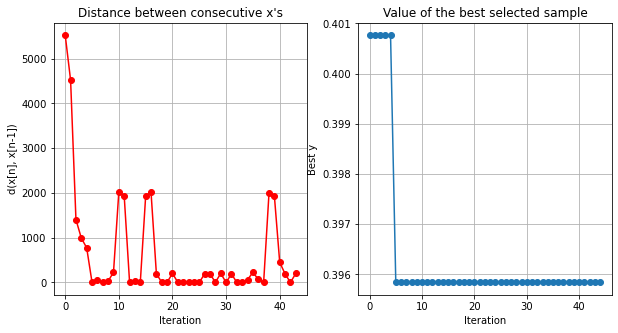

In [15]:
optimizer.plot_convergence()

In [19]:
[(bounds[i]['name'], optimum) for i, optimum in enumerate(optimizer.x_opt)]

[('learning_rate', 0.004663515283240011),
 ('n_layers', 3.0),
 ('layer_size', 128.0),
 ('batch_size', 256.0)]

In [18]:
from matplotlib import pyplot as plt

plt.plot(best['history'].history['mse'], label='Train')
plt.plot(best['history'].history['val_mse'], label='Validation')

plt.title('Loss v. Epoch')
plt.ylabel('MSE')
plt.xlabel('Epoch')

plt.legend(loc='upper right')
plt.show()

KeyError: 'mse'